# Trabalho de Conclusão de Curso - ENAP 

# Especialização em Ciência de Dados

# Aluno: Isvaldo S. Lima Filho

# Orientador: Prof. Dr. James Sampaio


# Tema: ANÁLISE DOS FATORES DETERMINANTES DA TAXA DE OCUPAÇÃO E CONCLUSÃO NO ENSINO SUPERIOR NO BRASIL

## Versão 1.2 (13/9/2022)

In [1]:
# Importanção das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import csv
import string as string
import re
import math





# PARTE 1: ETL (Extração-Carga-Tratamento dos dados)

## Fonte de dados (na ordem em que foram tratados):

## 1.1) Estimativa Populacional por muncípio (2018, 2019 e 2020) - Fonte: IBGE
## 1.2) Dados de Regiões Geográficas por município - Fonte: IBGE - 2017
##### Nessa pesquisa trabalhamos com dados agregados por "Regiões Geográficas Imediatas (RGI)", assim definidas pelo IBGE: 
##### "Têm na rede urbana o seu principal elemento de referência. As RGIs são estruturas a partir de centros urbanos próximos para a satisfação das necessidades imediatas das populações, tais como compras de bens de consumo duráveis e não duráveis, busca de trabalho, procura por serviços de saúde e de educaçãoo, e a prestação de serviços públicos, tais como postos de atendimento do INSS, do Ministério do Trabalho e Emprego e do Judiciário, entre outros".

## 1.3) Dados do Censo - Rendimento mensal (per capta) - Fonte: IBGE (Censo 2010)
## 1.4) Dados do Censo Escolar - Percentual de Matrículas no Ensino Médio (2018, 2019,                     2020) - Fonte: INEP
## 1.5) Dados do Ideb - Ensino Médio (2019) - Fonte: INEP
## 1.6) Dados do Enem - notas e num. candidatos (2018, 2019, 2020) - Fonte: INEP
## 1.7) Dados do Enade - CPC (2015 a 2019) - Fonte: INEP
## 1.8) Dados do Censo Educação Superior - INEP (2018, 2019 e 2020)


## Saídas:
## 1.9) Cursos Presenciais (com avaliação Enade-CPC)
##        Agregado com informação de Renda, População, Ensino Médio (matrículas e Ideb),
##        Enem (num candidatos e média das notas).



##### Obs: os arquivos foram baixados dos links indicados e carregados a partir da pasta local (formatos .cvs e .xlsx) por questões práticas. 


## 1.1) Dados de Estimativa Populacional por município para os anos de 2018, 2019 e 2020

#### Fonte dos dados: IBGE (https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?edicao=31451&t=resultados) - <acesso em: 18/7/2022>

In [2]:
mun_cols_names = ['COD_MUN','MUNICIPIO','POPULACAO','ANO']


In [3]:
#importando os dados da pasta local
ano="2018" # ano = "2018"
path_ibge_pop = 'C://DadosTCC/estimativa_pop_2018_municipios.xlsx'
df_muni_ano = pd.read_excel(path_ibge_pop, dtype=str, names=mun_cols_names[:-1] )
df_muni_ano['ANO']= ano
df_muni = df_muni_ano


ano="2019" # ano = "2019" 
path_ibge_pop = 'C://DadosTCC/estimativa_dou_2019_municipios.xlsx'
df_muni_ano = pd.read_excel(path_ibge_pop, dtype=str)
df_muni_ano['ANO']= ano
df_muni_ano['COD_MUN'] = df_muni_ano['COD. UF'] + df_muni_ano['COD. MUNIC']
df_muni_ano.rename(columns={'NOME DO MUNICÍPIO':'MUNICIPIO','POPULAÇÃO ESTIMADA':'POPULACAO'}, inplace=True)                                   
df_muni = df_muni.append(df_muni_ano[mun_cols_names] , ignore_index=True)

ano="2020" # ano =  "2020"
path_ibge_pop = 'C://DadosTCC/estimativa_dou_2020_municipios.xlsx'
df_muni_ano = pd.read_excel(path_ibge_pop, dtype=str)
df_muni_ano['ANO']= ano
df_muni_ano['COD_MUN'] = df_muni_ano['COD. UF'] + df_muni_ano['COD. MUNIC']
df_muni_ano.rename(columns={'NOME DO MUNICÍPIO':'MUNICIPIO','POPULAÇÃO ESTIMADA':'POPULACAO'}, inplace=True)                                   
df_muni_ano
df_muni = df_muni.append(df_muni_ano[mun_cols_names] , ignore_index=True)

df_muni

COD_MUN                   MUNICIPIO POPULACAO   ANO
0      1100015  Alta Floresta D'Oeste (RO)     23167  2018
1      1100023              Ariquemes (RO)    106168  2018
2      1100031                 Cabixi (RO)      5438  2018
3      1100049                 Cacoal (RO)     84813  2018
4      1100056             Cerejeiras (RO)     16444  2018
...        ...                         ...       ...   ...
16705  5222005                  Vianópolis     13977  2020
16706  5222054              Vicentinópolis      8873  2020
16707  5222203                    Vila Boa      6312  2020
16708  5222302               Vila Propício      5882  2020
16709  5300108                    Brasília   3055149  2020

[16710 rows x 4 columns]

In [4]:
# Formatando o campo POPULACAO (alguns registros vêm dessa forma, por exemplo: '38737 (6)')

def populacao_format(pop):
  if re.search('\w+(?=\s*\(.*\))', pop):
     return(re.search('\w+(?=\s*\(.*\))', pop).group(0))
  else:
     return(pop)         

df_muni['POPULACAO'] = df_muni['POPULACAO'].apply(lambda x: populacao_format(x)).astype('int64')

df_muni

COD_MUN                   MUNICIPIO  POPULACAO   ANO
0      1100015  Alta Floresta D'Oeste (RO)      23167  2018
1      1100023              Ariquemes (RO)     106168  2018
2      1100031                 Cabixi (RO)       5438  2018
3      1100049                 Cacoal (RO)      84813  2018
4      1100056             Cerejeiras (RO)      16444  2018
...        ...                         ...        ...   ...
16705  5222005                  Vianópolis      13977  2020
16706  5222054              Vicentinópolis       8873  2020
16707  5222203                    Vila Boa       6312  2020
16708  5222302               Vila Propício       5882  2020
16709  5300108                    Brasília    3055149  2020

[16710 rows x 4 columns]

In [5]:
# Formatando o campo UF (em 2018 tem informação com a sigla da UF, por exemplo: 'São José (SP)')

def nome_UF(mun):
  good_chars = 'a-zA-Z0-9\s\'áéíóúüÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ\-'  
  if re.search('['+ good_chars+']*(\(.*\))', mun):
    return(re.search('['+ good_chars+']*\((.*)\)', mun).group(1))   
  else:
     return('XX')         

df_muni['UF'] = df_muni['MUNICIPIO'].apply(lambda x: nome_UF(x)).str.strip()



df_muni.head(100)

COD_MUN                   MUNICIPIO  POPULACAO   ANO  UF
0   1100015  Alta Floresta D'Oeste (RO)      23167  2018  RO
1   1100023              Ariquemes (RO)     106168  2018  RO
2   1100031                 Cabixi (RO)       5438  2018  RO
3   1100049                 Cacoal (RO)      84813  2018  RO
4   1100056             Cerejeiras (RO)      16444  2018  RO
..      ...                         ...        ...   ...  ..
95  1301407               Eirunepé (AM)      34840  2018  AM
96  1301506                 Envira (AM)      19668  2018  AM
97  1301605              Fonte Boa (AM)      18221  2018  AM
98  1301654                Guajará (AM)      16416  2018  AM
99  1301704                Humaitá (AM)      54001  2018  AM

[100 rows x 5 columns]

In [6]:
# Formatando o campo MUNICIPIO (alguns registros vêm dessa forma, por exemplo: 'São José (SP)')

def nome_mun_format(mun):
  good_chars = 'a-zA-Z0-9\s\'áéíóúüÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ\-'  
  if re.search('['+ good_chars+']*(?=\(.*\))', mun):
     return(re.search('['+ good_chars+']*(?=\(.*\))', mun).group(0))
  else:
     return(mun)         

df_muni['MUNICIPIO'] = df_muni['MUNICIPIO'].apply(lambda x: nome_mun_format(x)).str.strip()



df_muni.head(200)

COD_MUN              MUNICIPIO  POPULACAO   ANO  UF
0    1100015  Alta Floresta D'Oeste      23167  2018  RO
1    1100023              Ariquemes     106168  2018  RO
2    1100031                 Cabixi       5438  2018  RO
3    1100049                 Cacoal      84813  2018  RO
4    1100056             Cerejeiras      16444  2018  RO
..       ...                    ...        ...   ...  ..
195  1502905                 Curuçá      39540  2018  PA
196  1502939             Dom Eliseu      58956  2018  PA
197  1502954    Eldorado do Carajás      33674  2018  PA
198  1503002                   Faro       7319  2018  PA
199  1503044   Floresta do Araguaia      20080  2018  PA

[200 rows x 5 columns]

In [7]:
# Sigla da UF
df_mun_uf = df_muni.loc[df_muni['ANO']=='2018',['COD_MUN','UF']]
df_mun_uf


COD_MUN  UF
0     1100015  RO
1     1100023  RO
2     1100031  RO
3     1100049  RO
4     1100056  RO
...       ...  ..
5565  5222005  GO
5566  5222054  GO
5567  5222203  GO
5568  5222302  GO
5569  5300108  DF

[5570 rows x 2 columns]

In [8]:
# Nome do Município
df_mun_nome = df_muni.loc[df_muni['ANO']=='2020',['COD_MUN','MUNICIPIO']]
df_mun_nome


COD_MUN              MUNICIPIO
11140  1100015  Alta Floresta D'Oeste
11141  1100023              Ariquemes
11142  1100031                 Cabixi
11143  1100049                 Cacoal
11144  1100056             Cerejeiras
...        ...                    ...
16705  5222005             Vianópolis
16706  5222054         Vicentinópolis
16707  5222203               Vila Boa
16708  5222302          Vila Propício
16709  5300108               Brasília

[5570 rows x 2 columns]

In [9]:
# Merge Sigla UF e Nome do Município
df_nome_mun_uf = df_mun_uf.merge(df_mun_nome, on='COD_MUN', how='inner')
df_nome_mun_uf


COD_MUN  UF              MUNICIPIO
0     1100015  RO  Alta Floresta D'Oeste
1     1100023  RO              Ariquemes
2     1100031  RO                 Cabixi
3     1100049  RO                 Cacoal
4     1100056  RO             Cerejeiras
...       ...  ..                    ...
5565  5222005  GO             Vianópolis
5566  5222054  GO         Vicentinópolis
5567  5222203  GO               Vila Boa
5568  5222302  GO          Vila Propício
5569  5300108  DF               Brasília

[5570 rows x 3 columns]

In [10]:
# Pivoteando o dataframe e renomeando as colunas
df_pivot = pd.pivot_table(df_muni, values='POPULACAO', columns=['ANO'], index=['COD_MUN']).rename_axis(None, axis=1)

df_pivot.reset_index(inplace=True)
df_pivot.rename(columns={'2018':'POPULACAO_2018','2019':'POPULACAO_2019','2020':'POPULACAO_2020'}, inplace=True)                                   
df_pivot


COD_MUN  POPULACAO_2018  POPULACAO_2019  POPULACAO_2020
0     1100015           23167           22945           22728
1     1100023          106168          107863          109523
2     1100031            5438            5312            5188
3     1100049           84813           85359           85893
4     1100056           16444           16323           16204
...       ...             ...             ...             ...
5565  5222005           13746           13863           13977
5566  5222054            8611            8743            8873
5567  5222203            6026            6171            6312
5568  5222302            5758            5821            5882
5569  5300108         2974703         3015268         3055149

[5570 rows x 4 columns]

In [11]:
# Merge resultado com Sigla UF e Nome do Município
df_pivot = df_pivot.merge(df_nome_mun_uf, on='COD_MUN', how='inner')[['COD_MUN','UF', 'MUNICIPIO','POPULACAO_2018', 'POPULACAO_2019','POPULACAO_2020']] 
df_pivot


COD_MUN  UF              MUNICIPIO  POPULACAO_2018  POPULACAO_2019  \
0     1100015  RO  Alta Floresta D'Oeste           23167           22945   
1     1100023  RO              Ariquemes          106168          107863   
2     1100031  RO                 Cabixi            5438            5312   
3     1100049  RO                 Cacoal           84813           85359   
4     1100056  RO             Cerejeiras           16444           16323   
...       ...  ..                    ...             ...             ...   
5565  5222005  GO             Vianópolis           13746           13863   
5566  5222054  GO         Vicentinópolis            8611            8743   
5567  5222203  GO               Vila Boa            6026            6171   
5568  5222302  GO          Vila Propício            5758            5821   
5569  5300108  DF               Brasília         2974703         3015268   

      POPULACAO_2020  
0              22728  
1             109523  
2               5188  
3              85893  
4              16204  
...              ...  
5565           13977  
5566            8873  
5567            6312  
5568            5882  
5569         3055149  

[5570 rows x 6 columns]

In [12]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/estimativa_pop_municipios.xlsx'
df_pivot.to_excel(path_output, index=False)


## 1.2) Dados de Regiões Geográficas por município - IBGE - 2017

#### Nessa pesquisa trabalhamos com dados agregados por "Regiões Geográficas Imediatas (RGI)", assim definido pelo IBGE: 
##### "Têm na rede urbana o seu principal elemento de referência. As RGIs são estruturas a partir de centros urbanos próximos para a satisfação das necessidades imediatas das populações, tais como compras de bens de consumo duráveis e não duráveis, busca de trabalho, procura por serviços de saúde e de educaçãoo, e a prestação de serviços públicos, tais como postos de atendimento do INSS, do Ministério do Trabalho e Emprego e do Judiciário, entre outros".

#### Fonte dos dados: IBGE - (https://www.ibge.gov.br/geociencias/organizacao-do-territorio/divisao-regional/15778-divisoes-regionais-do-brasil.html?=&t=downloads) - <acesso em: 21/7/2022>

In [19]:
# Lendo arquivo das regiões geográficas (RGIs - Regiões Geográficas Imediatas e RGInts - Regiões Geográficas Intermediárias) - IBGE - 2017
# renomeia, seleciona e reordena as colunas de interesse: Cod.Município, Nome Município, Cod. Região Geográfica Imediata e Nome Região Geográfica Imediata
path_ibge_regioes = 'C://DadosTCC/regioes_geograficas_composicao_por_municipios_2017_20180911.xlsx'
cols_names = ['MUNICIPIO','COD_MUN','COD_RGI','NOME_RGI','COD_RGINT','NOME_RGINT']
df_reg_muni = pd.read_excel(path_ibge_regioes, dtype=str, names=cols_names)
df_reg_muni=df_reg_muni[['COD_MUN','MUNICIPIO','COD_RGI','NOME_RGI']]

df_reg_muni

COD_MUN              MUNICIPIO COD_RGI          NOME_RGI
0     1101104        Itapuã do Oeste  110001       Porto Velho
1     1100809     Candeias do Jamari  110001       Porto Velho
2     1100338            Nova Mamoré  110001       Porto Velho
3     1100205            Porto Velho  110001       Porto Velho
4     1100106          Guajará-Mirim  110001       Porto Velho
...       ...                    ...     ...               ...
5565  5207907        Flores de Goiás  520022   Flores de Goiás
5566  5205307             Cavalcante  520022   Flores de Goiás
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás
5569  5300108               Brasília  530001  Distrito Federal

[5570 rows x 4 columns]

In [79]:
str1= 'Cidade Um - Cidade Doi Três - Cidade Quatro'
list1=str1.split('-')
list1=[item.strip() for item in list1]
print (list1.count('Cidade Um'))

1


In [83]:
# Incluir informação se município é Pólo de seu RGI
# se string 'MUNICIPIO' está contida na string 'NOME_RGI'
def testar_polo(muni, rgi):
  if muni in rgi:
     return('S')
  else:
     return('N')         

df_reg_muni['POLO'] = df_reg_muni[['MUNICIPIO','NOME_RGI']].apply(lambda x: testar_polo(x['MUNICIPIO'],x['NOME_RGI']), axis=1)

df_reg_muni

COD_MUN              MUNICIPIO COD_RGI          NOME_RGI POLO
0     1101104        Itapuã do Oeste  110001       Porto Velho    N
1     1100809     Candeias do Jamari  110001       Porto Velho    N
2     1100338            Nova Mamoré  110001       Porto Velho    N
3     1100205            Porto Velho  110001       Porto Velho    S
4     1100106          Guajará-Mirim  110001       Porto Velho    N
...       ...                    ...     ...               ...  ...
5565  5207907        Flores de Goiás  520022   Flores de Goiás    S
5566  5205307             Cavalcante  520022   Flores de Goiás    N
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás    N
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás    N
5569  5300108               Brasília  530001  Distrito Federal    N

[5570 rows x 5 columns]

In [84]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/regiao_geografica_municipios.xlsx'
df_reg_muni.to_excel(path_output, index=False)

## 1.3) Dados do Censo - Rendimento mensal (per capta) agrupado por Município/RGI

#### Fonte dos dados: IBGE - Censo 2010 (https://www.ibge.gov.br/estatisticas/sociais/populacao/22827-censo-2020-censo4.html?=&t=downloads) - <acesso em: 21/7/2022>

##### Obs: O censo de 2010 contava com 5565 municípios

In [111]:
# Lendo dados do Censo 2010 - Rendimento mensal per capta (Tabela 8)
# Deleta os subtotais da tabela importada
path_censo_2010_renda = 'C://DadosTCC/tab8_censo_2010.xlsx'
cols_names = ['COD_MUN','UF','MUNICIPIO','VLR_MEDIO_REND','VLR_QUARTIL_1','VLR_MEDIANA_REND','VALOR_QUARTIL_3']
dict= {'COD_MUN':str, 'UF':str, 'MUNICIPIO':str, 'VLR_MEDIO_REND':np.int64,'VLR_MEDIANA_REND':np.int64}
df_censo_2010_renda = pd.read_excel(path_censo_2010_renda, dtype=dict , names=cols_names)
df_censo_2010_renda.dropna(subset=['COD_MUN'], inplace=True)

df_censo_2010_renda


COD_MUN  UF      MUNICIPIO  VLR_MEDIO_REND  VLR_QUARTIL_1  \
1     4200051  SC  Abdon Batista             450            175   
2     1700251  TO    Abreulândia             436            109   
3     3100401  MG        Acaiaca             324            128   
4     4300034  RS         Aceguá             693            186   
5     5200159  GO      Adelândia             464            200   
...       ...  ..            ...             ...            ...   
5567  2111300  MA       São Luís             653            175   
5568  3550308  SP      São Paulo            1180            318   
5569  3552205  SP       Sorocaba             901            334   
5570  2211001  PI       Teresina             636            170   
5571  3170206  MG     Uberlândia             865            340   

      VLR_MEDIANA_REND  VALOR_QUARTIL_3  
1                  344              560  
2                  200              358  
3                  238              405  
4                  340              600  
5                  340              510  
...                ...              ...  
5567               329              630  
5568               575             1167  
5569               570             1000  
5570               323              617  
5571               536              940  

[5565 rows x 7 columns]

In [112]:
# Lendo dados do Censo 2010 - População (Tabela 1)
# Deleta os subtotais da tabela importada
path_censo_2010_pop = 'C://DadosTCC/tab1_censo_2010.xlsx'
cols_names = ['COD_MUN','UF','MUNICIPIO','POPULACAO','URBANA','RURAL','HOMEM','MULHER','RAZÃO_SEXO']
dict= {'COD_MUN':str, 'UF':str, 'MUNICIPIO':str, 'POPULACAO':np.float64}
df_censo_2010_pop = pd.read_excel(path_censo_2010_pop, dtype=dict , names=cols_names)
df_censo_2010_pop.dropna(subset=['COD_MUN'], inplace=True)

df_censo_2010_pop

COD_MUN  UF      MUNICIPIO   POPULACAO  URBANA  RURAL  HOMEM  MULHER  \
2     4200051  SC  Abdon Batista      2653.0   27.29  72.71  52.09   47.91   
3     1700251  TO    Abreulândia      2391.0   61.73  38.27  52.74   47.26   
4     3100401  MG        Acaiaca      3920.0   65.13  34.87  48.32   51.68   
5     4300034  RS         Aceguá      4394.0   24.10   75.9  52.41   47.59   
6     5200159  GO      Adelândia      2477.0   89.10   10.9  51.39   48.61   
...       ...  ..            ...         ...     ...    ...    ...     ...   
5568  2111300  MA       São Luís   1014837.0   94.45   5.55  46.81   53.19   
5569  3550308  SP      São Paulo  11253503.0   99.10    0.9  47.35   52.65   
5570  3552205  SP       Sorocaba    586625.0   98.98   1.02  48.93   51.07   
5571  2211001  PI       Teresina    814230.0   94.27   5.73  46.75   53.25   
5572  3170206  MG     Uberlândia    604013.0   97.23   2.77  48.83   51.17   

      RAZÃO_SEXO  
2     108.724692  
3     111.595430  
4      93.498452  
5     110.128178  
6     105.718988  
...          ...  
5568   88.005264  
5569   89.933523  
5570   95.809673  
5571   87.793427  
5572   95.427008  

[5565 rows x 9 columns]

In [114]:
# Merge População e Renda

df_censo_2010_pop_renda = df_censo_2010_renda.merge(df_censo_2010_pop, on='COD_MUN', how='inner',suffixes=(None, '_y')) [['COD_MUN','UF', 'MUNICIPIO','POPULACAO', 'VLR_MEDIO_REND','VLR_MEDIANA_REND']] 
df_censo_2010_pop_renda




COD_MUN  UF      MUNICIPIO   POPULACAO  VLR_MEDIO_REND  VLR_MEDIANA_REND
0     4200051  SC  Abdon Batista      2653.0             450               344
1     1700251  TO    Abreulândia      2391.0             436               200
2     3100401  MG        Acaiaca      3920.0             324               238
3     4300034  RS         Aceguá      4394.0             693               340
4     5200159  GO      Adelândia      2477.0             464               340
...       ...  ..            ...         ...             ...               ...
5560  2111300  MA       São Luís   1014837.0             653               329
5561  3550308  SP      São Paulo  11253503.0            1180               575
5562  3552205  SP       Sorocaba    586625.0             901               570
5563  2211001  PI       Teresina    814230.0             636               323
5564  3170206  MG     Uberlândia    604013.0             865               536

[5565 rows x 6 columns]

In [115]:
df_reg_muni

COD_MUN              MUNICIPIO COD_RGI          NOME_RGI POLO
0     1101104        Itapuã do Oeste  110001       Porto Velho    N
1     1100809     Candeias do Jamari  110001       Porto Velho    N
2     1100338            Nova Mamoré  110001       Porto Velho    N
3     1100205            Porto Velho  110001       Porto Velho    S
4     1100106          Guajará-Mirim  110001       Porto Velho    N
...       ...                    ...     ...               ...  ...
5565  5207907        Flores de Goiás  520022   Flores de Goiás    S
5566  5205307             Cavalcante  520022   Flores de Goiás    N
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás    N
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás    N
5569  5300108               Brasília  530001  Distrito Federal    N

[5570 rows x 5 columns]

In [119]:
# Fazendo o merge das informações de redimento (per capta) e população dos municípios por RGI
df_rgi_merged = df_reg_muni.merge(df_censo_2010_pop_renda, on='COD_MUN', how='inner',suffixes=(None, '_y'))\
                [['COD_MUN', 'MUNICIPIO','COD_RGI','NOME_RGI','POLO','POPULACAO', 'VLR_MEDIO_REND','VLR_MEDIANA_REND']] 
df_rgi_merged.sort_values(by=['COD_RGI','COD_MUN'], inplace=True,
               ascending = [True, True])

df_rgi_merged

COD_MUN           MUNICIPIO COD_RGI          NOME_RGI POLO  POPULACAO  \
4     1100106       Guajará-Mirim  110001       Porto Velho    N    41656.0   
3     1100205         Porto Velho  110001       Porto Velho    S   428527.0   
2     1100338         Nova Mamoré  110001       Porto Velho    N    22546.0   
1     1100809  Candeias do Jamari  110001       Porto Velho    N    19779.0   
0     1101104     Itapuã do Oeste  110001       Porto Velho    N     8566.0   
...       ...                 ...     ...               ...  ...        ...   
5560  5207907     Flores de Goiás  520022   Flores de Goiás    S    12066.0   
5559  5220009  São João d'Aliança  520022   Flores de Goiás    N    10257.0   
5558  5221080   Teresina de Goiás  520022   Flores de Goiás    N     3016.0   
5557  5222203            Vila Boa  520022   Flores de Goiás    N     4735.0   
5564  5300108            Brasília  530001  Distrito Federal    N  2570160.0   

      VLR_MEDIO_REND  VLR_MEDIANA_REND  
4                472               267  
3                765               450  
2                324               205  
1                428               287  
0                389               260  
...              ...               ...  
5560             300               192  
5559             374               242  
5558             342               214  
5557             385               255  
5564            1404               605  

[5565 rows x 8 columns]

In [131]:
# Agrupando e calculando o Rendimento Médio Mensal (per capta) por RGI
def my_agg(x):
    names = {
        'TOT_POPULACAO': x['POPULACAO'].sum(),
        'TOT_VLR_REND_POND': (x['POPULACAO']*x['VLR_MEDIO_REND']).sum(),
        }
    return pd.Series(names)

df_rgi_rend_medio = df_rgi_merged.groupby('COD_RGI', as_index=False)['COD_MUN','COD_RGI','POPULACAO','VLR_MEDIO_REND'].apply(my_agg)
df_rgi_rend_medio['VLR_REND_MEDIO']=round(df_rgi_rend_medio['TOT_VLR_REND_POND']/df_rgi_rend_medio['TOT_POPULACAO'],2)
df_rgi_rend_medio


COD_RGI  TOT_POPULACAO  TOT_VLR_REND_POND  VLR_REND_MEDIO
0    110001       521074.0       3.665873e+08          703.52
1    110002       191533.0       9.304027e+07          485.77
2    110003       113685.0       4.683498e+07          411.97
3    110004       302323.0       1.507746e+08          498.72
4    110005       296260.0       1.458937e+08          492.45
..      ...            ...                ...             ...
505  520019       568274.0       3.006178e+08          529.00
506  520020       396229.0       1.791451e+08          452.13
507  520021       124856.0       4.778033e+07          382.68
508  520022        51441.0       1.963995e+07          381.80
509  530001      2570160.0       3.608505e+09         1404.00

[510 rows x 4 columns]

In [134]:
df_rgi_rend_mean_md = df_reg_muni.merge(df_rgi_rend_medio, on='COD_RGI', how='left',suffixes=(None, '_y')) [['COD_MUN', 'MUNICIPIO','COD_RGI','NOME_RGI','POLO', 'VLR_REND_MEDIO']] 
df_rgi_rend_mean_md.rename(columns={'VLR_REND_MEDIO':'VLR_REND_MEDIO_RGI'}, inplace=True)                                   
df_rgi_rend_mean_md

COD_MUN              MUNICIPIO COD_RGI          NOME_RGI POLO  \
0     1101104        Itapuã do Oeste  110001       Porto Velho    N   
1     1100809     Candeias do Jamari  110001       Porto Velho    N   
2     1100338            Nova Mamoré  110001       Porto Velho    N   
3     1100205            Porto Velho  110001       Porto Velho    S   
4     1100106          Guajará-Mirim  110001       Porto Velho    N   
...       ...                    ...     ...               ...  ...   
5565  5207907        Flores de Goiás  520022   Flores de Goiás    S   
5566  5205307             Cavalcante  520022   Flores de Goiás    N   
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás    N   
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás    N   
5569  5300108               Brasília  530001  Distrito Federal    N   

      VLR_REND_MEDIO_RGI  
0                 703.52  
1                 703.52  
2                 703.52  
3                 703.52  
4                 703.52  
...                  ...  
5565              381.80  
5566              381.80  
5567              381.80  
5568              381.80  
5569             1404.00  

[5570 rows x 6 columns]

In [149]:
# Agrupando e calculando a Mediana Ponderada (Weighted Median) dos rendimentos mensais (per capta) por RGI

### Código exemplificativo
###
### wages = [598, 650, 660, 680, 712, 830]
### pop = [230000,300000,120000,1500000,600000,330000]
### d = {'Wages':wages,'Populacao':pop}
### df = pd.DataFrame(d)
### df['CumSum'] = df['Populacao'].cumsum()
### cutoff = df['Populacao'].sum() / 2.0
### median = df[df['CumSum'] > cutoff].iloc[0,0]
###

## Criando dataFrame de saída
df_rgi_rend_w_md = pd.DataFrame({'COD_RGI': pd.Series(dtype='object'),
                                'VLR_REND_W_MD_RGI': pd.Series(dtype='int64')})
## Fazendo o agrupamento por RGI
by_rgi =  df_rgi_merged.groupby('COD_RGI', as_index=False)

## Iterando com o GroupByDataFrame (pra cada grupo de municípios de um dado RGI)
for rgi, frame in by_rgi:
    frame.sort_values(by=['VLR_MEDIANA_REND'],inplace=True)
    frame['CumSum']=frame['POPULACAO'].cumsum()
    cutoff = frame['POPULACAO'].sum() / 2.0
    median = frame[frame['CumSum'] > cutoff].iloc[0,7]
    ## Adicionando nova linha do DataFrame de saída para o RGI corrente 
    new_row = {'COD_RGI':rgi, 'VLR_REND_W_MD_RGI':median}
    df_rgi_rend_w_md = df_rgi_rend_w_md.append(new_row, ignore_index=True)
    
df_rgi_rend_w_md



COD_RGI  VLR_REND_W_MD_RGI
0    110001                450
1    110002                300
2    110003                237
3    110004                345
4    110005                370
..      ...                ...
505  520019                330
506  520020                300
507  520021                250
508  520022                242
509  530001                605

[510 rows x 2 columns]

In [152]:
df_rgi_rend_mean_md = df_rgi_rend_mean_md.merge(df_rgi_rend_w_md, on='COD_RGI', how='left',suffixes=(None, '_y')) [['COD_MUN', 'MUNICIPIO','COD_RGI','NOME_RGI','POLO', 'VLR_REND_MEDIO_RGI','VLR_REND_W_MD_RGI']] 
df_rgi_rend_mean_md

COD_MUN              MUNICIPIO COD_RGI          NOME_RGI POLO  \
0     1101104        Itapuã do Oeste  110001       Porto Velho    N   
1     1100809     Candeias do Jamari  110001       Porto Velho    N   
2     1100338            Nova Mamoré  110001       Porto Velho    N   
3     1100205            Porto Velho  110001       Porto Velho    S   
4     1100106          Guajará-Mirim  110001       Porto Velho    N   
...       ...                    ...     ...               ...  ...   
5565  5207907        Flores de Goiás  520022   Flores de Goiás    S   
5566  5205307             Cavalcante  520022   Flores de Goiás    N   
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás    N   
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás    N   
5569  5300108               Brasília  530001  Distrito Federal    N   

      VLR_REND_MEDIO_RGI  VLR_REND_W_MD_RGI  
0                 703.52                450  
1                 703.52                450  
2                 703.52                450  
3                 703.52                450  
4                 703.52                450  
...                  ...                ...  
5565              381.80                242  
5566              381.80                242  
5567              381.80                242  
5568              381.80                242  
5569             1404.00                605  

[5570 rows x 7 columns]

In [154]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/rgi_rendimento_mensal_med_md_pond.xlsx'
df_rgi_rend_mean_md.to_excel(path_output, index=False)

## 1.4) Dados do Censo Escolar - Percentual de Matrículas no Ensino Médio (por município/RGI)

#### Fonte dos dados: INEP - Censo Escolar 2018, 2019 e 2020 (https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/censo-escolar) - <acesso em: 21/7/2022>

##### Percetual de matrículas em relação à população estimada para os anos de 2018, 2019 e 2020

In [2]:
cols_names=['ANO','COD_MUN','COD_ESCOLA','NOME_ESCOLA','TIPO_ESCOLA','TIPO_LOCAL','SITUACAO','QT_MAT_MED','QT_MAT_PROF','QT_MAT_EJA_MED']

In [3]:
#importando os dados da pasta local
# ano = "2018"
path_inep_censo = 'C://DadosTCC/censo_escolar_2018.xlsx'
df_censo_basica_ano = pd.read_excel(path_inep_censo, dtype=str, usecols=[0,7,13,14,15,17,26,305,307,310] ,names=cols_names)
df_censo_basica = df_censo_basica_ano

df_censo_basica 

ANO  COD_MUN COD_ESCOLA                          NOME_ESCOLA  \
0       2018  1100015   11022558                EIEEF HAP BITT TUPARI   
1       2018  1100015   11024275             CEEJA LUIZ VAZ DE CAMOES   
2       2018  1100015   11024291                  EMMEF 7 DE SETEMBRO   
3       2018  1100015   11024372                      EMEIEF ANA NERY   
4       2018  1100015   11024402       EMMEF ANTONIO FRANCISCO LISBOA   
...      ...      ...        ...                                  ...   
236455  2018  5300108   53086007                    CED VITORIA REGIA   
236456  2018  5300108   53087003            CED SANTOS DUMONT - CESAN   
236457  2018  5300108   53087011                            INST MAUA   
236458  2018  5300108   53088000                              CEUBRAS   
236459  2018  5300108   53088034  OBRA SOCIAL NOSSA SENHORA DE FATIMA   

       TIPO_ESCOLA TIPO_LOCAL SITUACAO QT_MAT_MED QT_MAT_PROF QT_MAT_EJA_MED  
0                2          2        1          0           0              0  
1                2          1        1          0           0            126  
2                3          2        1          0           0              0  
3                3          1        1          0           0              0  
4                3          2        2        NaN         NaN            NaN  
...            ...        ...      ...        ...         ...            ...  
236455           4          1        1        141           0              0  
236456           4          1        2        NaN         NaN            NaN  
236457           4          1        1         71           0              0  
236458           4          1        1          0           0             94  
236459           4          1        2        NaN         NaN            NaN  

[236460 rows x 10 columns]

In [19]:
#importando os dados da pasta local
# ano = "2019"
path_inep_censo = 'C://DadosTCC/censo_escolar_2019.xlsx'
df_censo_basica_ano = pd.read_excel(path_inep_censo, dtype=str, usecols=[0,7,13,14,15,17,26,305,307,310] ,names=cols_names)
df_censo_basica = df_censo_basica.append(df_censo_basica_ano , ignore_index=True)

df_censo_basica 

ANO  COD_MUN COD_ESCOLA                          NOME_ESCOLA  \
0       2018  1100015   11022558                EIEEF HAP BITT TUPARI   
1       2018  1100015   11024275             CEEJA LUIZ VAZ DE CAMOES   
2       2018  1100015   11024291                  EMMEF 7 DE SETEMBRO   
3       2018  1100015   11024372                      EMEIEF ANA NERY   
4       2018  1100015   11024666                 EMEIEF BOA ESPERANCA   
...      ...      ...        ...                                  ...   
412262  2019  5300108   53084071                    ESC DIVINO MESTRE   
412263  2019  5300108   53085000                COBIAN - COL BIANGULO   
412264  2019  5300108   53086007                    CED VITORIA REGIA   
412265  2019  5300108   53087003            CED SANTOS DUMONT - CESAN   
412266  2019  5300108   53088034  OBRA SOCIAL NOSSA SENHORA DE FATIMA   

       TIPO_ESCOLA TIPO_LOCAL SITUACAO QT_MAT_MED QT_MAT_PROF QT_MAT_EJA_MED  
0                2          2        1          0           0              0  
1                2          1        1          0           0            126  
2                3          2        1          0           0              0  
3                3          1        1          0           0              0  
4                3          2        1          0           0              0  
...            ...        ...      ...        ...         ...            ...  
412262           4          1        2        NaN         NaN            NaN  
412263           4          1        1          0           0              0  
412264           4          1        1        129           0              0  
412265           4          1        2        NaN         NaN            NaN  
412266           4          1        2        NaN         NaN            NaN  

[412267 rows x 10 columns]

In [20]:
#importando os dados da pasta local
# ano = "2020"
path_inep_censo = 'C://DadosTCC/censo_escolar_2020.xlsx'
df_censo_basica_ano = pd.read_excel(path_inep_censo, dtype=str, usecols=[0,7,13,14,15,17,26,305,307,310] ,names=cols_names)
df_censo_basica = df_censo_basica.append(df_censo_basica_ano , ignore_index=True)

df_censo_basica 

ANO  COD_MUN COD_ESCOLA                          NOME_ESCOLA  \
0       2018  1100015   11022558                EIEEF HAP BITT TUPARI   
1       2018  1100015   11024275             CEEJA LUIZ VAZ DE CAMOES   
2       2018  1100015   11024291                  EMMEF 7 DE SETEMBRO   
3       2018  1100015   11024372                      EMEIEF ANA NERY   
4       2018  1100015   11024666                 EMEIEF BOA ESPERANCA   
...      ...      ...        ...                                  ...   
636491  2020  5300108   53084071                    ESC DIVINO MESTRE   
636492  2020  5300108   53085000                COBIAN - COL BIANGULO   
636493  2020  5300108   53086007                    CED VITORIA REGIA   
636494  2020  5300108   53087003            CED SANTOS DUMONT - CESAN   
636495  2020  5300108   53088034  OBRA SOCIAL NOSSA SENHORA DE FATIMA   

       TIPO_ESCOLA TIPO_LOCAL SITUACAO QT_MAT_MED QT_MAT_PROF QT_MAT_EJA_MED  
0                2          2        1          0           0              0  
1                2          1        1          0           0            126  
2                3          2        1          0           0              0  
3                3          1        1          0           0              0  
4                3          2        1          0           0              0  
...            ...        ...      ...        ...         ...            ...  
636491           4          1        2        NaN         NaN            NaN  
636492           4          1        1          0           0              0  
636493           4          1        1        116           0              0  
636494           4          1        2        NaN         NaN            NaN  
636495           4          1        2        NaN         NaN            NaN  

[636496 rows x 10 columns]

In [22]:
# Selecionando só escolas em atividade (SITUACAO = 1), redefinimdo tipos das colunas numéricas e calculando total
# de matrículas no ensino médio
df_censo_basica = df_censo_basica [df_censo_basica ['SITUACAO']=='1']
df_censo_basica.fillna(0, inplace=True)
df_censo_basica = df_censo_basica.astype({'QT_MAT_MED': 'int64','QT_MAT_PROF': 'int64', 'QT_MAT_EJA_MED': 'int64'})
df_censo_basica['QT_TOT_MAT_MED']=df_censo_basica['QT_MAT_MED']+df_censo_basica['QT_MAT_PROF']+df_censo_basica['QT_MAT_EJA_MED']

df_censo_basica

ANO  COD_MUN COD_ESCOLA               NOME_ESCOLA TIPO_ESCOLA  \
0       2018  1100015   11022558     EIEEF HAP BITT TUPARI           2   
1       2018  1100015   11024275  CEEJA LUIZ VAZ DE CAMOES           2   
2       2018  1100015   11024291       EMMEF 7 DE SETEMBRO           3   
3       2018  1100015   11024372           EMEIEF ANA NERY           3   
4       2018  1100015   11024666      EMEIEF BOA ESPERANCA           3   
...      ...      ...        ...                       ...         ...   
636487  2020  5300108   53084020       ESC PEQUENO ENCANTO           4   
636488  2020  5300108   53084039              COL ANCHIETA           4   
636489  2020  5300108   53084055                  COL MAPA           4   
636492  2020  5300108   53085000     COBIAN - COL BIANGULO           4   
636493  2020  5300108   53086007         CED VITORIA REGIA           4   

       TIPO_LOCAL SITUACAO  QT_MAT_MED  QT_MAT_PROF  QT_MAT_EJA_MED  \
0               2        1           0            0               0   
1               1        1           0            0             126   
2               2        1           0            0               0   
3               1        1           0            0               0   
4               2        1           0            0               0   
...           ...      ...         ...          ...             ...   
636487          1        1           0            0               0   
636488          1        1           0            0               0   
636489          1        1          86            0               0   
636492          1        1           0            0               0   
636493          1        1         116            0               0   

        QT_TOT_MAT_MED  
0                    0  
1                  126  
2                    0  
3                    0  
4                    0  
...                ...  
636487               0  
636488               0  
636489              86  
636492               0  
636493             116  

[547493 rows x 11 columns]

In [65]:
# Total de matrículas no ensino médio por município e por ano
df_censo_basica_mun = df_censo_basica.groupby(['ANO','COD_MUN'], as_index=False)['QT_TOT_MAT_MED'].sum()
df_censo_basica_mun


ANO  COD_MUN  QT_TOT_MAT_MED
0      2018  1100015             889
1      2018  1100023            5938
2      2018  1100031             205
3      2018  1100049            5772
4      2018  1100056             624
...     ...      ...             ...
16705  2020  5222005             496
16706  2020  5222054             462
16707  2020  5222203             229
16708  2020  5222302             274
16709  2020  5300108          157650

[16710 rows x 3 columns]

In [66]:
df_censo_basica_mat = pd.pivot_table(df_censo_basica_mun, values='QT_TOT_MAT_MED', columns=['ANO'], index=['COD_MUN']).rename_axis(None, axis=1)
df_censo_basica_mat.reset_index(inplace=True)
df_censo_basica_mat.rename(columns={'2018':'QT_TOT_MAT_2018','2019':'QT_TOT_MAT_2019','2020':'QT_TOT_MAT_2020'}, inplace=True)                                   
df_censo_basica_mat


COD_MUN  QT_TOT_MAT_2018  QT_TOT_MAT_2019  QT_TOT_MAT_2020
0     1100015              889              962              952
1     1100023             5938             6052             5902
2     1100031              205              206              233
3     1100049             5772             5822             5725
4     1100056              624              559              603
...       ...              ...              ...              ...
5565  5222005              556              499              496
5566  5222054              339              344              462
5567  5222203              200              201              229
5568  5222302              274              198              274
5569  5300108           156417           155602           157650

[5570 rows x 4 columns]

In [67]:
# lendo tabela de estimativa populacional dos municípios para os anos de 2018, 2019 e 2020
path_ibge_pop = 'C://DadosTCC/Saida/estimativa_pop_municipios.xlsx'
df_estimativa_pop = pd.read_excel(path_ibge_pop, dtype={'COD_MUN':object})
df_estimativa_pop


COD_MUN  UF              MUNICIPIO  POPULACAO_2018  POPULACAO_2019  \
0     1100015  RO  Alta Floresta D'Oeste           23167           22945   
1     1100023  RO              Ariquemes          106168          107863   
2     1100031  RO                 Cabixi            5438            5312   
3     1100049  RO                 Cacoal           84813           85359   
4     1100056  RO             Cerejeiras           16444           16323   
...       ...  ..                    ...             ...             ...   
5565  5222005  GO             Vianópolis           13746           13863   
5566  5222054  GO         Vicentinópolis            8611            8743   
5567  5222203  GO               Vila Boa            6026            6171   
5568  5222302  GO          Vila Propício            5758            5821   
5569  5300108  DF               Brasília         2974703         3015268   

      POPULACAO_2020  
0              22728  
1             109523  
2               5188  
3              85893  
4              16204  
...              ...  
5565           13977  
5566            8873  
5567            6312  
5568            5882  
5569         3055149  

[5570 rows x 6 columns]

In [68]:
# Calculando percentual de matrícula (ensino médio) em relação à população do município
# para os anos de 2018, 2019 e 2020
df_mat_prop_mun = df_estimativa_pop.merge(df_censo_basica_mat, on='COD_MUN',how='inner')[['COD_MUN','UF', 'MUNICIPIO','POPULACAO_2018', 'POPULACAO_2019','POPULACAO_2020',
                                                                      'QT_TOT_MAT_2018', 'QT_TOT_MAT_2019', 'QT_TOT_MAT_2020']] 
df_mat_prop_mun['PERC_MAT_MUN_2018']=df_mat_prop_mun['QT_TOT_MAT_2018']/df_mat_prop_mun['POPULACAO_2018']*100
df_mat_prop_mun['PERC_MAT_MUN_2019']=df_mat_prop_mun['QT_TOT_MAT_2019']/df_mat_prop_mun['POPULACAO_2019']*100
df_mat_prop_mun['PERC_MAT_MUN_2020']=df_mat_prop_mun['QT_TOT_MAT_2020']/df_mat_prop_mun['POPULACAO_2020']*100

df_mat_prop_mun

COD_MUN  UF              MUNICIPIO  POPULACAO_2018  POPULACAO_2019  \
0     1100015  RO  Alta Floresta D'Oeste           23167           22945   
1     1100023  RO              Ariquemes          106168          107863   
2     1100031  RO                 Cabixi            5438            5312   
3     1100049  RO                 Cacoal           84813           85359   
4     1100056  RO             Cerejeiras           16444           16323   
...       ...  ..                    ...             ...             ...   
5565  5222005  GO             Vianópolis           13746           13863   
5566  5222054  GO         Vicentinópolis            8611            8743   
5567  5222203  GO               Vila Boa            6026            6171   
5568  5222302  GO          Vila Propício            5758            5821   
5569  5300108  DF               Brasília         2974703         3015268   

      POPULACAO_2020  QT_TOT_MAT_2018  QT_TOT_MAT_2019  QT_TOT_MAT_2020  \
0              22728              889              962              952   
1             109523             5938             6052             5902   
2               5188              205              206              233   
3              85893             5772             5822             5725   
4              16204              624              559              603   
...              ...              ...              ...              ...   
5565           13977              556              499              496   
5566            8873              339              344              462   
5567            6312              200              201              229   
5568            5882              274              198              274   
5569         3055149           156417           155602           157650   

      PERC_MAT_MUN_2018  PERC_MAT_MUN_2019  PERC_MAT_MUN_2020  
0              3.837355           4.192635           4.188666  
1              5.593022           5.610821           5.388822  
2              3.769768           3.878012           4.491133  
3              6.805560           6.820605           6.665270  
4              3.794697           3.424616           3.721303  
...                 ...                ...                ...  
5565           4.044813           3.599509           3.548687  
5566           3.936825           3.934576           5.206807  
5567           3.318951           3.257171           3.628010  
5568           4.758597           3.401477           4.658279  
5569           5.258239           5.160470           5.160141  

[5570 rows x 12 columns]

In [44]:
# lendo tabela de Regiões Geográficas Imediatas (RGI)
path_ibge_rgi = 'C://DadosTCC/Saida/regiao_geografica_municipios.xlsx'
df_rgi = pd.read_excel(path_ibge_rgi, dtype={'COD_MUN':object,'COD_RGI':object})
df_rgi

COD_MUN              MUNICIPIO COD_RGI          NOME_RGI POLO
0     1101104        Itapuã do Oeste  110001       Porto Velho    N
1     1100809     Candeias do Jamari  110001       Porto Velho    N
2     1100338            Nova Mamoré  110001       Porto Velho    N
3     1100205            Porto Velho  110001       Porto Velho    S
4     1100106          Guajará-Mirim  110001       Porto Velho    N
...       ...                    ...     ...               ...  ...
5565  5207907        Flores de Goiás  520022   Flores de Goiás    S
5566  5205307             Cavalcante  520022   Flores de Goiás    N
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás    N
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás    N
5569  5300108               Brasília  530001  Distrito Federal    S

[5570 rows x 5 columns]

In [73]:
# Fazendo merge e calculando o percentual de matrículas no ensino médio por RGI (em relação à população)
df_prop_mat_merged = df_mat_prop_mun.merge(df_rgi, on='COD_MUN',how='inner',suffixes=(None, '_y'))[['COD_MUN','UF','COD_RGI','MUNICIPIO','POPULACAO_2018', 'POPULACAO_2019','POPULACAO_2020',
                                                        'QT_TOT_MAT_2018', 'QT_TOT_MAT_2019', 'QT_TOT_MAT_2020',
                                                        'PERC_MAT_MUN_2018', 'PERC_MAT_MUN_2019', 'PERC_MAT_MUN_2020']]
df_prop_mat_merged.sort_values(by=['COD_RGI','COD_MUN'], inplace=True, ascending = [True, True])
df_prop_mat_rgi = df_prop_mat_merged.groupby('COD_RGI',as_index=False)['POPULACAO_2018','QT_TOT_MAT_2018','POPULACAO_2019','QT_TOT_MAT_2019',
                                                        'POPULACAO_2020','QT_TOT_MAT_2020'].sum()
df_prop_mat_rgi['PERC_MAT_RGI_2018']=df_prop_mat_rgi['QT_TOT_MAT_2018']/df_prop_mat_rgi['POPULACAO_2018']*100
df_prop_mat_rgi['PERC_MAT_RGI_2019']=df_prop_mat_rgi['QT_TOT_MAT_2019']/df_prop_mat_rgi['POPULACAO_2019']*100
df_prop_mat_rgi['PERC_MAT_RGI_2020']=df_prop_mat_rgi['QT_TOT_MAT_2020']/df_prop_mat_rgi['POPULACAO_2020']*100
df_prop_mat_rgi


COD_RGI  POPULACAO_2018  QT_TOT_MAT_2018  POPULACAO_2019  QT_TOT_MAT_2019  \
0    110001          631326            37232          643452            37895   
1    110002          229947             9877          234145            10093   
2    110003          120647             5257          121181             5729   
3    110004          312040            16069          312376            15702   
4    110005          307428            15934          307958            16279   
..      ...             ...              ...             ...              ...   
505  520019          684649            30083          697595            28746   
506  520020          479507            22065          488640            20720   
507  520021          137048             6819          138240             6883   
508  520022           61856             2152           62994             2119   
509  530001         2974703           156417         3015268           155602   

     POPULACAO_2020  QT_TOT_MAT_2020  PERC_MAT_RGI_2018  PERC_MAT_RGI_2019  \
0            655331            34173           5.897429           5.889328   
1            238255             9978           4.295338           4.310577   
2            121704             5869           4.357340           4.727639   
3            312704            15396           5.149660           5.026635   
4            308479            15963           5.183002           5.286110   
..              ...              ...                ...                ...   
505          710275            30091           4.393930           4.120729   
506          497585            22226           4.601601           4.240341   
507          139405             7672           4.975629           4.979022   
508           64106             2242           3.479048           3.363812   
509         3055149           157650           5.258239           5.160470   

     PERC_MAT_RGI_2020  
0             5.214617  
1             4.187950  
2             4.822356  
3             4.923506  
4             5.174744  
..                 ...  
505           4.236528  
506           4.466775  
507           5.503389  
508           3.497333  
509           5.160141  

[510 rows x 10 columns]

In [78]:
df_mat_mun_rgi = df_prop_mat_merged.merge(df_prop_mat_rgi,on='COD_RGI',how='left',suffixes=(None, '_y'))[['COD_MUN','UF','COD_RGI','MUNICIPIO',
                                                        'QT_TOT_MAT_2018', 'QT_TOT_MAT_2019', 'QT_TOT_MAT_2020',
                                                        'PERC_MAT_MUN_2018', 'PERC_MAT_MUN_2019', 'PERC_MAT_MUN_2020',
                                                        'PERC_MAT_RGI_2018','PERC_MAT_RGI_2019','PERC_MAT_RGI_2020']]
df_mat_mun_rgi

COD_MUN  UF COD_RGI           MUNICIPIO  QT_TOT_MAT_2018  \
0     1100106  RO  110001       Guajará-Mirim             2563   
1     1100205  RO  110001         Porto Velho            32072   
2     1100338  RO  110001         Nova Mamoré             1184   
3     1100809  RO  110001  Candeias do Jamari              984   
4     1101104  RO  110001     Itapuã do Oeste              429   
...       ...  ..     ...                 ...              ...   
5565  5207907  GO  520022     Flores de Goiás              384   
5566  5220009  GO  520022  São João d'Aliança              493   
5567  5221080  GO  520022   Teresina de Goiás              126   
5568  5222203  GO  520022            Vila Boa              200   
5569  5300108  DF  530001            Brasília           156417   

      QT_TOT_MAT_2019  QT_TOT_MAT_2020  PERC_MAT_MUN_2018  PERC_MAT_MUN_2019  \
0                2703             2762           5.598148           5.853944   
1               32602            28786           6.173260           6.156618   
2                1158             1153           3.978896           3.786417   
3                1053             1116           3.787092           3.944854   
4                 379              356           4.176402           3.624020   
...               ...              ...                ...                ...   
5565              355              394           2.385093           2.144108   
5566              474              501           3.682677           3.449782   
5567              118              148           3.688525           3.412377   
5568              201              229           3.318951           3.257171   
5569           155602           157650           5.258239           5.160470   

      PERC_MAT_MUN_2020  PERC_MAT_RGI_2018  PERC_MAT_RGI_2019  \
0              5.932640           5.897429           5.889328   
1              5.337126           5.897429           5.889328   
2              3.672910           5.897429           5.889328   
3              4.074777           5.897429           5.889328   
4              3.345550           5.897429           5.889328   
...                 ...                ...                ...   
5565           2.316966           3.479048           3.363812   
5566           3.556976           3.479048           3.363812   
5567           4.230989           3.479048           3.363812   
5568           3.628010           3.479048           3.363812   
5569           5.160141           5.258239           5.160470   

      PERC_MAT_RGI_2020  
0              5.214617  
1              5.214617  
2              5.214617  
3              5.214617  
4              5.214617  
...                 ...  
5565           3.497333  
5566           3.497333  
5567           3.497333  
5568           3.497333  
5569           5.160141  

[5570 rows x 13 columns]

In [79]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/perc_mat_ensino_medio.xlsx'
df_mat_mun_rgi.to_excel(path_output, index=False)

## 1.5) Dados do Ideb - Ensino Médio (por município/RGI)

#### Fonte dos dados: INEP - Ideb Ensino Médio de 2019 (https://download.inep.gov.br/educacao_basica/portal_ideb/planilhas_para_download/2019/divulgacao_ensino_medio_municipios_2019.zip) - <acesso em: 27/7/2022>

##### Ideb ponderado segundo proporção de matrículas no Ensino Médio do município entre escolas públicas e privadas

In [98]:
# Total de matrículas no ensino médio por município e tipo de escola (pública/privada) para o ano de 2019
df_mat_med_rede = df_censo_basica[(df_censo_basica['ANO']=='2019')&(df_censo_basica['TIPO_ESCOLA'].isin(['2','4']))&\
                                 (df_censo_basica['QT_TOT_MAT_MED'] >0)].groupby(['COD_MUN','TIPO_ESCOLA'], as_index=False)\
                                ['QT_TOT_MAT_MED'].sum()

df_mat_med_rede



COD_MUN TIPO_ESCOLA  QT_TOT_MAT_MED
0     1100015           2             962
1     1100023           2            4331
2     1100023           4             352
3     1100031           2             206
4     1100049           2            3404
...       ...         ...             ...
7219  5222054           2             344
7220  5222203           2             201
7221  5222302           2             198
7222  5300108           2          108763
7223  5300108           4           36556

[7224 rows x 3 columns]

In [104]:
# Calculando a proporção da rede escolar (pública e privada) de Ensino Médio
df_mat_prop_med_rede = pd.pivot_table(df_mat_med_rede, values='QT_TOT_MAT_MED', columns=['TIPO_ESCOLA'], index=['COD_MUN']).rename_axis(None, axis=1)
df_mat_prop_med_rede.reset_index(inplace=True)
df_mat_prop_med_rede.rename(columns={'2':'ESCOLA_PUBLICA','4':'ESCOLA_PRIVADA'}, inplace=True)   
df_mat_prop_med_rede.fillna(0, inplace=True)

# Obs: Nem todos os municípios ofertam o Ensino Médio
df_mat_prop_med_rede['PROP_PUBLICA']=df_mat_prop_med_rede['ESCOLA_PUBLICA']/(df_mat_prop_med_rede['ESCOLA_PUBLICA']+df_mat_prop_med_rede['ESCOLA_PRIVADA'])
df_mat_prop_med_rede['PROP_PRIVADA']=1-df_mat_prop_med_rede['PROP_PUBLICA']

df_mat_prop_med_rede


COD_MUN  ESCOLA_PUBLICA  ESCOLA_PRIVADA  PROP_PUBLICA  PROP_PRIVADA
0     1100015           962.0             0.0      1.000000      0.000000
1     1100023          4331.0           352.0      0.924835      0.075165
2     1100031           206.0             0.0      1.000000      0.000000
3     1100049          3404.0          1292.0      0.724872      0.275128
4     1100056           550.0             9.0      0.983900      0.016100
...       ...             ...             ...           ...           ...
5555  5222005           499.0             0.0      1.000000      0.000000
5556  5222054           344.0             0.0      1.000000      0.000000
5557  5222203           201.0             0.0      1.000000      0.000000
5558  5222302           198.0             0.0      1.000000      0.000000
5559  5300108        108763.0         36556.0      0.748443      0.251557

[5560 rows x 5 columns]

In [163]:
# Lendo dados do Ideb por município (ano de 2019)
#importando os dados da pasta local
cols_names=['UF','COD_MUN','MUNICIPIO','TIPO_REDE','IDEB']
path_ideb_med = 'C://DadosTCC/divulgacao_ensino_medio_municipios_2019.xlsx'
dict= {'UF':str, 'COD_MUN':str, 'MUNICIPIO':str, 'TIPO_REDE':str,'IDEB':np.float64}
df_ideb_med = pd.read_excel(path_ideb_med, dtype=str,skiprows=2,usecols=[0,1,2,3,23], na_values='-', names=cols_names)
df_ideb_med.dropna(subset = ['IDEB'],inplace=True)
df_ideb_med.reset_index(inplace=True)
# df_ideb_med

# Pivoteando o DF por tipo de escola
df_ideb_med_rede = pd.pivot_table(df_ideb_med[df_ideb_med['TIPO_REDE'].isin(['Estadual','Pública'])], values='IDEB', columns=['TIPO_REDE'], index=['COD_MUN']).rename_axis(None, axis=1)
df_ideb_med_rede.reset_index(inplace=True)
df_ideb_med_rede.rename(columns={'Estadual':'IDEB_ESCOLA_PRIVADA','Pública':'IDEB_ESCOLA_PUBLICA'}, inplace=True)   
# df_mat_prop_med_rede.fillna(0, inplace=True)
df_ideb_med_rede


COD_MUN  IDEB_ESCOLA_PRIVADA  IDEB_ESCOLA_PUBLICA
0     1100015                  4.5                  4.5
1     1100023                  3.9                  4.0
2     1100049                  4.1                  4.4
3     1100056                  4.6                  4.6
4     1100064                  4.6                  4.7
...       ...                  ...                  ...
4775  5222005                  5.4                  5.4
4776  5222054                  5.1                  5.1
4777  5222203                  4.2                  4.2
4778  5222302                  4.4                  4.4
4779  5300108                  4.0                  4.0

[4780 rows x 3 columns]

In [167]:
# Ajuste para valores faltantes de IDEB (para evitar distorções)
def ajusta_ideb_na (priv, pub, tipo):
    if tipo == 'pub':
        if pd.isna(pub):
            return (priv)
        else:
            return (pub)
    elif tipo == 'priv':
        if pd.isna(priv):
            return (pub)
        else:
            return (priv)
df_ideb_med_rede['IDEB_ESCOLA_PUBLICA']=df_ideb_med_rede[['IDEB_ESCOLA_PRIVADA','IDEB_ESCOLA_PUBLICA']].apply(lambda x: ajusta_ideb_na(x['IDEB_ESCOLA_PRIVADA'],x['IDEB_ESCOLA_PUBLICA'],'pub'), axis=1)
df_ideb_med_rede['IDEB_ESCOLA_PRIVADA']=df_ideb_med_rede[['IDEB_ESCOLA_PRIVADA','IDEB_ESCOLA_PUBLICA']].apply(lambda x: ajusta_ideb_na(x['IDEB_ESCOLA_PRIVADA'],x['IDEB_ESCOLA_PUBLICA'],'priv'), axis=1)


df_ideb_med_rede


COD_MUN  IDEB_ESCOLA_PRIVADA  IDEB_ESCOLA_PUBLICA
0     1100015                  4.5                  4.5
1     1100023                  3.9                  4.0
2     1100049                  4.1                  4.4
3     1100056                  4.6                  4.6
4     1100064                  4.6                  4.7
...       ...                  ...                  ...
4775  5222005                  5.4                  5.4
4776  5222054                  5.1                  5.1
4777  5222203                  4.2                  4.2
4778  5222302                  4.4                  4.4
4779  5300108                  4.0                  4.0

[4780 rows x 3 columns]

In [179]:
# Calcular a IDEB proporcional à quantidade de matrículas para redes públicas e privadas
df_ideb_prop = df_ideb_med_rede.merge(df_mat_prop_med_rede,on='COD_MUN',how='inner',suffixes=(None, '_y'))\
            [['COD_MUN','ESCOLA_PUBLICA','PROP_PUBLICA','ESCOLA_PRIVADA','PROP_PRIVADA','IDEB_ESCOLA_PUBLICA','IDEB_ESCOLA_PRIVADA']]
df_ideb_prop['IDEB_MUN']=round(df_ideb_prop['PROP_PUBLICA']*df_ideb_prop['IDEB_ESCOLA_PUBLICA'] + \
                         df_ideb_prop['PROP_PRIVADA']*df_ideb_prop['IDEB_ESCOLA_PRIVADA'],2)
df_ideb_prop['QTD_MAT_MUN']=df_ideb_prop['ESCOLA_PUBLICA']+df_ideb_prop['ESCOLA_PRIVADA']
df_ideb_prop.drop(['ESCOLA_PUBLICA', 'ESCOLA_PRIVADA'], axis=1)
df_ideb_prop = df_ideb_prop[['COD_MUN','QTD_MAT_MUN','PROP_PUBLICA','IDEB_ESCOLA_PUBLICA','IDEB_ESCOLA_PRIVADA','IDEB_MUN']]
df_ideb_prop



COD_MUN  QTD_MAT_MUN  PROP_PUBLICA  IDEB_ESCOLA_PUBLICA  \
0     1100015        962.0      1.000000                  4.5   
1     1100023       4683.0      0.924835                  4.0   
2     1100049       4696.0      0.724872                  4.4   
3     1100056        559.0      0.983900                  4.6   
4     1100064        534.0      1.000000                  4.7   
...       ...          ...           ...                  ...   
4774  5222005        499.0      1.000000                  5.4   
4775  5222054        344.0      1.000000                  5.1   
4776  5222203        201.0      1.000000                  4.2   
4777  5222302        198.0      1.000000                  4.4   
4778  5300108     145319.0      0.748443                  4.0   

      IDEB_ESCOLA_PRIVADA  IDEB_MUN  
0                     4.5      4.50  
1                     3.9      3.99  
2                     4.1      4.32  
3                     4.6      4.60  
4                     4.6      4.70  
...                   ...       ...  
4774                  5.4      5.40  
4775                  5.1      5.10  
4776                  4.2      4.20  
4777                  4.4      4.40  
4778                  4.0      4.00  

[4779 rows x 6 columns]

In [180]:
# lendo tabela de Regiões Geográficas Imediatas (RGI)
path_ibge_rgi = 'C://DadosTCC/Saida/regiao_geografica_municipios.xlsx'
df_rgi = pd.read_excel(path_ibge_rgi, dtype={'COD_MUN':object,'COD_RGI':object})
df_rgi


COD_MUN              MUNICIPIO COD_RGI          NOME_RGI POLO
0     1101104        Itapuã do Oeste  110001       Porto Velho    N
1     1100809     Candeias do Jamari  110001       Porto Velho    N
2     1100338            Nova Mamoré  110001       Porto Velho    N
3     1100205            Porto Velho  110001       Porto Velho    S
4     1100106          Guajará-Mirim  110001       Porto Velho    N
...       ...                    ...     ...               ...  ...
5565  5207907        Flores de Goiás  520022   Flores de Goiás    S
5566  5205307             Cavalcante  520022   Flores de Goiás    N
5567  5200605  Alto Paraíso de Goiás  520022   Flores de Goiás    N
5568  5200175     Água Fria de Goiás  520022   Flores de Goiás    N
5569  5300108               Brasília  530001  Distrito Federal    S

[5570 rows x 5 columns]

In [203]:
# IDEB por RGI (proporcional à qtd Matrícula) - merge das tabelas
df_ideb_prop_merged = df_ideb_prop.merge(df_rgi, on='COD_MUN',how='right',suffixes=(None, '_y'))[['COD_MUN','MUNICIPIO','COD_RGI','QTD_MAT_MUN',\
                                                    'PROP_PUBLICA','IDEB_ESCOLA_PUBLICA','IDEB_ESCOLA_PRIVADA','IDEB_MUN']]
df_ideb_prop_merged.sort_values(by=['COD_RGI','COD_MUN'], inplace=True, ascending = [True, True],ignore_index=True)
df_ideb_prop_merged

COD_MUN           MUNICIPIO COD_RGI  QTD_MAT_MUN  PROP_PUBLICA  \
0     1100106       Guajará-Mirim  110001       1831.0      0.990169   
1     1100205         Porto Velho  110001      26045.0      0.861202   
2     1100338         Nova Mamoré  110001       1158.0      1.000000   
3     1100809  Candeias do Jamari  110001       1053.0      1.000000   
4     1101104     Itapuã do Oeste  110001        379.0      1.000000   
...       ...                 ...     ...          ...           ...   
5565  5207907     Flores de Goiás  520022        355.0      1.000000   
5566  5220009  São João d'Aliança  520022        474.0      1.000000   
5567  5221080   Teresina de Goiás  520022        118.0      1.000000   
5568  5222203            Vila Boa  520022        201.0      1.000000   
5569  5300108            Brasília  530001     145319.0      0.748443   

      IDEB_ESCOLA_PUBLICA  IDEB_ESCOLA_PRIVADA  IDEB_MUN  
0                     4.0                  3.7      4.00  
1                     4.1                  3.8      4.06  
2                     4.0                  4.0      4.00  
3                     3.8                  3.8      3.80  
4                     3.4                  3.4      3.40  
...                   ...                  ...       ...  
5565                  4.1                  4.1      4.10  
5566                  4.1                  4.1      4.10  
5567                  4.1                  4.1      4.10  
5568                  4.2                  4.2      4.20  
5569                  4.0                  4.0      4.00  

[5570 rows x 8 columns]

In [216]:
# Ajustes para municípios sem oferta de ensino médio (valores NaN) - 791 municípios
def ajusta_ideb_rgi_na (prop_pub):
    if pd.isna(prop_pub):
        return (1.0)
    else:
        return (prop_pub)
df_ideb_prop_merged['PROP_PUBLICA']=df_ideb_prop_merged['PROP_PUBLICA'].apply(lambda x: ajusta_ideb_rgi_na(x))
df_ideb_prop_merged.fillna(0,inplace=True)
df_ideb_prop_merged

COD_MUN           MUNICIPIO COD_RGI  QTD_MAT_MUN  PROP_PUBLICA  \
0     1100106       Guajará-Mirim  110001       1831.0      0.990169   
1     1100205         Porto Velho  110001      26045.0      0.861202   
2     1100338         Nova Mamoré  110001       1158.0      1.000000   
3     1100809  Candeias do Jamari  110001       1053.0      1.000000   
4     1101104     Itapuã do Oeste  110001        379.0      1.000000   
...       ...                 ...     ...          ...           ...   
5565  5207907     Flores de Goiás  520022        355.0      1.000000   
5566  5220009  São João d'Aliança  520022        474.0      1.000000   
5567  5221080   Teresina de Goiás  520022        118.0      1.000000   
5568  5222203            Vila Boa  520022        201.0      1.000000   
5569  5300108            Brasília  530001     145319.0      0.748443   

      IDEB_ESCOLA_PUBLICA  IDEB_ESCOLA_PRIVADA  IDEB_MUN  
0                     4.0                  3.7      4.00  
1                     4.1                  3.8      4.06  
2                     4.0                  4.0      4.00  
3                     3.8                  3.8      3.80  
4                     3.4                  3.4      3.40  
...                   ...                  ...       ...  
5565                  4.1                  4.1      4.10  
5566                  4.1                  4.1      4.10  
5567                  4.1                  4.1      4.10  
5568                  4.2                  4.2      4.20  
5569                  4.0                  4.0      4.00  

[5570 rows x 8 columns]

In [218]:
# IDEB por RGI (proporcional à qtd Matrícula) - cálculo propriamente dito
def my_agg_ideb(x):
    names = {
        'TOT_MATRICULA': x['QTD_MAT_MUN'].sum(),
        'MAT_X_IDEB': (x['QTD_MAT_MUN']*x['IDEB_MUN']).sum(),
        }
    return pd.Series(names)

df_ideb_rgi = df_ideb_prop_merged.groupby('COD_RGI', as_index=False)['COD_MUN','COD_RGI','QTD_MAT_MUN','IDEB_MUN'].apply(my_agg_ideb)
df_ideb_rgi['IDEB_RGI']=round(df_ideb_rgi['MAT_X_IDEB']/df_ideb_rgi['TOT_MATRICULA'],2)
df_ideb_rgi

COD_RGI  TOT_MATRICULA  MAT_X_IDEB  IDEB_RGI
0    110001        30466.0   122988.70      4.04
1    110002         7321.0    28625.17      3.91
2    110003         4848.0    19678.80      4.06
3    110004        13889.0    58500.60      4.21
4    110005        14877.0    65264.02      4.39
..      ...            ...         ...       ...
505  520019        27064.0   117940.94      4.36
506  520020        19418.0    83588.33      4.30
507  520021         5438.0    25020.14      4.60
508  520022         2104.0     8534.90      4.06
509  530001       145319.0   581276.00      4.00

[510 rows x 4 columns]

In [219]:
# IDEB Por Município e RGI
df_ideb_mun_rgi  = df_ideb_prop_merged.merge(df_ideb_rgi, on='COD_RGI',how='left',suffixes=(None, '_y'))[['COD_MUN','MUNICIPIO','COD_RGI','QTD_MAT_MUN',\
                                        'PROP_PUBLICA','IDEB_ESCOLA_PUBLICA','IDEB_ESCOLA_PRIVADA','IDEB_MUN','IDEB_RGI']]
df_ideb_mun_rgi

COD_MUN           MUNICIPIO COD_RGI  QTD_MAT_MUN  PROP_PUBLICA  \
0     1100106       Guajará-Mirim  110001       1831.0      0.990169   
1     1100205         Porto Velho  110001      26045.0      0.861202   
2     1100338         Nova Mamoré  110001       1158.0      1.000000   
3     1100809  Candeias do Jamari  110001       1053.0      1.000000   
4     1101104     Itapuã do Oeste  110001        379.0      1.000000   
...       ...                 ...     ...          ...           ...   
5565  5207907     Flores de Goiás  520022        355.0      1.000000   
5566  5220009  São João d'Aliança  520022        474.0      1.000000   
5567  5221080   Teresina de Goiás  520022        118.0      1.000000   
5568  5222203            Vila Boa  520022        201.0      1.000000   
5569  5300108            Brasília  530001     145319.0      0.748443   

      IDEB_ESCOLA_PUBLICA  IDEB_ESCOLA_PRIVADA  IDEB_MUN  IDEB_RGI  
0                     4.0                  3.7      4.00      4.04  
1                     4.1                  3.8      4.06      4.04  
2                     4.0                  4.0      4.00      4.04  
3                     3.8                  3.8      3.80      4.04  
4                     3.4                  3.4      3.40      4.04  
...                   ...                  ...       ...       ...  
5565                  4.1                  4.1      4.10      4.06  
5566                  4.1                  4.1      4.10      4.06  
5567                  4.1                  4.1      4.10      4.06  
5568                  4.2                  4.2      4.20      4.06  
5569                  4.0                  4.0      4.00      4.00  

[5570 rows x 9 columns]

In [222]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/ideb_ensino_medio_mun_rgi.xlsx'
df_ideb_mun_rgi.to_excel(path_output, index=False)

## 1.6) Dados do Enem - notas e num. candidatos (por município/RGI)

#### Fonte dos dados: INEP - Enem 2018, 2019 e 2020 (https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem) - <acesso em: 3/6/2022>

##### Considerando o muicípio ao qual pertence a escola em que o candidato concluiu (ou está concluindo) o ensino médio 

In [26]:
# Lendo dados do Enem (anos de 2018, 2019 e 2020)
#importando os dados da pasta local
# Ano = 2018
cols_names=['ANO','SIT_CONC','ANO_CONC','TREINEIRO','COD_MUN_PROVA','NOTA_CN','NOTA_CH','NOTA_LC','NOTA_MT','NOTA_REDACAO']
path_enem_med = 'C://DadosTCC/MICRODADOS_ENEM_2018.csv'
dict= {'ANO':str, 'SIT_CONC':str, 'ANO_CONC':str, 'TREINEIRO':str,'COD_MUN_PROVA':str,\
       'NOTA_CN':np.float64,'NOTA_CH':np.float64,'NOTA_LC':np.float64,'NOTA_MT':np.float64,'NOTA_REDACAO':np.float64}
df_enem_ano = pd.read_csv(path_enem_med, skiprows=1, dtype=dict, usecols=[1,7,8,11,19,31,32,33,34,50],\
                          names=cols_names, encoding='latin-1', sep=';')
# Selecionando candidatos não treineiros, os que tem notas válidas em todas as provas e concluintes dos últimos 3 anos 
df_enem_ano = df_enem_ano[(df_enem_ano['TREINEIRO']=='0') & (df_enem_ano['ANO_CONC'].isin(['0','1','2','3']))&\
            (df_enem_ano['NOTA_CN'].notna())&(df_enem_ano['NOTA_CH'].notna())&\
            (df_enem_ano['NOTA_LC'].notna())&(df_enem_ano['NOTA_MT'].notna())&(df_enem_ano['NOTA_REDACAO'].notna())]
# df_enem_ano.dropna(subset = ['IDEB'],inplace=True)
df_enem = df_enem_ano

# ano = "2019"
path_enem_med = 'C://DadosTCC/MICRODADOS_ENEM_2019.csv'
df_enem_ano = pd.read_csv(path_enem_med, skiprows=1, dtype=dict, usecols=[1,7,8,11,19,31,32,33,34,50],\
                          names=cols_names, encoding='latin-1', sep=';')
# Selecionando candidatos não treineiros, os que tem notas válidas em todas as provas e concluintes dos últimos 3 anos 
df_enem_ano = df_enem_ano[(df_enem_ano['TREINEIRO']=='0') & (df_enem_ano['ANO_CONC'].isin(['0','1','2','3']))&\
            (df_enem_ano['NOTA_CN'].notna())&(df_enem_ano['NOTA_CH'].notna())&\
            (df_enem_ano['NOTA_LC'].notna())&(df_enem_ano['NOTA_MT'].notna())&(df_enem_ano['NOTA_REDACAO'].notna())]
df_enem = df_enem.append(df_enem_ano , ignore_index=True)

# ano = "2020"
path_enem_med = 'C://DadosTCC/MICRODADOS_ENEM_2020.csv'
df_enem_ano = pd.read_csv(path_enem_med, skiprows=1, dtype=dict, usecols=[1,7,8,11,19,31,32,33,34,50],\
                          names=cols_names, encoding='latin-1', sep=';')
# Selecionando candidatos não treineiros, os que tem notas válidas em todas as provas e concluintes dos últimos 3 anos 
df_enem_ano = df_enem_ano[(df_enem_ano['TREINEIRO']=='0') & (df_enem_ano['ANO_CONC'].isin(['0','1','2','3']))&\
            (df_enem_ano['NOTA_CN'].notna())&(df_enem_ano['NOTA_CH'].notna())&\
            (df_enem_ano['NOTA_LC'].notna())&(df_enem_ano['NOTA_MT'].notna())&(df_enem_ano['NOTA_REDACAO'].notna())]
df_enem = df_enem.append(df_enem_ano , ignore_index=True)


df_enem

ANO SIT_CONC ANO_CONC TREINEIRO COD_MUN_PROVA  NOTA_CN  NOTA_CH  \
0        2018        2        0         0       1500800    534.2    611.4   
1        2018        1        1         0       1503200    506.9    477.8   
2        2018        2        0         0       3155603    470.6    473.8   
3        2018        2        0         0       1500800    588.9    663.3   
4        2018        2        0         0       3161106    415.9    485.6   
...       ...      ...      ...       ...           ...      ...      ...   
6400356  2020        2        0         0       3530300    547.3    613.3   
6400357  2020        2        0         0       2304103    508.3    661.4   
6400358  2020        2        0         0       5008305    570.5    646.1   
6400359  2020        1        1         0       3538808    418.8    597.5   
6400360  2020        2        0         0       2111300    478.5    625.5   

         NOTA_LC  NOTA_MT  NOTA_REDACAO  
0          517.9    496.3         360.0  
1          495.3    440.6         420.0  
2          534.4    410.4         600.0  
3          614.5    711.5         800.0  
4          512.5    534.9         540.0  
...          ...      ...           ...  
6400356    596.4    469.1         660.0  
6400357    658.3    725.7         900.0  
6400358    607.2    719.5         660.0  
6400359    674.5    648.1         660.0  
6400360    538.4    481.7         380.0  

[6400361 rows x 10 columns]

In [31]:
# Calculando a média das notas e agrupando por ano e município
df_enem['MEDIA_NOTAS'] = (df_enem['NOTA_CN'] + df_enem['NOTA_CH'] + df_enem['NOTA_LC'] + df_enem['NOTA_MT'] +\
                         df_enem['NOTA_REDACAO'])/5   

df_enem_mun = df_enem.groupby(['ANO','COD_MUN_PROVA'], as_index=False).agg({'SIT_CONC':'count',\
                                                              'MEDIA_NOTAS':'mean'})
df_enem_mun.rename(columns={'SIT_CONC':'QTD_CANDIDATOS'}, inplace=True)                                   
df_enem_mun


ANO COD_MUN_PROVA  QTD_CANDIDATOS  MEDIA_NOTAS
0     2018       1100015             241   501.337012
1     2018       1100023            1550   498.720194
2     2018       1100049            1613   509.771048
3     2018       1100056             230   493.740435
4     2018       1100064             265   504.156755
...    ...           ...             ...          ...
5193  2020       5220603             374   525.652513
5194  2020       5221403            1533   509.672485
5195  2020       5221601             718   510.526685
5196  2020       5221858            1925   502.568187
5197  2020       5300108           36235   537.539316

[5198 rows x 4 columns]

In [48]:
# Pivoteando por ano para quantidade de candidatos por município da prova
df_enem_qtd = pd.pivot_table(df_enem_mun, values='QTD_CANDIDATOS', columns=['ANO'], index=['COD_MUN_PROVA']).rename_axis(None, axis=1)
df_enem_qtd.reset_index(inplace=True)
df_enem_qtd.rename(columns={'COD_MUN_PROVA':'COD_MUN','2018':'QT_CAND_2018','2019':'QT_CAND_2019','2020':'QT_CAND_2020'}, inplace=True)                                   
df_enem_qtd


COD_MUN  QT_CAND_2018  QT_CAND_2019  QT_CAND_2020
0     1100015         241.0         252.0         153.0
1     1100023        1550.0        1625.0         895.0
2     1100049        1613.0        1694.0         846.0
3     1100056         230.0         217.0         127.0
4     1100064         265.0         237.0         170.0
...       ...           ...           ...           ...
1742  5220603         668.0         530.0         374.0
1743  5221403        2287.0        1975.0        1533.0
1744  5221601         978.0         949.0         718.0
1745  5221858        2826.0        2436.0        1925.0
1746  5300108       48973.0       44588.0       36235.0

[1747 rows x 4 columns]

In [49]:
# Pivoteando por ano para média das notas por município da provadf_enem_qtd = pd.pivot_table(df_enem_mun, values='QTD_CANDIDATOS', columns=['ANO'], index=['COD_MUN_PROVA']).rename_axis(None, axis=1)
df_enem_nota = pd.pivot_table(df_enem_mun, values='MEDIA_NOTAS', columns=['ANO'], index=['COD_MUN_PROVA']).rename_axis(None, axis=1)
df_enem_nota.reset_index(inplace=True)
df_enem_nota.rename(columns={'COD_MUN_PROVA':'COD_MUN','2018':'MEDIA_NOTAS_2018','2019':'MEDIA_NOTAS_2019','2020':'MEDIA_NOTAS_2020'}, inplace=True)                                   
df_enem_nota


COD_MUN  MEDIA_NOTAS_2018  MEDIA_NOTAS_2019  MEDIA_NOTAS_2020
0     1100015        501.337012        500.214603        512.436078
1     1100023        498.720194        498.644443        504.501698
2     1100049        509.771048        502.960153        516.439811
3     1100056        493.740435        507.974009        506.976850
4     1100064        504.156755        498.935359        522.216471
...       ...               ...               ...               ...
1742  5220603        516.144910        518.882151        525.652513
1743  5221403        509.854910        506.228486        509.672485
1744  5221601        512.591493        508.505100        510.526685
1745  5221858        504.464812        499.006297        502.568187
1746  5300108        542.360246        536.071220        537.539316

[1747 rows x 4 columns]

In [51]:
# Fazendo o merge das duas tabelas pivoteadas para obter qtd de candidatos e média das notas
# por município de realização das provas (df_enem_qtd e df_enem_nota)
df_enem_qtd_notas = df_enem_qtd.merge(df_enem_nota, on='COD_MUN',how='left',suffixes=(None, '_y'))[['COD_MUN',\
                                        'QT_CAND_2018','QT_CAND_2019','QT_CAND_2020',\
                                        'MEDIA_NOTAS_2018','MEDIA_NOTAS_2019','MEDIA_NOTAS_2020']]


df_enem_qtd_notas



COD_MUN  QT_CAND_2018  QT_CAND_2019  QT_CAND_2020  MEDIA_NOTAS_2018  \
0     1100015         241.0         252.0         153.0        501.337012   
1     1100023        1550.0        1625.0         895.0        498.720194   
2     1100049        1613.0        1694.0         846.0        509.771048   
3     1100056         230.0         217.0         127.0        493.740435   
4     1100064         265.0         237.0         170.0        504.156755   
...       ...           ...           ...           ...               ...   
1742  5220603         668.0         530.0         374.0        516.144910   
1743  5221403        2287.0        1975.0        1533.0        509.854910   
1744  5221601         978.0         949.0         718.0        512.591493   
1745  5221858        2826.0        2436.0        1925.0        504.464812   
1746  5300108       48973.0       44588.0       36235.0        542.360246   

      MEDIA_NOTAS_2019  MEDIA_NOTAS_2020  
0           500.214603        512.436078  
1           498.644443        504.501698  
2           502.960153        516.439811  
3           507.974009        506.976850  
4           498.935359        522.216471  
...                ...               ...  
1742        518.882151        525.652513  
1743        506.228486        509.672485  
1744        508.505100        510.526685  
1745        499.006297        502.568187  
1746        536.071220        537.539316  

[1747 rows x 7 columns]

In [41]:
# Lendo dados sobre região geográfica e estimativa populacional dos municípios (2018, 2019 e 2020)
path_ibge_rgi = 'C://DadosTCC/Saida/regiao_geografica_municipios.xlsx'
df_rgi = pd.read_excel(path_ibge_rgi, dtype={'COD_MUN':str,'COD_RGI':str})

path_ibge_pop = 'C://DadosTCC/Saida/estimativa_pop_municipios.xlsx'
df_pop = pd.read_excel(path_ibge_pop, dtype={'COD_MUN':str})
df_pop


COD_MUN  UF              MUNICIPIO  POPULACAO_2018  POPULACAO_2019  \
0     1100015  RO  Alta Floresta D'Oeste           23167           22945   
1     1100023  RO              Ariquemes          106168          107863   
2     1100031  RO                 Cabixi            5438            5312   
3     1100049  RO                 Cacoal           84813           85359   
4     1100056  RO             Cerejeiras           16444           16323   
...       ...  ..                    ...             ...             ...   
5565  5222005  GO             Vianópolis           13746           13863   
5566  5222054  GO         Vicentinópolis            8611            8743   
5567  5222203  GO               Vila Boa            6026            6171   
5568  5222302  GO          Vila Propício            5758            5821   
5569  5300108  DF               Brasília         2974703         3015268   

      POPULACAO_2020  
0              22728  
1             109523  
2               5188  
3              85893  
4              16204  
...              ...  
5565           13977  
5566            8873  
5567            6312  
5568            5882  
5569         3055149  

[5570 rows x 6 columns]

In [80]:
# Fazendo merge para calcular proporção de candidatos pela população e média (para cada RGI)
# Obs: nesse caso não faz sentido calcular por município, pois as provas não são realizadas em todos os municípios
df_pop_rgi = df_pop.merge(df_rgi,on='COD_MUN',how='inner',suffixes=(None, '_y'))[['COD_MUN','UF','MUNICIPIO','COD_RGI',\
                                                            'POPULACAO_2018', 'POPULACAO_2019','POPULACAO_2020']]
df_enem_mun_qtd_notas = df_pop_rgi.merge(df_enem_qtd_notas, on='COD_MUN', how='left',suffixes=(None, '_y'))[['COD_MUN','MUNICIPIO','COD_RGI',\
                                            'POPULACAO_2018','POPULACAO_2019','POPULACAO_2020',\
                                            'QT_CAND_2018','QT_CAND_2019','QT_CAND_2020',\
                                            'MEDIA_NOTAS_2018','MEDIA_NOTAS_2019','MEDIA_NOTAS_2020']]
df_enem_mun_qtd_notas.fillna(0,inplace=True)
df_enem_mun_qtd_notas.sort_values(by=['COD_RGI','COD_MUN'], inplace=True,
               ascending = [True, True],ignore_index=True)

# AGrupamento pra calcular proporção de candidatos em relação à população e a média das notas do RGI
# (ponderada pela qtd de candidatos em cada município foi aplicada prova)
def my_agg_enem(x):
    names = {
        'TOT_POPULACAO_2018': x['POPULACAO_2018'].sum(),
        'TOT_POPULACAO_2019': x['POPULACAO_2019'].sum(),
        'TOT_POPULACAO_2020': x['POPULACAO_2020'].sum(),
        'TOT_CAND_2018': x['QT_CAND_2018'].sum(),
        'TOT_CAND_2019': x['QT_CAND_2019'].sum(),
        'TOT_CAND_2020': x['QT_CAND_2020'].sum(),
        'PROD_MEDIA_CAND_2018': (x['QT_CAND_2018']*x['MEDIA_NOTAS_2018']).sum(),
        'PROD_MEDIA_CAND_2019': (x['QT_CAND_2019']*x['MEDIA_NOTAS_2019']).sum(),
        'PROD_MEDIA_CAND_2020': (x['QT_CAND_2020']*x['MEDIA_NOTAS_2020']).sum()
        }
    return pd.Series(names)

df_enem_mun_rgi = df_enem_mun_qtd_notas.groupby('COD_RGI', as_index=False)['COD_MUN','COD_RGI',\
                                                    'POPULACAO_2018','POPULACAO_2019','POPULACAO_2020',\
                                                    'QT_CAND_2018','QT_CAND_2019','QT_CAND_2020',\
                                                    'MEDIA_NOTAS_2018','MEDIA_NOTAS_2019','MEDIA_NOTAS_2020'].apply(my_agg_enem)


df_enem_mun_rgi['PROP_CAND_RGI_2018']=df_enem_mun_rgi['TOT_CAND_2018']/df_enem_mun_rgi['TOT_POPULACAO_2018']
df_enem_mun_rgi['PROP_CAND_RGI_2019']=df_enem_mun_rgi['TOT_CAND_2019']/df_enem_mun_rgi['TOT_POPULACAO_2019']
df_enem_mun_rgi['PROP_CAND_RGI_2020']=df_enem_mun_rgi['TOT_CAND_2020']/df_enem_mun_rgi['TOT_POPULACAO_2020']
df_enem_mun_rgi['MEDIA_NOTAS_RGI_2018']=df_enem_mun_rgi['PROD_MEDIA_CAND_2018']/df_enem_mun_rgi['TOT_CAND_2018']
df_enem_mun_rgi['MEDIA_NOTAS_RGI_2019']=df_enem_mun_rgi['PROD_MEDIA_CAND_2019']/df_enem_mun_rgi['TOT_CAND_2019']
df_enem_mun_rgi['MEDIA_NOTAS_RGI_2020']=df_enem_mun_rgi['PROD_MEDIA_CAND_2020']/df_enem_mun_rgi['TOT_CAND_2020']



df_enem_mun_rgi


COD_RGI  TOT_POPULACAO_2018  TOT_POPULACAO_2019  TOT_POPULACAO_2020  \
0    110001            631326.0            643452.0            655331.0   
1    110002            229947.0            234145.0            238255.0   
2    110003            120647.0            121181.0            121704.0   
3    110004            312040.0            312376.0            312704.0   
4    110005            307428.0            307958.0            308479.0   
..      ...                 ...                 ...                 ...   
505  520019            684649.0            697595.0            710275.0   
506  520020            479507.0            488640.0            497585.0   
507  520021            137048.0            138240.0            139405.0   
508  520022             61856.0             62994.0             64106.0   
509  530001           2974703.0           3015268.0           3055149.0   

     TOT_CAND_2018  TOT_CAND_2019  TOT_CAND_2020  PROD_MEDIA_CAND_2018  \
0          11392.0        10431.0         6934.0            5718755.66   
1           2162.0         2214.0         1197.0            1071619.30   
2           1030.0          978.0          655.0             502188.46   
3           4139.0         3855.0         2331.0            2070822.78   
4           4238.0         4318.0         2244.0            2134066.16   
..             ...            ...            ...                   ...   
505         7982.0         6638.0         5311.0            4018749.62   
506         5553.0         4704.0         3554.0            2767555.48   
507         1828.0         1546.0         1423.0             876679.78   
508            0.0            0.0            0.0                  0.00   
509        48973.0        44588.0        36235.0           26561008.32   

     PROD_MEDIA_CAND_2019  PROD_MEDIA_CAND_2020  PROP_CAND_RGI_2018  \
0              5191358.22            3434979.00            0.018045   
1              1093409.22             597504.72            0.009402   
2               476804.86             320153.84            0.008537   
3              1916736.38            1169110.42            0.013264   
4              2156727.44            1142758.14            0.013785   
..                    ...                   ...                 ...   
505            3308672.76            2647739.40            0.011659   
506            2331225.06            1758148.50            0.011581   
507             739668.46             673376.62            0.013338   
508                  0.00                  0.00            0.000000   
509           23902343.56           19477737.12            0.016463   

     PROP_CAND_RGI_2019  PROP_CAND_RGI_2020  MEDIA_NOTAS_RGI_2018  \
0              0.016211            0.010581            501.997512   
1              0.009456            0.005024            495.661101   
2              0.008071            0.005382            487.561612   
3              0.012341            0.007454            500.319589   
4              0.014021            0.007274            503.555017   
..                  ...                 ...                   ...   
505            0.009516            0.007477            503.476525   
506            0.009627            0.007142            498.389245   
507            0.011183            0.010208            479.584125   
508            0.000000            0.000000                   NaN   
509            0.014787            0.011860            542.360246   

     MEDIA_NOTAS_RGI_2019  MEDIA_NOTAS_RGI_2020  
0              497.685574            495.382031  
1              493.861436            499.168521  
2              487.530532            488.784489  
3              497.207881            501.548872  
4              499.473701            509.250508  
..                    ...                   ...  
505            498.444224            498.538769  
506            495.583559            494.695695  
507            478.440142            473.209150  
508                   NaN       

In [83]:
df_enem_mun_rgi_saida =df_pop_rgi.merge(df_enem_mun_rgi,on='COD_RGI',how='left',suffixes=(None, '_y'))[['COD_MUN','UF','MUNICIPIO','COD_RGI',\
                                                        'PROP_CAND_RGI_2018','PROP_CAND_RGI_2019','PROP_CAND_RGI_2020',\
                                                        'MEDIA_NOTAS_RGI_2018','MEDIA_NOTAS_RGI_2019','MEDIA_NOTAS_RGI_2020']]
df_enem_mun_rgi_saida.fillna(0,inplace=True)
df_enem_mun_rgi_saida

COD_MUN  UF              MUNICIPIO COD_RGI  PROP_CAND_RGI_2018  \
0     1100015  RO  Alta Floresta D'Oeste  110005            0.013785   
1     1100023  RO              Ariquemes  110002            0.009402   
2     1100031  RO                 Cabixi  110006            0.010851   
3     1100049  RO                 Cacoal  110005            0.013785   
4     1100056  RO             Cerejeiras  110006            0.010851   
...       ...  ..                    ...     ...                 ...   
5565  5222005  GO             Vianópolis  520002            0.012580   
5566  5222054  GO         Vicentinópolis  520009            0.009103   
5567  5222203  GO               Vila Boa  520022            0.000000   
5568  5222302  GO          Vila Propício  520018            0.013335   
5569  5300108  DF               Brasília  530001            0.016463   

      PROP_CAND_RGI_2019  PROP_CAND_RGI_2020  MEDIA_NOTAS_RGI_2018  \
0               0.014021            0.007274            503.555017   
1               0.009456            0.005024            495.661101   
2               0.010012            0.006269            505.658466   
3               0.014021            0.007274            503.555017   
4               0.010012            0.006269            505.658466   
...                  ...                 ...                   ...   
5565            0.011146            0.008625            531.777679   
5566            0.008245            0.006301            512.479934   
5567            0.000000            0.000000              0.000000   
5568            0.011784            0.009810            522.023643   
5569            0.014787            0.011860            542.360246   

      MEDIA_NOTAS_RGI_2019  MEDIA_NOTAS_RGI_2020  
0               499.473701            509.250508  
1               493.861436            499.168521  
2               502.636576            511.451027  
3               499.473701            509.250508  
4               502.636576            511.451027  
...                    ...                   ...  
5565            532.253941            534.853979  
5566            514.958947            519.778720  
5567              0.000000              0.000000  
5568            523.023045            522.772589  
5569            536.071220            537.539316  

[5570 rows x 10 columns]

In [84]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/enem_cand_notas_mun_rgi.xlsx'
df_enem_mun_rgi_saida.to_excel(path_output, index=False)

## 1.7) Dados do Enad - CPC - notas por curso

#### Fonte dos dados: INEP - ENADE CPC 2015, 2016, 2017, 2018 e 2019 (https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/indicadores-educacionais/indicadores-de-qualidade-da-educacao-superior) - <acesso em: 1/8/2022>

##### Obs: A frequência de avaliação do ENADE é a cada três anos (por isso, para abranger todos os cursos, utilizou-se 
##### as cinco últimas avaliações disponíveis, considerando a última avaliação válida do curso.
##### Serão considerados nesse trabalho cursos que possuam avaliação (válida) quanto ao CPC-ENADE (97%)

##### Obs2: Para correspondência do CPC-Contínuo com CPC-Faixa, observou-se o disposto na NOTA TÉCNICA Nº 58/2020/CGCQES/DAES/INEP - Tabela1- pg.11 (https://download.inep.gov.br/educacao_superior/enade/notas_tecnicas/2019/NOTA_TECNICA_N_58-2020_CGCQES-DAES_Metodologia_de_calculo_do_CPC_2019.pdf)

###### Obs3: Tabela de correspondência de cursos (CINE e MEC): https://download.inep.gov.br/pesquisas_estatisticas_indicadores_educacionais/cinebrasil/documentos/Tabela_de_correspondencia_entre_as_denominacoes_dos_cursos_e_as_sugestoes_de_rotulos_16092021.pdf


In [206]:
# Lendo dados do Enade (anos de 2015, 2016, 2017, 2018 e 2019) - considera-se a mais recente avaliação do curso no período
#importando os dados da pasta local
cols_names=['ANO','COD_IES','SIGLA_IES','COD_CURSO','MODALIDADE','COD_AREA','AREA','COD_MUN','NUM_PART','CPC_CONTINUO','CPC_FAIXA']
dict= {'ANO':str, 'COD_IES':str, 'SIGLA_IES':str, 'COD_CURSO':str,'MODALIDADE':str,\
       'COD_MUN':str,'NUM_PART':np.int64,'CPC_CONTINUO':np.float64,'CPC_FAIXA':str}

# Ano = 2015
cols_names_ano=['ANO','COD_IES','SIGLA_IES','COD_CURSO','COD_AREA','AREA','MODALIDADE','COD_MUN','NUM_PART','CPC_CONTINUO','CPC_FAIXA']
path_enade_inep = 'C://DadosTCC/cpc_2015_portal_atualizado_03_10_2017.xls'
df_enade_ano = pd.read_excel(path_enade_inep,  dtype=dict, usecols=[0,1,3,6,7,8,9,10,14,35,36],\
                          names=cols_names_ano, na_values=['-','SC'])
df_enade_ano.dropna(subset = ['CPC_CONTINUO'],inplace=True)
df_enade_ano.reset_index(inplace=True)
df_enade_ano = df_enade_ano[cols_names]
df_enade = df_enade_ano

# Ano = 2016
cols_names_ano=['ANO','COD_IES','SIGLA_IES','COD_CURSO','COD_AREA','AREA','MODALIDADE','COD_MUN','NUM_PART','CPC_CONTINUO','CPC_FAIXA']
path_enade_inep = 'C://DadosTCC/Resultado_CPC_2016_portal_23_02_2018.xls'
df_enade_ano = pd.read_excel(path_enade_inep,  dtype=dict, usecols=[0,1,3,6,7,8,9,10,14,35,36],\
                          names=cols_names_ano, na_values=['-','SC'])
df_enade_ano.dropna(subset = ['CPC_CONTINUO'],inplace=True)
df_enade_ano.reset_index(inplace=True)
df_enade_ano = df_enade_ano[cols_names]
df_enade = df_enade.append(df_enade_ano , ignore_index=True)


# Ano = 2017
cols_names_ano=['ANO','COD_AREA','AREA','COD_IES','SIGLA_IES','COD_CURSO','MODALIDADE','COD_MUN','NUM_PART','CPC_CONTINUO','CPC_FAIXA']
path_enade_inep = 'C://DadosTCC/resultado_cpc_2017.xlsx'
df_enade_ano = pd.read_excel(path_enade_inep,  dtype=dict, usecols=[0,1,2,3,4,8,9,10,14,35,36],\
                          names=cols_names_ano, na_values='SC')
df_enade_ano.dropna(subset = ['CPC_CONTINUO'],inplace=True)
df_enade_ano.reset_index(inplace=True)
df_enade_ano = df_enade_ano[cols_names]
df_enade = df_enade.append(df_enade_ano , ignore_index=True)

# Ano = 2018
cols_names_ano=['ANO','COD_IES','SIGLA_IES','COD_CURSO','COD_AREA','AREA','MODALIDADE','COD_MUN','NUM_PART','CPC_CONTINUO','CPC_FAIXA']
path_enade_inep = 'C://DadosTCC/portal_CPC_edicao2018.xlsx'
df_enade_ano = pd.read_excel(path_enade_inep,  dtype=dict, usecols=[0,1,3,6,7,8,9,10,14,36,37],\
                          names=cols_names_ano, na_values=['-','SC'])
df_enade_ano.dropna(subset = ['CPC_CONTINUO'],inplace=True)
df_enade_ano.reset_index(inplace=True)
df_enade_ano = df_enade_ano[cols_names]
df_enade = df_enade.append(df_enade_ano , ignore_index=True)

# Ano = 2019
cols_names_ano=['ANO','COD_AREA','AREA','COD_IES','SIGLA_IES','COD_CURSO','MODALIDADE','COD_MUN','NUM_PART','CPC_CONTINUO','CPC_FAIXA']
path_enade_inep = 'C://DadosTCC/resultados_cpc_2019.xlsx'
df_enade_ano = pd.read_excel(path_enade_inep,  dtype=dict, usecols=[0,1,2,3,5,8,9,10,14,36,37],\
                          names=cols_names_ano, na_values='SC')
df_enade_ano.dropna(subset = ['CPC_CONTINUO'],inplace=True)
df_enade_ano.reset_index(inplace=True)
df_enade_ano = df_enade_ano[cols_names]
df_enade = df_enade.append(df_enade_ano , ignore_index=True)


df_enade
#

ANO COD_IES SIGLA_IES COD_CURSO           MODALIDADE  COD_AREA  \
0      2015       1      UFMT        13  Educação Presencial         1   
1      2015       1      UFMT   1127343  Educação Presencial         1   
2      2015       2       UNB       145  Educação Presencial         1   
3      2015       3       UFS       305  Educação Presencial         1   
4      2015       3       UFS     20762  Educação Presencial         1   
...     ...     ...       ...       ...                  ...       ...   
38183  2019    2076     UNIRB    109806  Educação Presencial      6410   
38184  2019    2147   FAMETRO   1155584  Educação Presencial      6410   
38185  2019    2189  FACAM-MA   1102244  Educação Presencial      6410   
38186  2019   17115       FTM   1183765  Educação Presencial      6410   
38187  2019   18023       NaN   1206480  Educação Presencial      6410   

                                      AREA  COD_MUN  NUM_PART  CPC_CONTINUO  \
0                            ADMINISTRAÇÃO  5103403        66      2.954746   
1                            ADMINISTRAÇÃO  5107602        22      3.015845   
2                            ADMINISTRAÇÃO  5300108       157      3.474542   
3                            ADMINISTRAÇÃO  2806701        86      2.458529   
4                            ADMINISTRAÇÃO  2806701        54      2.035395   
...                                    ...      ...       ...           ...   
38183  TECNOLOGIA EM SEGURANÇA NO TRABALHO  2927408         6      3.621000   
38184  TECNOLOGIA EM SEGURANÇA NO TRABALHO  1302603        23      4.225000   
38185  TECNOLOGIA EM SEGURANÇA NO TRABALHO  2111300         5      2.837000   
38186  TECNOLOGIA EM SEGURANÇA NO TRABALHO  2507507         8      2.658000   
38187  TECNOLOGIA EM SEGURANÇA NO TRABALHO  2611101         9      4.162000   

      CPC_FAIXA  
0             4  
1             4  
2             4  
3             3  
4             3  
...         ...  
38183         4  
38184         5  
38185         3  
38186         3  
38187         5  

[38188 rows x 11 columns]

In [207]:
# Agrupamento por município/curso (considerando, no caso de mais de uma, a última avaliação do Enade)
# df_enade.groupby.groupby(['COD_MUN','COD_CURSO'], as_index=False)['CPC_CONTINUO','CPC_FAIXA'].mean()
# df_enade_curso = df_enade.groupby(['COD_CURSO'], as_index=False).agg({'CPC_CONTINUO':'max',\
#                                                                       'CPC_FAIXA':'max',\
#                                                                     'ANO':'count'})
# df_enade_curso

# Criando dataFrame de saída
df_enade_curso_ultima_avaliacao = pd.DataFrame({'COD_MUN': pd.Series(dtype='object'),
                                                'COD_CURSO': pd.Series(dtype='object'),
                                                'COD_IES':pd.Series(dtype='object'),
                                                'SIGLA_IES':pd.Series(dtype='object'),
                                                'COD_AREA': pd.Series(dtype='object'),
                                                'AREA': pd.Series(dtype='object'),
                                                'NUM_PART': pd.Series(dtype='int'),
                                                'CPC_CONTINUO': pd.Series(dtype='float64'),
                                                'CPC_FAIXA':pd.Series(dtype='object'),
                                                'ANO_AVALIACAO': pd.Series(dtype='object'),
                                                'QT_AVALIAÇÕES': pd.Series(dtype='int'),})
## Fazendo o agrupamento por ano e curso
by_ano =  df_enade.groupby('COD_CURSO', as_index=False)

## Iterando com o GroupByDataFrame (pra cada curso)
for cd_curso, frame in by_ano:
    frame.sort_values(by=['ANO'],inplace=True)
    ## Selecionando dados da última linha (última avaliação feita)
    new_row = {'COD_MUN':frame.iloc[-1,7],\
               'COD_CURSO':cd_curso,\
               'COD_IES':frame.iloc[-1,1],\
               'SIGLA_IES':frame.iloc[-1,2],\
               'COD_AREA':frame.iloc[-1,5],\
               'NUM_PART':frame.iloc[-1,8],\
               'AREA':frame.iloc[-1,6],\
               'CPC_CONTINUO':frame.iloc[-1,9],\
               'CPC_FAIXA':frame.iloc[-1,10],\
               'ANO_AVALIACAO':frame.iloc[-1,0],\
               'QT_AVALIAÇÕES':frame['ANO'].count()}
    df_enade_curso_ultima_avaliacao = df_enade_curso_ultima_avaliacao.append(new_row, ignore_index=True)


df_enade_curso_ultima_avaliacao



COD_MUN COD_CURSO COD_IES                              SIGLA_IES  \
0      5103403         1       1                                   UFMT   
1      5103403        10       1                                   UFMT   
2      3538709    100004    4150                                  FATEP   
3      3538709    100006    4150                                  FATEP   
4      3538709    100008    4150  FACULDADE DE TECNOLOGIA DE PIRACICABA   
...        ...       ...     ...                                    ...   
25430  3552205     99970    1561                                  ESAMC   
25431  3552205     99972    1561                                  ESAMC   
25432  3552205     99976    1561                                  ESAMC   
25433  3552205     99978    1561               FACULDADE ESAMC SOROCABA   
25434  4303509     99980    1472                             UNIASSELVI   

      COD_AREA                                         AREA  NUM_PART  \
0            2                                      DIREITO        72   
1         6405                         ENGENHARIA FLORESTAL        17   
2           94                      TECNOLOGIA EM LOGÍSTICA        27   
3           86     TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS        35   
4           76  TECNOLOGIA EM GESTÃO DA PRODUÇÃO INDUSTRIAL        13   
...        ...                                          ...       ...   
25430       93               TECNOLOGIA EM GESTÃO COMERCIAL         5   
25431       85           TECNOLOGIA EM PROCESSOS GERENCIAIS        10   
25432       87              TECNOLOGIA EM GESTÃO FINANCEIRA         3   
25433       79          TECNOLOGIA EM REDES DE COMPUTADORES         4   
25434       85           TECNOLOGIA EM PROCESSOS GERENCIAIS       691   

       CPC_CONTINUO CPC_FAIXA ANO_AVALIACAO  QT_AVALIAÇÕES  
0          3.027883         4          2018              2  
1          2.854000         3          2019              2  
2          2.716642         3          2018              2  
3          2.330163         3          2018              2  
4          2.131668         3          2017              1  
...             ...       ...           ...            ...  
25430      2.233966         3          2018              2  
25431      2.578771         3          2018              2  
25432      3.900687         4          2018              1  
25433      2.434917         3          2017              1  
25434      2.961140         4          2018              1  

[25435 rows x 11 columns]

In [208]:
df_enade_curso_ultima_avaliacao


COD_MUN COD_CURSO COD_IES                              SIGLA_IES  \
0      5103403         1       1                                   UFMT   
1      5103403        10       1                                   UFMT   
2      3538709    100004    4150                                  FATEP   
3      3538709    100006    4150                                  FATEP   
4      3538709    100008    4150  FACULDADE DE TECNOLOGIA DE PIRACICABA   
...        ...       ...     ...                                    ...   
25430  3552205     99970    1561                                  ESAMC   
25431  3552205     99972    1561                                  ESAMC   
25432  3552205     99976    1561                                  ESAMC   
25433  3552205     99978    1561               FACULDADE ESAMC SOROCABA   
25434  4303509     99980    1472                             UNIASSELVI   

      COD_AREA                                         AREA  NUM_PART  \
0            2                                      DIREITO        72   
1         6405                         ENGENHARIA FLORESTAL        17   
2           94                      TECNOLOGIA EM LOGÍSTICA        27   
3           86     TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS        35   
4           76  TECNOLOGIA EM GESTÃO DA PRODUÇÃO INDUSTRIAL        13   
...        ...                                          ...       ...   
25430       93               TECNOLOGIA EM GESTÃO COMERCIAL         5   
25431       85           TECNOLOGIA EM PROCESSOS GERENCIAIS        10   
25432       87              TECNOLOGIA EM GESTÃO FINANCEIRA         3   
25433       79          TECNOLOGIA EM REDES DE COMPUTADORES         4   
25434       85           TECNOLOGIA EM PROCESSOS GERENCIAIS       691   

       CPC_CONTINUO CPC_FAIXA ANO_AVALIACAO  QT_AVALIAÇÕES  
0          3.027883         4          2018              2  
1          2.854000         3          2019              2  
2          2.716642         3          2018              2  
3          2.330163         3          2018              2  
4          2.131668         3          2017              1  
...             ...       ...           ...            ...  
25430      2.233966         3          2018              2  
25431      2.578771         3          2018              2  
25432      3.900687         4          2018              1  
25433      2.434917         3          2017              1  
25434      2.961140         4          2018              1  

[25435 rows x 11 columns]

In [209]:
# Trabalhando os dados da Enade para comparar com os dados do Censo Superior
# com os nomes correspondentes na tabela de correspondência de cursos do INEP
# Tirar o parênteses onde tem LICENCIATURA ou BACHARELADO ou ainda a expressão "TECNOLOGIA EM", colocar na Coluna de Grau Acadêmico
# 1- Bacharelado, 2 - Licenciatura e 3- Tecnológico
def enade_grau_academico(s):
    good_chars = 'a-zA-Z0-9\s\'áéíóúüÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ\-'
    if re.search('['+ good_chars+']*(\(.*\))', s['AREA']):
         grau_acad = re.search('['+ good_chars+']*\((.*)\)', s['AREA']).group(1)
         nm_curso = re.search('['+ good_chars+']*(?=\(.*\))', s['AREA']).group(0).strip()        
    else:
        if s['AREA'].find('TECNOLOGIA EM')>=0:
           grau_acad = 'TECNOLOGICO' 
           nm_curso = re.search('TECNOLOGIA EM (.*)',s['AREA']).group(1) 
        else:
           grau_acad = 'BACHARELADO'
           nm_curso = s['AREA']
    # colocando na mesma codificação adotada no Censo Superior e ajustando o nome (espaços entre hífen e nome dos cursos)
    if grau_acad == 'BACHARELADO':
        grau = '1'
    elif grau_acad == 'LICENCIATURA':
        grau = '2'
        
    elif grau_acad == 'TECNOLOGICO':
        grau = '3'
    else:
        grau = '4'
    nm_curso=re.sub('\-|\s\-\s',' - ',nm_curso)

    return pd.Series([grau,nm_curso],index=['grau','nm_curso'])      

df_enade_curso_ultima_avaliacao[['GRAU_ACADEMICO','CURSO']]=df_enade_curso_ultima_avaliacao.apply(lambda x: enade_grau_academico(x),axis=1)

df_enade_curso_ultima_avaliacao



COD_MUN COD_CURSO COD_IES                              SIGLA_IES  \
0      5103403         1       1                                   UFMT   
1      5103403        10       1                                   UFMT   
2      3538709    100004    4150                                  FATEP   
3      3538709    100006    4150                                  FATEP   
4      3538709    100008    4150  FACULDADE DE TECNOLOGIA DE PIRACICABA   
...        ...       ...     ...                                    ...   
25430  3552205     99970    1561                                  ESAMC   
25431  3552205     99972    1561                                  ESAMC   
25432  3552205     99976    1561                                  ESAMC   
25433  3552205     99978    1561               FACULDADE ESAMC SOROCABA   
25434  4303509     99980    1472                             UNIASSELVI   

      COD_AREA                                         AREA  NUM_PART  \
0            2                                      DIREITO        72   
1         6405                         ENGENHARIA FLORESTAL        17   
2           94                      TECNOLOGIA EM LOGÍSTICA        27   
3           86     TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS        35   
4           76  TECNOLOGIA EM GESTÃO DA PRODUÇÃO INDUSTRIAL        13   
...        ...                                          ...       ...   
25430       93               TECNOLOGIA EM GESTÃO COMERCIAL         5   
25431       85           TECNOLOGIA EM PROCESSOS GERENCIAIS        10   
25432       87              TECNOLOGIA EM GESTÃO FINANCEIRA         3   
25433       79          TECNOLOGIA EM REDES DE COMPUTADORES         4   
25434       85           TECNOLOGIA EM PROCESSOS GERENCIAIS       691   

       CPC_CONTINUO CPC_FAIXA ANO_AVALIACAO  QT_AVALIAÇÕES GRAU_ACADEMICO  \
0          3.027883         4          2018              2              1   
1          2.854000         3          2019              2              1   
2          2.716642         3          2018              2              3   
3          2.330163         3          2018              2              3   
4          2.131668         3          2017              1              3   
...             ...       ...           ...            ...            ...   
25430      2.233966         3          2018              2              3   
25431      2.578771         3          2018              2              3   
25432      3.900687         4          2018              1              3   
25433      2.434917         3          2017              1              3   
25434      2.961140         4          2018              1              3   

                               CURSO  
0                            DIREITO  
1               ENGENHARIA FLORESTAL  
2                          LOGÍSTICA  
3         GESTÃO DE RECURSOS HUMANOS  
4      GESTÃO DA PRODUÇÃO INDUSTRIAL  
...                              ...  
25430               GESTÃO COMERCIAL  
25431           PROCESSOS GERENCIAIS  
25432              GESTÃO FINANCEIRA  
25433          REDES DE COMPUTADORES  
25434           PROCESSOS GERENCIAIS  

[25435 rows x 13 columns]

In [210]:
# Calculando a média do Enade-CPC por IES e Município
def my_agg_enade(x):
    names = {
        'TOT_PART_IES_MUN': x['NUM_PART'].sum(),
        'PROD_PART_CPC_CONTINUO': (x['NUM_PART']*x['CPC_CONTINUO']).sum(),
        'PROD_PART_CPC_FAIXA': (x['NUM_PART']*x['CPC_FAIXA'].astype('int64')).sum(),
        }
    return pd.Series(names)

df_enade_ies_mun_med = df_enade_curso_ultima_avaliacao.groupby(['COD_IES','COD_MUN'], as_index=False)['COD_IES','COD_MUN',\
                                                    'NUM_PART','CPC_CONTINUO','CPC_FAIXA'].apply(my_agg_enade)


df_enade_ies_mun_med['MEDIA_IES_MUN_CPC_CONTINUO']=df_enade_ies_mun_med['PROD_PART_CPC_CONTINUO']/df_enade_ies_mun_med['TOT_PART_IES_MUN']
df_enade_ies_mun_med['MEDIA_IES_MUN_CPC_FAIXA']=round(df_enade_ies_mun_med['PROD_PART_CPC_FAIXA']/df_enade_ies_mun_med['TOT_PART_IES_MUN'],2)
df_enade_ies_mun_med['MEDIA_IES_MUN_CPC_FAIXA']=df_enade_ies_mun_med['MEDIA_IES_MUN_CPC_FAIXA'].apply(lambda x: math.floor(x))

df_enade_ies_mun_med= df_enade_ies_mun_med[['COD_IES','COD_MUN','TOT_PART_IES_MUN','MEDIA_IES_MUN_CPC_CONTINUO','MEDIA_IES_MUN_CPC_FAIXA']]
df_enade_ies_mun_med




COD_IES  COD_MUN  TOT_PART_IES_MUN  MEDIA_IES_MUN_CPC_CONTINUO  \
0          1  5101803             226.0                    2.683833   
1          1  5103403            1251.0                    2.911508   
2          1  5106653              98.0                    2.649887   
3          1  5107602             412.0                    2.848001   
4          1  5107909             252.0                    3.021988   
...      ...      ...               ...                         ...   
3368     989  3130309               7.0                    1.860654   
3369      99  3118304             154.0                    1.852767   
3370     991  3304557              80.0                    2.326965   
3371     994  3301702              68.0                    2.185219   
3372     997  3506003             378.0                    2.866979   

      MEDIA_IES_MUN_CPC_FAIXA  
0                           3  
1                           3  
2                           3  
3                           3  
4                           3  
...                       ...  
3368                        2  
3369                        2  
3370                        2  
3371                        2  
3372                        3  

[3373 rows x 5 columns]

In [211]:
# Agrupando e calculando a Mediana Ponderada (Weighted Median) do CPC-Enade por IES e Município

## Criando dataFrame de saída
df_enade_ies_mun_md = pd.DataFrame({'COD_IES': pd.Series(dtype='object'),
                                    'COD_MUN':pd.Series(dtype='object'),
                                    'TOT_PART_IES_MUN':pd.Series(dtype='int64'),
                                    'MEDIANA_IES_MUN_CPC_CONTINUO': pd.Series(dtype='int64'),
                                    'MEDIANA_IES_MUN_CPC_FAIXA':pd.Series(dtype='int64')})
## Fazendo o agrupamento por IES e Município
by_ies_mun =  df_enade_curso_ultima_avaliacao.groupby(['COD_IES','COD_MUN'], as_index=False)

## Iterando com o GroupByDataFrame (pra cada grupo de ies e municípios)
for ies_mun, frame in by_ies_mun:
    frame.sort_values(by=['CPC_CONTINUO'],inplace=True)
    frame['CumSum']=frame['NUM_PART'].cumsum()
    cutoff = frame['NUM_PART'].sum() / 2.0
    median_cont = frame[frame['CumSum'] > cutoff].iloc[0,7]
    median_faixa = float(frame[frame['CumSum'] > cutoff].iloc[0,8])
    ## Adicionando nova linha do DataFrame de saída para o RGI corrente 
    new_row = {'COD_IES':frame.iloc[0,2],
               'COD_MUN':frame.iloc[0,0],
               'TOT_PART_IES_MUN':frame['NUM_PART'].sum(),
               'MEDIANA_IES_MUN_CPC_CONTINUO':median_cont,
               'MEDIANA_IES_MUN_CPC_FAIXA':median_faixa}
    df_enade_ies_mun_md = df_enade_ies_mun_md.append(new_row, ignore_index=True)
    
df_enade_ies_mun_md



COD_IES  COD_MUN  TOT_PART_IES_MUN  MEDIANA_IES_MUN_CPC_CONTINUO  \
0          1  5101803               226                      2.963366   
1          1  5103403              1251                      2.966373   
2          1  5106653                98                      2.791270   
3          1  5107602               412                      2.826000   
4          1  5107909               252                      3.086000   
...      ...      ...               ...                           ...   
3368     989  3130309                 7                      1.957382   
3369      99  3118304               154                      1.852767   
3370     991  3304557                80                      2.301650   
3371     994  3301702                68                      1.898000   
3372     997  3506003               378                      3.018125   

      MEDIANA_IES_MUN_CPC_FAIXA  
0                           4.0  
1                           4.0  
2                           3.0  
3                           3.0  
4                           4.0  
...                         ...  
3368                        3.0  
3369                        2.0  
3370                        3.0  
3371                        2.0  
3372                        4.0  

[3373 rows x 5 columns]

In [212]:
# Merge para Média e Mediana por IES e Município

df_enade_ies_mun =df_enade_ies_mun_md.merge(df_enade_ies_mun_med,on=['COD_IES','COD_MUN'],how='inner',suffixes=(None, '_y'))\
                                                    [['COD_IES','COD_MUN','TOT_PART_IES_MUN',\
                                                      'MEDIA_IES_MUN_CPC_CONTINUO','MEDIA_IES_MUN_CPC_FAIXA',\
                                                      'MEDIANA_IES_MUN_CPC_CONTINUO','MEDIANA_IES_MUN_CPC_FAIXA']]
df_enade_ies_mun



COD_IES  COD_MUN  TOT_PART_IES_MUN  MEDIA_IES_MUN_CPC_CONTINUO  \
0          1  5101803               226                    2.683833   
1          1  5103403              1251                    2.911508   
2          1  5106653                98                    2.649887   
3          1  5107602               412                    2.848001   
4          1  5107909               252                    3.021988   
...      ...      ...               ...                         ...   
3368     989  3130309                 7                    1.860654   
3369      99  3118304               154                    1.852767   
3370     991  3304557                80                    2.326965   
3371     994  3301702                68                    2.185219   
3372     997  3506003               378                    2.866979   

      MEDIA_IES_MUN_CPC_FAIXA  MEDIANA_IES_MUN_CPC_CONTINUO  \
0                           3                      2.963366   
1                           3                      2.966373   
2                           3                      2.791270   
3                           3                      2.826000   
4                           3                      3.086000   
...                       ...                           ...   
3368                        2                      1.957382   
3369                        2                      1.852767   
3370                        2                      2.301650   
3371                        2                      1.898000   
3372                        3                      3.018125   

      MEDIANA_IES_MUN_CPC_FAIXA  
0                           4.0  
1                           4.0  
2                           3.0  
3                           3.0  
4                           4.0  
...                         ...  
3368                        3.0  
3369                        2.0  
3370                        3.0  
3371                        2.0  
3372                        4.0  

[3373 rows x 7 columns]

In [213]:
# lendo tabela de Regiões Geográficas Imediatas (RGI)
path_ibge_rgi = 'C://DadosTCC/Saida/regiao_geografica_municipios.xlsx'
df_rgi = pd.read_excel(path_ibge_rgi, dtype={'COD_MUN':object,'COD_RGI':object})
df_rgi

# Fazendo merge com CPC_Enade por IES e Município
df_enade_rgi = df_enade_ies_mun.merge(df_rgi,on='COD_MUN',how='left',suffixes=(None, '_y'))[['COD_IES','COD_MUN','COD_RGI',\
                                                                'TOT_PART_IES_MUN','MEDIA_IES_MUN_CPC_CONTINUO','MEDIA_IES_MUN_CPC_FAIXA',\
                                                                'MEDIANA_IES_MUN_CPC_CONTINUO','MEDIANA_IES_MUN_CPC_FAIXA']]
df_enade_rgi


COD_IES  COD_MUN COD_RGI  TOT_PART_IES_MUN  MEDIA_IES_MUN_CPC_CONTINUO  \
0          1  5101803  510013               226                    2.683833   
1          1  5103403  510001              1251                    2.911508   
2          1  5106653  510013                98                    2.649887   
3          1  5107602  510016               412                    2.848001   
4          1  5107909  510007               252                    3.021988   
...      ...      ...     ...               ...                         ...   
3368     989  3130309  310066                 7                    1.860654   
3369      99  3118304  310038               154                    1.852767   
3370     991  3304557  330001                80                    2.326965   
3371     994  3301702  330001                68                    2.185219   
3372     997  3506003  350009               378                    2.866979   

      MEDIA_IES_MUN_CPC_FAIXA  MEDIANA_IES_MUN_CPC_CONTINUO  \
0                           3                      2.963366   
1                           3                      2.966373   
2                           3                      2.791270   
3                           3                      2.826000   
4                           3                      3.086000   
...                       ...                           ...   
3368                        2                      1.957382   
3369                        2                      1.852767   
3370                        2                      2.301650   
3371                        2                      1.898000   
3372                        3                      3.018125   

      MEDIANA_IES_MUN_CPC_FAIXA  
0                           4.0  
1                           4.0  
2                           3.0  
3                           3.0  
4                           4.0  
...                         ...  
3368                        3.0  
3369                        2.0  
3370                        3.0  
3371                        2.0  
3372                        4.0  

[3373 rows x 8 columns]

In [214]:
df_enade_rgi.groupby(['COD_IES','COD_RGI'], as_index=False)['TOT_PART_IES_MUN'].sum()

COD_IES COD_RGI  TOT_PART_IES_MUN
0          1  510001              1269
1          1  510007               252
2          1  510013               324
3          1  510016               412
4         10  410001              3474
...      ...     ...               ...
3074     989  310066                 7
3075      99  310038               154
3076     991  330001                80
3077     994  330001                68
3078     997  350009               378

[3079 rows x 3 columns]

In [336]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/enade_cpc_cursos.xlsx'
df_enade_curso_ultima_avaliacao.to_excel(path_output, index=False)

In [ ]:
# Recuperando dados dos participantes do Enade (2019)

In [167]:
# Lendo dados do Enade 2019 (arquivo 1: dados do curso e ies)
dict= {'NU_ANO':str, 'CO_CURSO':str, 'CO_IES':str, 'CO_CATEGAD':str,'CO_ORGACAD':str,\
       'CO_GRUPO':str,'CO_MODALIDADE':np.int64,'CO_MUNIC_CURSO':str,'CPC_FAIXA':str}

path_enade_aluno = 'C://DadosTCC/microdados2019_arq1.txt'
df_enade_aluno = pd.read_csv(path_enade_aluno,  dtype=dict, usecols=[0,1,2,3,4,6,7],sep=';')
df_enade_aluno

NU_ANO CO_CURSO CO_IES CO_CATEGAD CO_ORGACAD  CO_MODALIDADE  \
0        2019        3      1          1      10028              1   
1        2019        3      1          1      10028              1   
2        2019        3      1          1      10028              1   
3        2019        3      1          1      10028              1   
4        2019        3      1          1      10028              1   
...       ...      ...    ...        ...        ...            ...   
433925   2019  5001378   3948          5      10022              1   
433926   2019  5001378   3948          5      10022              1   
433927   2019  5001378   3948          5      10022              1   
433928   2019  5001378   3948          5      10022              1   
433929   2019  5001378   3948          5      10022              1   

       CO_MUNIC_CURSO  
0             5103403  
1             5103403  
2             5103403  
3             5103403  
4             5103403  
...               ...  
433925        4202909  
433926        4202909  
433927        4202909  
433928        4202909  
433929        4202909  

[433930 rows x 7 columns]

In [172]:
# Lendo dados do Enade 2019 (arquivo 31 e 32 - questões 25 e 26: questionário sobre motivo de opção pelo curso e ies)

path_enade_qi25 = 'C://DadosTCC/microdados2019_arq31.txt'
df_enade_qi25 = pd.read_csv(path_enade_qi25,  dtype=str, sep=';')
df_enade_qi25.dropna(subset = ['QE_I25'],inplace=True)
df_enade_qi25.reset_index(inplace=True, drop=True)
df_enade_qi25

NU_ANO CO_CURSO QE_I25
0        2019    12720      A
1        2019    14242      A
2        2019    14367      A
3        2019    19086      A
4        2019    29418      A
...       ...      ...    ...
407749   2019    83604      H
407750   2019    83604      H
407751   2019    83604      H
407752   2019    83604      H
407753   2019    83604      H

[407754 rows x 3 columns]

In [173]:
# Lendo dados do Enade 2019 (arquivo 31 e 32: questionário sobre motivo de opção pelo curso e ies)

path_enade_qi26 = 'C://DadosTCC/microdados2019_arq32.txt'
df_enade_qi26 = pd.read_csv(path_enade_qi26,  dtype=str, sep=';')
df_enade_qi26.dropna(subset = ['QE_I26'],inplace=True)
df_enade_qi26.reset_index(inplace=True, drop=True)
df_enade_qi26

NU_ANO CO_CURSO QE_I26
0        2019     5068      A
1        2019    12004      A
2        2019    12570      A
3        2019    14242      A
4        2019    14359      A
...       ...      ...    ...
407748   2019  5001003      I
407749   2019  5001033      I
407750   2019  5001183      I
407751   2019  5001282      I
407752   2019    83604      I

[407753 rows x 3 columns]

In [194]:
# Agrupando as tabelas com resposta às QE I26  (escolha da IES)
# Motivações agrupadas por: Opção por qualidade (interesses/vocação) ou por facilidade (oportunidade, conveniência)
#

df_enade_qi25['ESCOLHA_QUALI']=[1 if x in ('ABCDE') else 0 for x in df_enade_qi25['QE_I25'] ]
df_enade_qi26['ESCOLHA_QUALI']=[1 if x in ('F') else 0 for x in df_enade_qi26['QE_I26'] ]


df_enade_esc_quali = df_enade_qi26.groupby(['CO_CURSO']).agg({'QE_I26': 'count','ESCOLHA_QUALI':'sum'}).reset_index()
df_enade_esc_quali['TX_ESC_QUALI_IES']=round(df_enade_esc_quali['ESCOLHA_QUALI']/df_enade_esc_quali['QE_I26'],2)
df_enade_esc_quali





CO_CURSO  QE_I26  ESCOLHA_QUALI  TX_ESC_QUALI_IES
0          10      20              7              0.35
1       10004      62             34              0.55
2      100049      37              8              0.22
3      100053      40              6              0.15
4      100055       9              0              0.00
...       ...     ...            ...               ...
8201    99864      70             19              0.27
8202    99872      58             18              0.31
8203     9988      97             21              0.22
8204    99916      90             27              0.30
8205     9996      89             41              0.46

[8206 rows x 4 columns]

In [205]:
# Recuperando dados da IES
df_curso_ies = df_enade_aluno.groupby(['CO_CURSO','CO_IES','CO_MUNIC_CURSO','CO_MODALIDADE'], as_index=False).agg({'NU_ANO':'count'}).rename(columns={'NU_ANO':'QTD'})
df_enade_esc_quali_ies = df_enade_esc_quali.merge(df_curso_ies,on='CO_CURSO',how='left')[['CO_CURSO','CO_MODALIDADE','CO_IES','CO_MUNIC_CURSO','TX_ESC_QUALI_IES']]
df_enade_esc_quali_ies.rename(columns={'CO_CURSO':'COD_CURSO','CO_IES':'COD_IES','CO_MUNIC_CURSO':'COD_MUN'},inplace=True)
df_enade_esc_quali_ies

CO_CURSO  CO_MODALIDADE CO_IES CO_MUNIC_CURSO  TX_ESC_QUALI_IES
0          10              1      1        5103403              0.35
1       10004              1    490        3306107              0.55
2      100049              1    449        4304705              0.22
3      100053              1   3603        3518800              0.15
4      100055              1   3603        3518800              0.00
...       ...            ...    ...            ...               ...
8201    99864              1      5        2208007              0.27
8202    99872              0    143        3170107              0.31
8203     9988              1    489        3306305              0.22
8204    99916              1      5        2201903              0.30
8205     9996              1    490        3306107              0.46

[8206 rows x 5 columns]

In [217]:
df_enade_esc_quali_ies

COD_CURSO  CO_MODALIDADE COD_IES  COD_MUN  TX_ESC_QUALI_IES
0           10              1       1  5103403              0.35
1        10004              1     490  3306107              0.55
2       100049              1     449  4304705              0.22
3       100053              1    3603  3518800              0.15
4       100055              1    3603  3518800              0.00
...        ...            ...     ...      ...               ...
8201     99864              1       5  2208007              0.27
8202     99872              0     143  3170107              0.31
8203      9988              1     489  3306305              0.22
8204     99916              1       5  2201903              0.30
8205      9996              1     490  3306107              0.46

[8206 rows x 5 columns]

In [221]:
df_enade_curso_ult_aval_quali_ies = df_enade_curso_ultima_avaliacao.merge(df_enade_esc_quali_ies,on=['COD_MUN','COD_CURSO','COD_IES'],how='left')\
    [['COD_MUN','COD_CURSO','CURSO','COD_IES','GRAU_ACADEMICO','COD_AREA','AREA','NUM_PART','CPC_CONTINUO',\
     'CPC_FAIXA','ANO_AVALIACAO','QT_AVALIAÇÕES','TX_ESC_QUALI_IES']]
df_enade_curso_ult_aval_quali_ies['TX_ESC_QUALI_IES'].fillna(0.5,inplace=True)
df_enade_curso_ult_aval_quali_ies

COD_MUN COD_CURSO                          CURSO COD_IES  \
0      5103403         1                        DIREITO       1   
1      5103403        10           ENGENHARIA FLORESTAL       1   
2      3538709    100004                      LOGÍSTICA    4150   
3      3538709    100006     GESTÃO DE RECURSOS HUMANOS    4150   
4      3538709    100008  GESTÃO DA PRODUÇÃO INDUSTRIAL    4150   
...        ...       ...                            ...     ...   
25430  3552205     99970               GESTÃO COMERCIAL    1561   
25431  3552205     99972           PROCESSOS GERENCIAIS    1561   
25432  3552205     99976              GESTÃO FINANCEIRA    1561   
25433  3552205     99978          REDES DE COMPUTADORES    1561   
25434  4303509     99980           PROCESSOS GERENCIAIS    1472   

      GRAU_ACADEMICO COD_AREA                                         AREA  \
0                  1        2                                      DIREITO   
1                  1     6405                         ENGENHARIA FLORESTAL   
2                  3       94                      TECNOLOGIA EM LOGÍSTICA   
3                  3       86     TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS   
4                  3       76  TECNOLOGIA EM GESTÃO DA PRODUÇÃO INDUSTRIAL   
...              ...      ...                                          ...   
25430              3       93               TECNOLOGIA EM GESTÃO COMERCIAL   
25431              3       85           TECNOLOGIA EM PROCESSOS GERENCIAIS   
25432              3       87              TECNOLOGIA EM GESTÃO FINANCEIRA   
25433              3       79          TECNOLOGIA EM REDES DE COMPUTADORES   
25434              3       85           TECNOLOGIA EM PROCESSOS GERENCIAIS   

       NUM_PART  CPC_CONTINUO CPC_FAIXA ANO_AVALIACAO  QT_AVALIAÇÕES  \
0            72      3.027883         4          2018              2   
1            17      2.854000         3          2019              2   
2            27      2.716642         3          2018              2   
3            35      2.330163         3          2018              2   
4            13      2.131668         3          2017              1   
...         ...           ...       ...           ...            ...   
25430         5      2.233966         3          2018              2   
25431        10      2.578771         3          2018              2   
25432         3      3.900687         4          2018              1   
25433         4      2.434917         3          2017              1   
25434       691      2.961140         4          2018              1   

       TX_ESC_QUALI_IES  
0                   NaN  
1                  0.35  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
25430               NaN  
25431               NaN  
25432               NaN  
25433               NaN  
25434               NaN  

[25435 rows x 13 columns]

In [225]:
#exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/enade_cpc_cursos_quali_ies.xlsx'
df_enade_curso_ult_aval_quali_ies.to_excel(path_output, index=False)

## 1.8) Dados do Censo Educação Superior - INEP (2018, 2019 e 2020)

#### Fonte dos dados: INEP - Censo Superior 2018, 2019 e 2020 (https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/censo-da-educacao-superior) - <acesso em: 3/6/2022>



In [226]:
# Lendo dados da Educação Superior (anos de 2018, 2019 e 2020) 
#importando os dados da pasta local
cols_names=['ANO','MUNICIPIO','COD_MUN','IN_CAPITAL','TP_ORG','TP_REDE','COD_IES','CURSO','CD_CURSO',\
            'CD_AREA_GERAL','AREA_GERAL','CD_AREA_ESPECIFICA','AREA_ESPECIFICA','CD_AREA_DETALHADA','AREA_DETALHADA',\
            'GRAU_ACADEMICO','MODALIDADE','NIVEL_ACADEMICO','QT_TOTAL_VAGAS','QT_VAGAS_DIURNO','QT_VAGAS_NOTURNO','QT_VAGAS_EAD',\
            'QT_VAGAS_NOVAS','QT_VAGAS_PROC_SEL','QT_VAGAS_REMANESC','QT_INSC_TOTAL','QT_INSC_DIURNO','QT_INSC_NOT','QT_INSC_EAD',\
            'QT_INSC_VAGA_NOVA','QT_INSC_PROC_SEL','QT_INSC_VAGA_REMANESC','QT_ING','QT_ING_FEM','QT_ING_MASC',\
            'QT_ING_DIURNO','QT_ING_NOTURNO','QT_ING_VG_NOVA','QT_ING_VEST','QT_ING_ENEM','QT_ING_SER','QT_ING_SIMP','QT_ING_EGR',\
            'QT_ING_OUTROS_TP','QT_ING_PROC_SEL','QT_ING_VAGAS_REMANESC','QT_ING_OUTRAS',\
            'QT_ING_0_17','QT_ING_18_24','QT_ING_25_29','QT_ING_30_34','QT_ING_35_39','QT_ING_40_49','QT_ING_50_59','QT_ING_60_MAIS',\
            'QT_MAT','QT_MAT_FEM','QT_MAT_MASC','QT_MAT_DIURNO','QT_MAT_NOTURNO',\
            'QT_CONC','QT_CONC_DIURNO','QT_CONC_NOTURNO','QT_MAT_FINANC','QT_MAT_FINANC_REEMB','QT_MAT_FIES','QT_MAT_RPFIES',\
            'QT_MAT_PROUNI','QT_MAT_NRPFIES','QT_MAT_RESERVA_VAGA','QT_MAT_ESC_PUB','QT_MAT_ESC_PRIV','QT_MAT_ESC_NI',\
            'QT_MAT_ASIST_EST','QT_MAT_ATIV_EXTRA']
cols_selected=[0,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,33,34,35,36,37,38,39,41,42,43,44,45,46,\
              47,48,49,50,51,52,53,54,56,71,72,73,74,75,76,77,78,79,80,81,82,83,90,93,94,129,130,131,132,135,137,155,174,175,176,186,190]

dict= {'ANO':str,'COD_MUN':str, 'IN_CAPITAL':str,'TP_ORG': str,'TP_REDE':str,'COD_IES':str,'CD_CURSO':str,\
       'GRAU_ACADEMICO':str, 'QT_ING': np.int64,'QT_MAT':np.int64,'QT_CONC':np.int64}

# Ano = 2018
path_censo_es_inep = 'C://DadosTCC/MICRODADOS_CADASTRO_CURSOS_2018.csv'
df_censo_2018 = pd.read_csv(path_censo_es_inep,    sep=';', dtype=dict, encoding="Latin-1",\
                   names=cols_names, usecols=cols_selected, skiprows=1)

df_censo_2018



ANO              MUNICIPIO  COD_MUN IN_CAPITAL TP_ORG TP_REDE  \
0       2018               Água Boa  5100201          0      1       1   
1       2018               Água Boa  5100201          0      1       1   
2       2018               Água Boa  5100201          0      1       1   
3       2018          Alto Araguaia  5100300          0      1       1   
4       2018               Aripuanã  5101407          0      1       1   
...      ...                    ...      ...        ...    ...     ...   
177642  2018             Adamantina  3500105          0      3       1   
177643  2018  Ferraz de Vasconcelos  3515707          0      3       1   
177644  2018  Ferraz de Vasconcelos  3515707          0      3       1   
177645  2018        Franco da Rocha  3516408          0      3       1   
177646  2018        Franco da Rocha  3516408          0      3       1   

       COD_IES                                    CURSO CD_CURSO  \
0            1                                Pedagogia  0113P01   
1            1         Computação formação de professor  0114C05   
2            1                    Administração pública  0413A02   
3            1         Matemática formação de professor  0114M01   
4            1  Ciências naturais formação de professor  0114C02   
...        ...                                      ...      ...   
177642   23459                         Gestão comercial  0416G01   
177643   23700                       Gestão da produção  0413G01   
177644   23700                   Sistemas de informação  0615S02   
177645   23705       Gestão da tecnologia da informação  0612G01   
177646   23705                       Sistemas elétricos  0713S01   

        CD_AREA_GERAL  ... QT_MAT_FIES  QT_MAT_RPFIES QT_MAT_PROUNI  \
0                   1  ...           0              0             0   
1                   1  ...           0              0             0   
2                   4  ...           0              0             0   
3                   1  ...           0              0             0   
4                   1  ...           0              0             0   
...               ...  ...         ...            ...           ...   
177642              4  ...           0              0             0   
177643              4  ...           0              0             0   
177644              6  ...           0              0             0   
177645              6  ...           0              0             0   
177646              7  ...           0              0             0   

        QT_MAT_NRPFIES QT_MAT_RESERVA_VAGA QT_MAT_ESC_PUB  QT_MAT_ESC_PRIV  \
0                    0                   0             48                4   
1                    0                   0             27                3   
2                    0                   0             32                5   
3                    0                   0             26                8   
4                    0                   0             35                3   
...                ...                 ...            ...              ...   
177642               0                   0             31                3   
177643               0                   0             35                5   
177644               0                   0             36                2   
177645               0                   0             30                2   
177646               0                   0             25                8   

        QT_MAT_ESC_NI  QT_MAT_ASIST_EST  QT_MAT_ATIV_EXTRA  
0                   0                 0                  0  
1                   0                 0                  0  
2                   0                 0                  0  
3                   0                 0                  0  
4                   0                 0                  0  
...               ...               ...                ...  
177642              0                 0                  0  
177643              0    

In [227]:
# Lendo dados da Educação Superior (anos de 2018, 2019 e 2020) 
#importando os dados da pasta local
cols_names=['ANO','MUNICIPIO','COD_MUN','IN_CAPITAL','TP_ORG','TP_REDE','COD_IES','CURSO','CD_CURSO',\
            'CD_AREA_GERAL','AREA_GERAL','CD_AREA_ESPECIFICA','AREA_ESPECIFICA','CD_AREA_DETALHADA','AREA_DETALHADA',\
            'GRAU_ACADEMICO','MODALIDADE','NIVEL_ACADEMICO','QT_TOTAL_VAGAS','QT_VAGAS_DIURNO','QT_VAGAS_NOTURNO','QT_VAGAS_EAD',\
            'QT_VAGAS_NOVAS','QT_VAGAS_PROC_SEL','QT_VAGAS_REMANESC','QT_INSC_TOTAL','QT_INSC_DIURNO','QT_INSC_NOT','QT_INSC_EAD',\
            'QT_INSC_VAGA_NOVA','QT_INSC_PROC_SEL','QT_INSC_VAGA_REMANESC','QT_ING','QT_ING_FEM','QT_ING_MASC',\
            'QT_ING_DIURNO','QT_ING_NOTURNO','QT_ING_VG_NOVA','QT_ING_VEST','QT_ING_ENEM','QT_ING_SER','QT_ING_SIMP','QT_ING_EGR',\
            'QT_ING_OUTROS_TP','QT_ING_PROC_SEL','QT_ING_VAGAS_REMANESC','QT_ING_OUTRAS',\
            'QT_ING_0_17','QT_ING_18_24','QT_ING_25_29','QT_ING_30_34','QT_ING_35_39','QT_ING_40_49','QT_ING_50_59','QT_ING_60_MAIS',\
            'QT_MAT','QT_MAT_FEM','QT_MAT_MASC','QT_MAT_DIURNO','QT_MAT_NOTURNO',\
            'QT_CONC','QT_CONC_DIURNO','QT_CONC_NOTURNO','QT_MAT_FINANC',\
            'QT_MAT_RESERVA_VAGA','QT_MAT_ESC_PUB','QT_MAT_ESC_PRIV','QT_MAT_ESC_NI',\
            'QT_MAT_ASIST_EST','QT_MAT_ATIV_EXTRA']
cols_selected=[0,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,33,34,35,36,37,38,39,41,42,43,44,45,46,\
              47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,71,72,73,74,75,90,93,94,129,155,174,175,176,186,190]

dict= {'ANO':str,'COD_MUN':str, 'IN_CAPITAL':str,'TP_ORG': str,'TP_REDE':str,'COD_IES':str,'CD_CURSO':str,\
       'GRAU_ACADEMICO':str,'MODALIDADE':str, 'QT_ING': np.int64,'QT_MAT':np.int64,'QT_CONC':np.int64}

# Ano = 2019
path_censo_es_inep = 'C://DadosTCC/MICRODADOS_CADASTRO_CURSOS_2019.csv'
df_censo_2019 = pd.read_csv(path_censo_es_inep,    sep=';', dtype=dict, encoding="Latin-1",\
                   names=cols_names, usecols=cols_selected, skiprows=1)

df_censo_2019


ANO      MUNICIPIO  COD_MUN IN_CAPITAL TP_ORG TP_REDE COD_IES  \
0       2019       Água Boa  5100201          0      1       1       1   
1       2019       Água Boa  5100201          0      1       1       1   
2       2019       Água Boa  5100201          0      1       1       1   
3       2019  Alto Araguaia  5100300          0      1       1       1   
4       2019       Aripuanã  5101407          0      1       1       1   
...      ...            ...      ...        ...    ...     ...     ...   
246076  2019    Barra Mansa  3300407          0      3       1   23713   
246077  2019       Brasília  5300108          1      3       1   23725   
246078  2019         Sumaré  3552403          0      3       1   23867   
246079  2019     Indaiatuba  3520509          0      3       1   24462   
246080  2019          Matão  3529302          0      3       1   24672   

                                          CURSO CD_CURSO  CD_AREA_GERAL  ...  \
0                                     Pedagogia  0113P01              1  ...   
1              Computação formação de professor  0114C05              1  ...   
2                         Administração pública  0413A02              4  ...   
3              Matemática formação de professor  0114M01              1  ...   
4       Ciências naturais formação de professor  0114C02              1  ...   
...                                         ...      ...            ...  ...   
246076                   Sistemas para internet  0615S03              6  ...   
246077                           Gestão pública  0413G12              4  ...   
246078                        Gestão de pessoas  0413G07              4  ...   
246079         Química industrial e tecnológica  0531Q02              5  ...   
246080                      Produção industrial  0725P02              7  ...   

       QT_CONC  QT_CONC_DIURNO QT_CONC_NOTURNO  QT_MAT_FINANC  \
0            0               0               0              0   
1            0               0               0              0   
2            0               0               0              0   
3            0               0               0              0   
4            0               0               0              0   
...        ...             ...             ...            ...   
246076       0               0               0              0   
246077       0               0               0              0   
246078       0               0               0              0   
246079      23               0              23              0   
246080       0               0               0              0   

       QT_MAT_RESERVA_VAGA QT_MAT_ESC_PUB QT_MAT_ESC_PRIV  QT_MAT_ESC_NI  \
0                        0             37               4              0   
1                        0             15               2              0   
2                        0             32               7              0   
3                        0             21               4              0   
4                        0             28               1              0   
...                    ...            ...             ...            ...   
246076                  12             78              14              0   
246077                   0             32               3              0   
246078                   0            165               4              0   
246079                   0             76              10              0   
246080                   1             53              13              0   

        QT_MAT_ASIST_EST  QT_MAT_ATIV_EXTRA  
0                      0                  0  
1                      0                  0  
2                      0                  0  
3                      0                  0  
4                      0                  0  
...                  ...                ...  
246076                 0                  7  
246077                 0                  0  
246078                 0                  0  
24607

### Filtros e calcular medidas de interesse

#### Aplicar filtros: cursos com ingressantes, concluintes e matriculas no período


In [228]:
# Aplicar filtros: cursos com ingressantes, concluintes e matriculas no período
# Neste traballho intersessam cursos ativos e que já tenham concluintes (cursos recentes não são considerados)
# Considera-se tb os curos com num. matrículados maior do que o num de ingressantes (cursos que estão ativos)
#
#
#
df_censo_filtered= df_censo_2019[(df_censo_2019['QT_CONC']>0) & (df_censo_2019['QT_ING']>0)&(df_censo_2019['QT_MAT']>0)&
                                 (df_censo_2019['QT_MAT']>df_censo_2019['QT_ING'])&
                                 (df_censo_2019['QT_MAT']>df_censo_2019['QT_VAGAS_NOVAS'])&
                                 ((df_censo_2019['MODALIDADE']=='2')|((df_censo_2019['MODALIDADE']=='1') & (df_censo_2019['QT_TOTAL_VAGAS']>= 20)))&
                                 ((df_censo_2019['MODALIDADE']=='2')|((df_censo_2019['MODALIDADE']=='1') & ((df_censo_2019['QT_ING']*5)>=
                                                                                                    (df_censo_2019['QT_MAT']*0.5))))]
df_censo_filtered.dropna(subset=['COD_MUN'],inplace=True)
# df_censo_filtered.reset_index(inplace=True)

# Calculando a Faixa Etaria dos ingressantes 
df_censo_filtered['FAIXA_ETARIA_ING']=round(((df_censo_filtered['QT_ING_0_17']*2)+\
                                       (df_censo_filtered['QT_ING_18_24']*3)+\
                                       (df_censo_filtered['QT_ING_25_29']*4)+\
                                       (df_censo_filtered['QT_ING_30_34']*5)+\
                                       (df_censo_filtered['QT_ING_35_39']*6)+\
                                       (df_censo_filtered['QT_ING_40_49']*7)+\
                                       (df_censo_filtered['QT_ING_50_59']*8)+\
                                       (df_censo_filtered['QT_ING_60_MAIS']*9))/\
                                       (df_censo_filtered['QT_ING_0_17']+\
                                       df_censo_filtered['QT_ING_18_24']+\
                                       df_censo_filtered['QT_ING_25_29']+\
                                       df_censo_filtered['QT_ING_30_34']+\
                                       df_censo_filtered['QT_ING_35_39']+\
                                       df_censo_filtered['QT_ING_40_49']+\
                                       df_censo_filtered['QT_ING_50_59']+\
                                       df_censo_filtered['QT_ING_60_MAIS']),1)

df_censo_filtered['TX_MAT_FEM']= round(df_censo_filtered['QT_MAT_FEM']/df_censo_filtered['QT_MAT'],2)
df_censo_filtered['TX_MAT_COTA']=round(df_censo_filtered['QT_MAT_RESERVA_VAGA']/df_censo_filtered['QT_MAT'],2)
df_censo_filtered['TX_MAT_NOTURNO']=round(df_censo_filtered['QT_MAT_NOTURNO']/(df_censo_filtered['QT_MAT_DIURNO']+df_censo_filtered['QT_MAT_NOTURNO']),2)
df_censo_filtered['TX_MAT_FINANC']=round(df_censo_filtered['QT_MAT_FINANC']/df_censo_filtered['QT_MAT'],2)
df_censo_filtered['TX_ASSIST_ESTUDANTIL']=round(df_censo_filtered['QT_MAT_ASIST_EST']/df_censo_filtered['QT_MAT'],2)
df_censo_filtered['TX_CONCORRENCIA']=round(df_censo_filtered['QT_INSC_TOTAL']/df_censo_filtered['QT_TOTAL_VAGAS'],2)
df_censo_filtered['TX_ING_ENEM']=round(df_censo_filtered['QT_ING_ENEM']/df_censo_filtered['QT_ING'],2)
df_censo_filtered['TX_ORIG_ESC_PUBL']=round(df_censo_filtered['QT_MAT_ESC_PUB']/df_censo_filtered['QT_MAT'],2)
df_censo_filtered['TX_ATIV_EXTRA']=round(df_censo_filtered['QT_MAT_ATIV_EXTRA']/df_censo_filtered['QT_MAT'],2)

# Cursos EAD são balanceados quanto ao turno para evitar interferência desse variável pra essa modalidade
df_censo_filtered['TX_MAT_NOTURNO'].fillna(0.5,inplace=True)
df_censo_filtered.reset_index(drop=True, inplace=True)

df_censo_filtered


ANO        MUNICIPIO  COD_MUN IN_CAPITAL TP_ORG TP_REDE COD_IES  \
0      2019  Barra do Garças  5101803          0      1       1       1   
1      2019  Barra do Garças  5101803          0      1       1       1   
2      2019  Barra do Garças  5101803          0      1       1       1   
3      2019  Barra do Garças  5101803          0      1       1       1   
4      2019  Barra do Garças  5101803          0      1       1       1   
...     ...              ...      ...        ...    ...     ...     ...   
48564  2019       Imperatriz  2105302          0      1       1   23410   
48565  2019       Imperatriz  2105302          0      1       1   23410   
48566  2019       Imperatriz  2105302          0      1       1   23410   
48567  2019       Imperatriz  2105302          0      1       1   23410   
48568  2019       Indaiatuba  3520509          0      3       1   24462   

                                               CURSO  CD_CURSO  CD_AREA_GERAL  \
0                    Geografia formação de professor   0114G01              1   
1             Letras português formação de professor   0115L13              1   
2                                         Jornalismo   0321J01              3   
3                                            Direito   0421D01              4   
4                              Ciência da computação   0614C01              6   
...                                              ...       ...            ...   
48564  Letras português inglês formação de professor   0115L15              1   
48565                                      Agronomia   0811A04              8   
48566                           Engenharia florestal  8,21E+03              8   
48567                           Medicina veterinária   0841M01              8   
48568               Química industrial e tecnológica   0531Q02              5   

       ... FAIXA_ETARIA_ING  TX_MAT_FEM TX_MAT_COTA  TX_MAT_NOTURNO  \
0      ...              3.6        0.59        0.51             1.0   
1      ...              3.9        0.79        0.50             1.0   
2      ...              3.5        0.59        0.41             1.0   
3      ...              3.2        0.53        0.51             0.0   
4      ...              3.2        0.06        0.40             0.0   
...    ...              ...         ...         ...             ...   
48564  ...              3.4        0.72        0.00             1.0   
48565  ...              3.0        0.37        0.00             0.0   
48566  ...              3.1        0.60        0.75             0.0   
48567  ...              3.1        0.73        0.00             0.0   
48568  ...              4.8        0.41        0.00             1.0   

      TX_MAT_FINANC TX_ASSIST_ESTUDANTIL TX_CONCORRENCIA  TX_ING_ENEM  \
0               0.0                 0.14            5.89         0.95   
1               0.0                 0.05            5.93         0.85   
2               0.0                 0.09            5.88         0.94   
3               0.0                 0.11           15.60         1.00   
4               0.0                 0.10            3.56         1.00   
...             ...                  ...             ...          ...   
48564           0.0                 0.04            3.75         0.00   
48565           0.0                 0.24            9.08         0.00   
48566           0.0                 0.29            7.88         0.00   
48567           0.0                 0.13           24.75         0.00   
48568           0.0                 0.00            5.32         0.00   

       TX_ORIG_ESC_PUBL  TX_ATIV_EXTRA  
0                  0.96           0.16  
1                  0.91           0.09  
2                  0.84           0.14  
3                  0.62           0.11  
4                  0.84           0.13  
...                 ...            ...  
48564              0.89           0.11  
48565              0.69           0.30  
48566              0.87           0

In [229]:
# Utilizando a Tabela de correspondência de cursos (INEP) para obter informações do Enade-CPC dos cursos
path_tab_corresp = 'C://DadosTCC/Saida/tabela_correspondencia_cursos.xlsx'
df_tab_corresp = pd.read_excel(path_tab_corresp)
df_tab_corresp

# Formatando o campo 'GRAU_ACADEMICO' para compatibilizar com codfificação dos dados do Censo Superior
df_tab_corresp['GRAU_ACADEMICO_DESC']=df_tab_corresp['GRAU_ACADEMICO']
df_tab_corresp['GRAU_ACADEMICO']=['1' if str.upper(x)=='BACHARELADO' else ('2' if str.upper(x) == 'LICENCIATURA' else '3')\
                                    for x in df_tab_corresp['GRAU_ACADEMICO_DESC']]
df_tab_corresp['CURSO']=df_tab_corresp['ROTULO_SUGERIDO']
df_tab_corresp                          


CO_CURSO                                  DENOMINACAO_CURSO  \
0            1                                      ADMINISTRAÇÃO   
1            3                                          AGRONOMIA   
2            4                              ENGENHARIA AGRONÔMICA   
3            6                                       ARQUIVOLOGIA   
4            7                                    BIBLIOTECONOMIA   
...        ...                                                ...   
1316      5541            CIÊNCIAS DA NATUREZA: CIÊNCIAS E FÍSICA   
1317      5542          CIÊNCIAS DA NATUREZA: CIÊNCIAS E BIOLOGIA   
1318      5546                        DESIGN - PROGRAMAÇÃO VISUAL   
1319      5547                        DESIGN - PROJETO DO PRODUTO   
1320      5548  LETRAS - LÍNGUA PORTUGUESA E RESPECTIVAS LITER...   

     GRAU_ACADEMICO COD_ROTULO_SUGERID  \
0                 1            0413A01   
1                 1            0811A04   
2                 1            0811A04   
3                 1            0322A01   
4                 1            0322B01   
...             ...                ...   
1316              2            0114C02   
1317              2            0114C02   
1318              1            0212D01   
1319              1            0212D01   
1320              2            0115L13   

                              ROTULO_SUGERIDO TEXTO ORIENTAÇÃO RÓTULO  \
0                               Administração                     NaN   
1                                   Agronomia                     NaN   
2                                   Agronomia                     NaN   
3                                Arquivologia                     NaN   
4                             Biblioteconomia                     NaN   
...                                       ...                     ...   
1316  Ciências naturais formação de professor                     NaN   
1317  Ciências naturais formação de professor                     NaN   
1318                       Desenho industrial                     NaN   
1319                       Desenho industrial                     NaN   
1320   Letras português formação de professor                     NaN   

     GRAU_ACADEMICO_DESC                                    CURSO  
0            Bacharelado                            Administração  
1            Bacharelado                                Agronomia  
2            Bacharelado                                Agronomia  
3            Bacharelado                             Arquivologia  
4            Bacharelado                          Biblioteconomia  
...                  ...                                      ...  
1316        Licenciatura  Ciências naturais formação de professor  
1317        Licenciatura  Ciências naturais formação de professor  
1318         Bacharelado                       Desenho industrial  
1319         Bacharelado                       Desenho industrial  
1320        Licenciatura   Letras português formação de professor  

[1321 rows x 8 columns]

In [230]:
# Fazendo o match da tabela de correspondência com dados do Censo Superior
# (mais de uma possibilidade de denominação por curso, o que não representa problema na recuperação de dados do Enade-CPC)
output_cols =['COD_MUN', 'COD_IES','CD_CURSO','CURSO','GRAU_ACADEMICO','MODALIDADE','TP_REDE','DENOMINACAO_CURSO',
              'QT_TOTAL_VAGAS','QT_INSC_TOTAL','QT_MAT','QT_ING','QT_CONC',
              'TX_MAT_FEM','TX_MAT_COTA','TX_MAT_NOTURNO','TX_MAT_FINANC','TX_ASSIST_ESTUDANTIL',
              'TX_CONCORRENCIA','TX_ING_ENEM','TX_ORIG_ESC_PUBL','TX_ATIV_EXTRA','FAIXA_ETARIA_ING']
df_corresp =  df_censo_filtered.merge(df_tab_corresp, on=['CURSO','GRAU_ACADEMICO'], how='left',suffixes=(None, '_y'))\
                        [output_cols]
df_corresp['DENOMINACAO_CURSO']=df_corresp['DENOMINACAO_CURSO'].str.upper()
df_corresp.sort_values(by=['COD_MUN','COD_IES','DENOMINACAO_CURSO','GRAU_ACADEMICO'], inplace=True,
               ascending = [True, True,True,True])
# Alterar nome de colunas para match com dados do Enade-CPC
df_corresp.rename(columns={'CURSO':'NM_CURSO'}, inplace=True)                                   
df_corresp.rename(columns={'DENOMINACAO_CURSO':'CURSO'}, inplace=True)
df_corresp



COD_MUN COD_IES CD_CURSO                        NM_CURSO  \
152278  1100015    1196  0114H01  História formação de professor   
152275  1100015    1196  0114H01  História formação de professor   
152274  1100015    1196  0114H01  História formação de professor   
152276  1100015    1196  0114H01  História formação de professor   
152279  1100015    1196  0114H01  História formação de professor   
...         ...     ...      ...                             ...   
137068  5300108     706  0114A01     Artes formação de professor   
137065  5300108     706  0114A01     Artes formação de professor   
137070  5300108     706  0114A01     Artes formação de professor   
137067  5300108     706  0114A01     Artes formação de professor   
137069  5300108     706  0114A01     Artes formação de professor   

       GRAU_ACADEMICO MODALIDADE TP_REDE  \
152278              2          2       2   
152275              2          2       2   
152274              2          2       2   
152276              2          2       2   
152279              2          2       2   
...               ...        ...     ...   
137068              2          1       2   
137065              2          1       2   
137070              2          1       2   
137067              2          1       2   
137069              2          1       2   

                                                    CURSO  QT_TOTAL_VAGAS  \
152278                        CIÊNCIAS HUMANAS - HISTÓRIA               0   
152275                                    ESTUDOS SOCIAIS               0   
152274                                           HISTÓRIA               0   
152276             HISTÓRIA - MOVIMENTOS SOCIAIS DO CAMPO               0   
152279  HISTÓRIA - PROGRAMA DE FORMAÇÃO INICIAL DE PRO...               0   
...                                                   ...             ...   
137068               EDUCAÇÃO ARTÍSTICA - ARTES PLÁSTICAS             105   
137065                       EDUCAÇÃO ARTÍSTICA - DESENHO             105   
137070                          INTERDISCIPLINAR EM ARTES             105   
137067       INTERDISCIPLINAR EM ARTES E SUAS TECNOLOGIAS             105   
137069     PROGRAMA ESPECIAL DE FORMAÇÃO DOCENTE EM ARTES             105   

        QT_INSC_TOTAL  ...  TX_MAT_FEM  TX_MAT_COTA  TX_MAT_NOTURNO  \
152278              0  ...        0.80          0.0            0.50   
152275              0  ...        0.80          0.0            0.50   
152274              0  ...        0.80          0.0            0.50   
152276              0  ...        0.80          0.0            0.50   
152279              0  ...        0.80          0.0            0.50   
...               ...  ...         ...          ...             ...   
137068            108  ...        0.67          0.0            0.48   
137065            108  ...        0.67          0.0            0.48   
137070            108  ...        0.67          0.0            0.48   
137067            108  ...        0.67          0.0            0.48   
137069            108  ...        0.67          0.0            0.48   

        TX_MAT_FINANC  TX_ASSIST_ESTUDANTIL  TX_CONCORRENCIA  TX_ING_ENEM  \
152278            0.0                  1.00              NaN         0.00   
152275            0.0                  1.00              NaN         0.00   
152274            0.0                  1.00              NaN         0.00   
152276            0.0                  1.00              NaN         0.00   
152279            0.0                  1.00              NaN         0.00   
...               ...                   ...              ...          ...   
137068            0.0                  0.57             1.03         0.21   
137065            0.0                  0.57             1.03         0.21   
137070            0.0                  0.57             1.03         0.21   
137067            0.0                  0.57             1.03         0.21   
137069            0.0                

In [232]:
# Carregando dados do Enade-CPC
# Utilizando a Tabela de correspondência de cursos (INEP) para obter informações do Enade-CPC dos cursos
path_enade_cpc = 'C://DadosTCC/Saida/enade_cpc_cursos_quali_ies.xlsx'
dict={'COD_MUN':str,'COD_CURSO':str, 'COD_IES':str,'COD_AREA':str,'ANO_AVALIACAO':str,'GRAU_ACADEMICO':str}
df_enade_curso_ult_aval = pd.read_excel(path_enade_cpc, dtype=dict)
df_enade_curso_ult_aval

COD_MUN COD_CURSO                          CURSO COD_IES  \
0      5103403         1                        DIREITO       1   
1      5103403        10           ENGENHARIA FLORESTAL       1   
2      3538709    100004                      LOGÍSTICA    4150   
3      3538709    100006     GESTÃO DE RECURSOS HUMANOS    4150   
4      3538709    100008  GESTÃO DA PRODUÇÃO INDUSTRIAL    4150   
...        ...       ...                            ...     ...   
25430  3552205     99970               GESTÃO COMERCIAL    1561   
25431  3552205     99972           PROCESSOS GERENCIAIS    1561   
25432  3552205     99976              GESTÃO FINANCEIRA    1561   
25433  3552205     99978          REDES DE COMPUTADORES    1561   
25434  4303509     99980           PROCESSOS GERENCIAIS    1472   

      GRAU_ACADEMICO COD_AREA                                         AREA  \
0                  1        2                                      DIREITO   
1                  1     6405                         ENGENHARIA FLORESTAL   
2                  3       94                      TECNOLOGIA EM LOGÍSTICA   
3                  3       86     TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS   
4                  3       76  TECNOLOGIA EM GESTÃO DA PRODUÇÃO INDUSTRIAL   
...              ...      ...                                          ...   
25430              3       93               TECNOLOGIA EM GESTÃO COMERCIAL   
25431              3       85           TECNOLOGIA EM PROCESSOS GERENCIAIS   
25432              3       87              TECNOLOGIA EM GESTÃO FINANCEIRA   
25433              3       79          TECNOLOGIA EM REDES DE COMPUTADORES   
25434              3       85           TECNOLOGIA EM PROCESSOS GERENCIAIS   

       NUM_PART  CPC_CONTINUO  CPC_FAIXA ANO_AVALIACAO  QT_AVALIAÇÕES  \
0            72      3.027883          4          2018              2   
1            17      2.854000          3          2019              2   
2            27      2.716642          3          2018              2   
3            35      2.330163          3          2018              2   
4            13      2.131668          3          2017              1   
...         ...           ...        ...           ...            ...   
25430         5      2.233966          3          2018              2   
25431        10      2.578771          3          2018              2   
25432         3      3.900687          4          2018              1   
25433         4      2.434917          3          2017              1   
25434       691      2.961140          4          2018              1   

       TX_ESC_QUALI_IES  
0                  0.50  
1                  0.35  
2                  0.50  
3                  0.50  
4                  0.50  
...                 ...  
25430              0.50  
25431              0.50  
25432              0.50  
25433              0.50  
25434              0.50  

[25435 rows x 13 columns]

In [233]:
# Recuperando informações do Enade-CPC para utilizá-la como variável do modelo de ML

df_censo_enade = df_corresp.merge(df_enade_curso_ult_aval,on=['COD_IES','COD_MUN','CURSO'],how='inner',suffixes=(None, '_y'))\
    [['COD_MUN', 'COD_IES','CD_CURSO','NM_CURSO','GRAU_ACADEMICO','MODALIDADE','TP_REDE','ANO_AVALIACAO',
      'QT_TOTAL_VAGAS','QT_INSC_TOTAL','QT_MAT','QT_ING','QT_CONC',
      'TX_MAT_FEM','TX_MAT_COTA','TX_MAT_NOTURNO','TX_MAT_FINANC','TX_ASSIST_ESTUDANTIL',
      'TX_CONCORRENCIA','TX_ING_ENEM','TX_ORIG_ESC_PUBL','TX_ATIV_EXTRA','FAIXA_ETARIA_ING','CPC_CONTINUO','CPC_FAIXA','TX_ESC_QUALI_IES']]    
       

df_censo_enade


COD_MUN COD_IES  CD_CURSO                NM_CURSO GRAU_ACADEMICO  \
0      1100023    1540   0421D01                 Direito              1   
1      1100023    1540  9,13E+03              Enfermagem              1   
2      1100023    1540   0916F01                Farmácia              1   
3      1100023     298   0413A01           Administração              1   
4      1100023    4613  9,13E+03              Enfermagem              1   
...        ...     ...       ...                     ...            ...   
20263  5300108    5439   0912M01                Medicina              1   
20264  5300108    5439   0841M01    Medicina veterinária              1   
20265  5300108    5439   0915N01                Nutrição              1   
20266  5300108    5439   0911O01             Odontologia              1   
20267  5300108    5439   0615S02  Sistemas de informação              1   

      MODALIDADE TP_REDE ANO_AVALIACAO  QT_TOTAL_VAGAS  QT_INSC_TOTAL  ...  \
0              1       2          2018             105            252  ...   
1              1       2          2019              50             70  ...   
2              1       2          2019              50             45  ...   
3              2       2          2018               0              0  ...   
4              1       2          2019             228             60  ...   
...          ...     ...           ...             ...            ...  ...   
20263          1       2          2019             140           1034  ...   
20264          1       2          2019             247            479  ...   
20265          1       2          2019             312            323  ...   
20266          1       2          2019             171            416  ...   
20267          1       2          2017             139            134  ...   

       TX_MAT_FINANC  TX_ASSIST_ESTUDANTIL  TX_CONCORRENCIA  TX_ING_ENEM  \
0               0.25                  0.00             2.40         0.00   
1               0.82                  0.01             1.40         0.00   
2               0.57                  0.04             0.90         0.00   
3               0.13                  0.87              NaN         0.02   
4               0.51                  0.39             0.26         0.12   
...              ...                   ...              ...          ...   
20263           0.00                  0.00             7.39         0.89   
20264           0.00                  0.00             1.94         0.78   
20265           0.00                  0.00             1.04         0.52   
20266           0.00                  0.00             2.43         0.63   
20267           0.00                  0.00             0.96         0.88   

       TX_ORIG_ESC_PUBL  TX_ATIV_EXTRA  FAIXA_ETARIA_ING  CPC_CONTINUO  \
0                  0.84           0.99               3.7      2.903769   
1                  0.99           0.00               3.9      2.451000   
2                  0.94           0.00               3.9      2.768000   
3                  0.99           0.21               4.0      2.369875   
4                  0.99           0.83               3.4      2.567000   
...                 ...            ...               ...           ...   
20263              0.16           0.00               3.2      1.726000   
20264              0.54           0.00               3.5      3.003000   
20265              0.65           0.00               3.7      2.694000   
20266              0.49           0.00               3.5      2.702000   
20267              0.72           0.00               3.4      2.612903   

       CPC_FAIXA  TX_ESC_QUALI_IES  
0              3              0.50  
1              3              0.67  
2              3              0.67  
3              3              0.50  
4              3              0.47  
...          ...               ...  
20263          2              0.08  
20264          4              0.44  
20265          3              0.30

In [234]:
# Removendo duplicatas(pegando a mais recente/alta avaliação do curso)
df_censo_enade.sort_values(by=['COD_MUN','COD_IES','CD_CURSO','MODALIDADE','ANO_AVALIACAO','CPC_CONTINUO'], inplace=True,
               ascending = [True, True, True, True, True,True])
df_censo_enade_unique =df_censo_enade.drop_duplicates(
                          subset = ['COD_MUN', 'COD_IES','CD_CURSO','MODALIDADE'],
                          keep = 'last').reset_index(drop = True)
df_censo_enade_unique.rename(columns={'NM_CURSO':'CURSO'}, inplace=True)                                   
df_censo_enade_unique


COD_MUN COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023    1540   0421D01               Direito              1   
1      1100023    1540   0916F01              Farmácia              1   
2      1100023    1540  9,13E+03            Enfermagem              1   
3      1100023     298   0413A01         Administração              1   
4      1100023    4613   0313P01            Psicologia              1   
...        ...     ...       ...                   ...            ...   
14387  5300108    5439   0915F01          Fisioterapia              1   
14388  5300108    5439   0915N01              Nutrição              1   
14389  5300108    5439   0916F01              Farmácia              1   
14390  5300108    5439  1,01E+04  Estética e cosmética              3   
14391  5300108    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE ANO_AVALIACAO  QT_TOTAL_VAGAS  QT_INSC_TOTAL  ...  \
0              1       2          2018             105            252  ...   
1              1       2          2019              50             45  ...   
2              1       2          2019              50             70  ...   
3              2       2          2018               0              0  ...   
4              1       2          2018             426             39  ...   
...          ...     ...           ...             ...            ...  ...   
14387          1       2          2019             130            275  ...   
14388          1       2          2019             312            323  ...   
14389          1       2          2019             131            132  ...   
14390          1       2          2019             128            179  ...   
14391          1       2          2019             227            300  ...   

       TX_MAT_FINANC  TX_ASSIST_ESTUDANTIL  TX_CONCORRENCIA  TX_ING_ENEM  \
0               0.25                  0.00             2.40         0.00   
1               0.57                  0.04             0.90         0.00   
2               0.82                  0.01             1.40         0.00   
3               0.13                  0.87              NaN         0.02   
4               0.46                  0.37             0.09         0.24   
...              ...                   ...              ...          ...   
14387           0.00                  0.00             2.12         0.82   
14388           0.00                  0.00             1.04         0.52   
14389           0.00                  0.00             1.01         0.84   
14390           0.00                  0.00             1.40         0.90   
14391           0.00                  0.00             1.32         0.84   

       TX_ORIG_ESC_PUBL  TX_ATIV_EXTRA  FAIXA_ETARIA_ING  CPC_CONTINUO  \
0                  0.84           0.99               3.7      2.903769   
1                  0.94           0.00               3.9      2.768000   
2                  0.99           0.00               3.9      2.451000   
3                  0.99           0.21               4.0      2.369875   
4                  0.91           0.73               3.8      3.342809   
...                 ...            ...               ...           ...   
14387              0.71           0.00               3.4      2.901000   
14388              0.65           0.00               3.7      2.694000   
14389              0.73           0.00               3.5      2.847000   
14390              0.74           0.00               3.9      2.397000   
14391              0.69           0.00               3.3      2.426000   

       CPC_FAIXA  TX_ESC_QUALI_IES  
0              3              0.50  
1              3              0.67  
2              3              0.67  
3              3              0.50  
4              4              0.50  
...          ...               ...  
14387          3              0.38  
14388          3              0.30  
14389          3              0.44  
14390          3     

In [316]:
# Obs: Apenas 1.201 cursos EAD (que constam do censo 2019) tem avaliação Enade-CPC (cerca de 4% de cursos dessa modalidade),
# enquanto que temos mais de 13 mil presenciais que tem avaliação (82% de cursos dessa modalidade)
# 65% dos cursos (considerados no filtro) são EaD e outros 35% são presenciais.

In [235]:
# Gravar saída : Censo Educ Superior (com avaliação Enade-CPC)
# exportando os dados da pasta local
path_output = 'C://DadosTCC/Saida/censo_sup_enade_cursos_2019.xlsx'
df_censo_enade_unique.to_excel(path_output, index=False)



## 1.9) Cursos Presenciais (com avaliação Enade-CPC)

## Agregar informação de Renda, População, Ensino Médio (matrículas e Ideb), Enem (num candidatos e média das notas)

#### Baseada nas informações geradas anteriormente


In [19]:
# Carregar aquivo com informações do Censo de Educação superior (acrescida da avaliação do Enade-CPC)
# Ano = 2019 (ano do censo superior) - cursos presenciais
path_censo_enade = 'C://DadosTCC/Saida/censo_sup_enade_cursos_2019.xlsx'
dict={'COD_MUN':str, 'COD_IES':str,'CD_CURSO':str,'GRAU_ACADEMICO':str, 'MODALIDADE':str,'TP_REDE':str,'ANO_AVALIACAO':str}
df_censo_sup_enade = pd.read_excel(path_censo_enade,  dtype=dict)
df_censo_sup_enade=df_censo_sup_enade[df_censo_sup_enade['MODALIDADE']=='1']

df_censo_sup_enade

COD_MUN COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023    1540   0421D01               Direito              1   
1      1100023    1540   0916F01              Farmácia              1   
2      1100023    1540  9,13E+03            Enfermagem              1   
4      1100023    4613   0313P01            Psicologia              1   
5      1100023    4613   0915F01          Fisioterapia              1   
...        ...     ...       ...                   ...            ...   
14387  5300108    5439   0915F01          Fisioterapia              1   
14388  5300108    5439   0915N01              Nutrição              1   
14389  5300108    5439   0916F01              Farmácia              1   
14390  5300108    5439  1,01E+04  Estética e cosmética              3   
14391  5300108    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE ANO_AVALIACAO  QT_TOTAL_VAGAS  QT_INSC_TOTAL  ...  \
0              1       2          2018             105            252  ...   
1              1       2          2019              50             45  ...   
2              1       2          2019              50             70  ...   
4              1       2          2018             426             39  ...   
5              1       2          2019             389             39  ...   
...          ...     ...           ...             ...            ...  ...   
14387          1       2          2019             130            275  ...   
14388          1       2          2019             312            323  ...   
14389          1       2          2019             131            132  ...   
14390          1       2          2019             128            179  ...   
14391          1       2          2019             227            300  ...   

       TX_MAT_FINANC  TX_ASSIST_ESTUDANTIL  TX_CONCORRENCIA  TX_ING_ENEM  \
0               0.25                  0.00             2.40         0.00   
1               0.57                  0.04             0.90         0.00   
2               0.82                  0.01             1.40         0.00   
4               0.46                  0.37             0.09         0.24   
5               0.52                  0.28             0.10         0.22   
...              ...                   ...              ...          ...   
14387           0.00                  0.00             2.12         0.82   
14388           0.00                  0.00             1.04         0.52   
14389           0.00                  0.00             1.01         0.84   
14390           0.00                  0.00             1.40         0.90   
14391           0.00                  0.00             1.32         0.84   

       TX_ORIG_ESC_PUBL  TX_ATIV_EXTRA  FAIXA_ETARIA_ING  CPC_CONTINUO  \
0                  0.84           0.99               3.7      2.903769   
1                  0.94           0.00               3.9      2.768000   
2                  0.99           0.00               3.9      2.451000   
4                  0.91           0.73               3.8      3.342809   
5                  0.96           0.78               3.4      2.429000   
...                 ...            ...               ...           ...   
14387              0.71           0.00               3.4      2.901000   
14388              0.65           0.00               3.7      2.694000   
14389              0.73           0.00               3.5      2.847000   
14390              0.74           0.00               3.9      2.397000   
14391              0.69           0.00               3.3      2.426000   

       CPC_FAIXA  TX_ESC_QUALI_IES  
0              3              0.50  
1              3              0.67  
2              3              0.67  
4              4              0.50  
5              3              0.25  
...          ...               ...  
14387          3              0.38  
14388          3              0.30  
14389          3              0.44  
14390          3     

In [20]:
# Agragar demais informações para o modelo: renda, população, enem, ensino médio (mat e ideb),
# de acordo com o RGI ao qual o curso pertence
output_cols = ['COD_MUN','COD_RGI','COD_IES','CD_CURSO','CURSO','GRAU_ACADEMICO','MODALIDADE','TP_REDE','POLO',\
          'QT_TOTAL_VAGAS', 'QT_INSC_TOTAL','QT_MAT','QT_CONC','QT_ING',\
          'TX_MAT_FEM','TX_MAT_COTA','TX_MAT_NOTURNO','TX_MAT_FINANC','TX_ASSIST_ESTUDANTIL','FAIXA_ETARIA_ING',\
          'TX_CONCORRENCIA','TX_ING_ENEM','TX_ORIG_ESC_PUBL','TX_ATIV_EXTRA','CPC_CONTINUO','CPC_FAIXA',\
          'TX_ESC_QUALI_IES','VLR_REND_PROP_RGI']

# Rendimento per capta (censo 2010)
path_ibge_rend = 'C://DadosTCC/Saida/rgi_rendimento_mensal_med_md_pond.xlsx'
dict={'COD_MUN':str,'COD_RGI':str}
df_ibge_rend = pd.read_excel(path_ibge_rend, dtype=dict)
# Calculando a proproção do rednimento (mediano) em relação ao SM de 2010 (R$ 510,00), 
# para colocar numa escala compatível com outras variáveis
df_ibge_rend['VLR_REND_PROP_RGI']=round(df_ibge_rend['VLR_REND_W_MD_RGI']/510.0,2)

df_educ_superior = df_censo_sup_enade.merge(df_ibge_rend, on='COD_MUN',how='left',suffixes=(None, '_y'))[output_cols]

df_educ_superior




COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  TX_ASSIST_ESTUDANTIL  \
0              1       2    S             105  ...                  0.00   
1              1       2    S              50  ...                  0.04   
2              1       2    S              50  ...                  0.01   
3              1       2    S             426  ...                  0.37   
4              1       2    S             389  ...                  0.28   
...          ...     ...  ...             ...  ...                   ...   
13186          1       2    S             130  ...                  0.00   
13187          1       2    S             312  ...                  0.00   
13188          1       2    S             131  ...                  0.00   
13189          1       2    S             128  ...                  0.00   
13190          1       2    S             227  ...                  0.00   

       FAIXA_ETARIA_ING  TX_CONCORRENCIA  TX_ING_ENEM  TX_ORIG_ESC_PUBL  \
0                   3.7             2.40         0.00              0.84   
1                   3.9             0.90         0.00              0.94   
2                   3.9             1.40         0.00              0.99   
3                   3.8             0.09         0.24              0.91   
4                   3.4             0.10         0.22              0.96   
...                 ...              ...          ...               ...   
13186               3.4             2.12         0.82              0.71   
13187               3.7             1.04         0.52              0.65   
13188               3.5             1.01         0.84              0.73   
13189               3.9             1.40         0.90              0.74   
13190               3.3             1.32         0.84              0.69   

       TX_ATIV_EXTRA  CPC_CONTINUO  CPC_FAIXA  TX_ESC_QUALI_IES  \
0               0.99      2.903769          3              0.50   
1               0.00      2.768000          3              0.67   
2               0.00      2.451000          3              0.67   
3               0.73      3.342809          4              0.50   
4               0.78      2.429000          3              0.25   
...              ...           ...        ...               ...   
13186           0.00      2.901000          3              0.38   
13187           0.00      2.694000          3              0.30   
13188           0.00      2.847000          3              0.44   
13189           0.00      2.397000          3              0.12   
13190           0.00      2.426000          3              0.46   

       VLR_REND_PROP_RGI  
0                   0.59  
1                   0.59  
2                   0.59  
3                   0.59  
4                   0.59  
...                  ...  
13186               1.19  
13187               1.19  
13188               1.19  
13189               1.19  
13190               1.19  

[13191 rows x 28 columns]

In [21]:
# Agragar demais informações para o modelo: renda, população, enem, ensino médio (mat e ideb),
# de acordo com o RGI ao qual o curso pertence
output_cols=output_cols+['POPULACAO_2019_RGI']


# População (estimativa) por município e rgi
path_ibge_pop = 'C://DadosTCC/Saida/estimativa_pop_municipios.xlsx'
dict={'COD_MUN':str}
df_ibge_pop = pd.read_excel(path_ibge_pop, dtype=dict)

path_ibge_rgi = 'C://DadosTCC/Saida/regiao_geografica_municipios.xlsx'
dict={'COD_MUN':str,'COD_RGI':str}
df_ibge_rgi = pd.read_excel(path_ibge_rgi, dtype=dict)


df_pop_rgi = df_ibge_pop.merge(df_ibge_rgi,on='COD_MUN',how='left',suffixes=(None, '_y'))
df_pop_rgi_agg = df_pop_rgi.groupby('COD_RGI', as_index=False)['POPULACAO_2019'].sum()
df_pop_rgi_agg.rename(columns={'POPULACAO_2019':'POPULACAO_2019_RGI'}, inplace=True)                                   
df_pop_rgi_tot = df_pop_rgi.merge(df_pop_rgi_agg, how='left',suffixes=(None, '_y'))
df_pop_rgi_tot.sort_values(by=['COD_RGI','COD_MUN'], inplace=True,
               ascending = [True, True])
df_pop_rgi_tot.reset_index(inplace=True, drop=True)
df_educ_superior = df_educ_superior.merge(df_pop_rgi_tot, on='COD_MUN',how='left',suffixes=(None, '_y'))[output_cols]
df_educ_superior['FAIXA_POPULACAO_RGI']=\
        ["PQ" if x <= 300000 else ("MD" if (x > 300000 and x <= 3000000) else "GD")\
         for x in (df_educ_superior['POPULACAO_2019_RGI'])] 
df_educ_superior['POPULACAO_2019_RGI'] = round(df_educ_superior['POPULACAO_2019_RGI']/1000000,2) # População em milhões
output_cols=output_cols+['FAIXA_POPULACAO_RGI']


df_educ_superior


COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  TX_CONCORRENCIA  \
0              1       2    S             105  ...             2.40   
1              1       2    S              50  ...             0.90   
2              1       2    S              50  ...             1.40   
3              1       2    S             426  ...             0.09   
4              1       2    S             389  ...             0.10   
...          ...     ...  ...             ...  ...              ...   
13186          1       2    S             130  ...             2.12   
13187          1       2    S             312  ...             1.04   
13188          1       2    S             131  ...             1.01   
13189          1       2    S             128  ...             1.40   
13190          1       2    S             227  ...             1.32   

       TX_ING_ENEM  TX_ORIG_ESC_PUBL  TX_ATIV_EXTRA  CPC_CONTINUO  CPC_FAIXA  \
0             0.00              0.84           0.99      2.903769          3   
1             0.00              0.94           0.00      2.768000          3   
2             0.00              0.99           0.00      2.451000          3   
3             0.24              0.91           0.73      3.342809          4   
4             0.22              0.96           0.78      2.429000          3   
...            ...               ...            ...           ...        ...   
13186         0.82              0.71           0.00      2.901000          3   
13187         0.52              0.65           0.00      2.694000          3   
13188         0.84              0.73           0.00      2.847000          3   
13189         0.90              0.74           0.00      2.397000          3   
13190         0.84              0.69           0.00      2.426000          3   

       TX_ESC_QUALI_IES  VLR_REND_PROP_RGI  POPULACAO_2019_RGI  \
0                  0.50               0.59                0.23   
1                  0.67               0.59                0.23   
2                  0.67               0.59                0.23   
3                  0.50               0.59                0.23   
4                  0.25               0.59                0.23   
...                 ...                ...                 ...   
13186              0.38               1.19                3.02   
13187              0.30               1.19                3.02   
13188              0.44               1.19                3.02   
13189              0.12               1.19                3.02   
13190              0.46               1.19                3.02   

       FAIXA_POPULACAO_RGI  
0                       PQ  
1                       PQ  
2                       PQ  
3                       PQ  
4                       PQ  
...                    ...  
13186                   GD  
13187                   GD  
13188                   GD  
13189                   GD  
13190                   GD  

[13191 rows x 30 columns]

In [22]:
# Agragar demais informações para o modelo: renda, população, enem, ensino médio (mat e ideb),
# de acordo com o RGI ao qual o curso pertence
output_cols=output_cols+['PERC_MAT_RGI_2019']


# Matrículas no Ensino Médio (proporcionalmente à população) por RGI
path_inep_mat_ens_med = 'C://DadosTCC/Saida/perc_mat_ensino_medio.xlsx'
dict={'COD_MUN':str, 'COD_RGI':str}
df_mat_ens_med = pd.read_excel(path_inep_mat_ens_med, dtype=dict)
df_mat_ens_med

df_educ_superior = df_educ_superior.merge(df_mat_ens_med, on='COD_MUN',how='left',suffixes=(None, '_y'))[output_cols]


df_educ_superior




COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  TX_ING_ENEM  \
0              1       2    S             105  ...         0.00   
1              1       2    S              50  ...         0.00   
2              1       2    S              50  ...         0.00   
3              1       2    S             426  ...         0.24   
4              1       2    S             389  ...         0.22   
...          ...     ...  ...             ...  ...          ...   
13186          1       2    S             130  ...         0.82   
13187          1       2    S             312  ...         0.52   
13188          1       2    S             131  ...         0.84   
13189          1       2    S             128  ...         0.90   
13190          1       2    S             227  ...         0.84   

       TX_ORIG_ESC_PUBL  TX_ATIV_EXTRA  CPC_CONTINUO  CPC_FAIXA  \
0                  0.84           0.99      2.903769          3   
1                  0.94           0.00      2.768000          3   
2                  0.99           0.00      2.451000          3   
3                  0.91           0.73      3.342809          4   
4                  0.96           0.78      2.429000          3   
...                 ...            ...           ...        ...   
13186              0.71           0.00      2.901000          3   
13187              0.65           0.00      2.694000          3   
13188              0.73           0.00      2.847000          3   
13189              0.74           0.00      2.397000          3   
13190              0.69           0.00      2.426000          3   

       TX_ESC_QUALI_IES  VLR_REND_PROP_RGI  POPULACAO_2019_RGI  \
0                  0.50               0.59                0.23   
1                  0.67               0.59                0.23   
2                  0.67               0.59                0.23   
3                  0.50               0.59                0.23   
4                  0.25               0.59                0.23   
...                 ...                ...                 ...   
13186              0.38               1.19                3.02   
13187              0.30               1.19                3.02   
13188              0.44               1.19                3.02   
13189              0.12               1.19                3.02   
13190              0.46               1.19                3.02   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  
0                       PQ           4.310577  
1                       PQ           4.310577  
2                       PQ           4.310577  
3                       PQ           4.310577  
4                       PQ           4.310577  
...                    ...                ...  
13186                   GD           5.160470  
13187                   GD           5.160470  
13188                   GD           5.160470  
13189                   GD           5.160470  
13190                   GD           5.160470  

[13191 rows x 31 columns]

In [23]:
# Agragar demais informações para o modelo: renda, população, enem, ensino médio (mat e ideb),
# de acordo com o RGI ao qual o curso pertence
output_cols=output_cols+['IDEB_RGI']


# Ideb no Ensino Médio por RGI
path_inep_ideb= 'C://DadosTCC/Saida/ideb_ensino_medio_mun_rgi.xlsx'
dict={'COD_MUN':str, 'COD_RGI':str}
df_ideb = pd.read_excel(path_inep_ideb, dtype=dict)
df_ideb

df_educ_superior = df_educ_superior.merge(df_ideb, on='COD_MUN',how='left',suffixes=(None, '_y'))[output_cols]


df_educ_superior


COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  TX_ORIG_ESC_PUBL  \
0              1       2    S             105  ...              0.84   
1              1       2    S              50  ...              0.94   
2              1       2    S              50  ...              0.99   
3              1       2    S             426  ...              0.91   
4              1       2    S             389  ...              0.96   
...          ...     ...  ...             ...  ...               ...   
13186          1       2    S             130  ...              0.71   
13187          1       2    S             312  ...              0.65   
13188          1       2    S             131  ...              0.73   
13189          1       2    S             128  ...              0.74   
13190          1       2    S             227  ...              0.69   

       TX_ATIV_EXTRA  CPC_CONTINUO  CPC_FAIXA  TX_ESC_QUALI_IES  \
0               0.99      2.903769          3              0.50   
1               0.00      2.768000          3              0.67   
2               0.00      2.451000          3              0.67   
3               0.73      3.342809          4              0.50   
4               0.78      2.429000          3              0.25   
...              ...           ...        ...               ...   
13186           0.00      2.901000          3              0.38   
13187           0.00      2.694000          3              0.30   
13188           0.00      2.847000          3              0.44   
13189           0.00      2.397000          3              0.12   
13190           0.00      2.426000          3              0.46   

       VLR_REND_PROP_RGI  POPULACAO_2019_RGI  FAIXA_POPULACAO_RGI  \
0                   0.59                0.23                   PQ   
1                   0.59                0.23                   PQ   
2                   0.59                0.23                   PQ   
3                   0.59                0.23                   PQ   
4                   0.59                0.23                   PQ   
...                  ...                 ...                  ...   
13186               1.19                3.02                   GD   
13187               1.19                3.02                   GD   
13188               1.19                3.02                   GD   
13189               1.19                3.02                   GD   
13190               1.19                3.02                   GD   

       PERC_MAT_RGI_2019  IDEB_RGI  
0               4.310577      3.91  
1               4.310577      3.91  
2               4.310577      3.91  
3               4.310577      3.91  
4               4.310577      3.91  
...                  ...       ...  
13186           5.160470      4.00  
13187           5.160470      4.00  
13188           5.160470      4.00  
13189           5.160470      4.00  
13190           5.160470      4.00  

[13191 rows x 32 columns]

In [24]:
# Agragar demais informações para o modelo: renda, população, enem, ensino médio (mat e ideb),
# de acordo com o RGI ao qual o curso pertence
output_cols=output_cols+['PROP_CAND_RGI_2019','MEDIA_NOTAS_RGI_2019']

# Enem (Propporção de candidatos e média das notas) por RGI
path_inep_enem = 'C://DadosTCC/Saida/enem_cand_notas_mun_rgi.xlsx'
dict={'COD_MUN':str, 'COD_RGI':str}
df_inep_enem = pd.read_excel(path_inep_enem, dtype=dict)

df_educ_superior = df_educ_superior.merge(df_inep_enem, on='COD_MUN',how='left',suffixes=(None, '_y'))[output_cols]
df_educ_superior.rename(columns={'PROP_CAND_RGI_2019':'PERC_CAND_ENEM_RGI_2019',
                                 'MEDIA_NOTAS_RGI_2019':'MEDIA_CAND_ENEM_RGI_2019'}, inplace=True)
# Normalização das variáveis (para compatibilizar ordem de grandez no demais variáveis)
df_educ_superior['PERC_CAND_ENEM_RGI_2019']=round(df_educ_superior['PERC_CAND_ENEM_RGI_2019']*100,2)
df_educ_superior['MEDIA_CAND_ENEM_RGI_2019']=round(df_educ_superior['MEDIA_CAND_ENEM_RGI_2019']/100,4)
output_cols=output_cols[0:-2]+['PERC_CAND_ENEM_RGI_2019','MEDIA_CAND_ENEM_RGI_2019']


df_educ_superior


COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  CPC_CONTINUO  CPC_FAIXA  \
0              1       2    S             105  ...      2.903769          3   
1              1       2    S              50  ...      2.768000          3   
2              1       2    S              50  ...      2.451000          3   
3              1       2    S             426  ...      3.342809          4   
4              1       2    S             389  ...      2.429000          3   
...          ...     ...  ...             ...  ...           ...        ...   
13186          1       2    S             130  ...      2.901000          3   
13187          1       2    S             312  ...      2.694000          3   
13188          1       2    S             131  ...      2.847000          3   
13189          1       2    S             128  ...      2.397000          3   
13190          1       2    S             227  ...      2.426000          3   

       TX_ESC_QUALI_IES  VLR_REND_PROP_RGI  POPULACAO_2019_RGI  \
0                  0.50               0.59                0.23   
1                  0.67               0.59                0.23   
2                  0.67               0.59                0.23   
3                  0.50               0.59                0.23   
4                  0.25               0.59                0.23   
...                 ...                ...                 ...   
13186              0.38               1.19                3.02   
13187              0.30               1.19                3.02   
13188              0.44               1.19                3.02   
13189              0.12               1.19                3.02   
13190              0.46               1.19                3.02   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
0                       PQ           4.310577      3.91   
1                       PQ           4.310577      3.91   
2                       PQ           4.310577      3.91   
3                       PQ           4.310577      3.91   
4                       PQ           4.310577      3.91   
...                    ...                ...       ...   
13186                   GD           5.160470      4.00   
13187                   GD           5.160470      4.00   
13188                   GD           5.160470      4.00   
13189                   GD           5.160470      4.00   
13190                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  
0                         0.95                    4.9386  
1                         0.95                    4.9386  
2                         0.95                    4.9386  
3                         0.95                    4.9386  
4                         0.95                    4.9386  
...                        ...                       ...  
13186                     1.48                    5.3607  
13187                     1.48                    5.3607  
13188                     1.48                    5.

In [25]:
# Agragar demais informações para o modelo: renda, população, enem, ensino médio (mat e ideb) e duração do curso (em anos)
# de acordo com o RGI ao qual o curso pertence
# Dados sobre duração (mínima) dos cursos obtidos por meio de consulta às resoluções do MEC
output_cols=output_cols+['DUR_CURSO']

# Enem (Propporção de candidatos e média das notas) por RGI
path_dur_cursos = 'C://DadosTCC/cursos_duracao.xlsx'
# dict={'COD_MUN':str, 'COD_RGI':str}
df_dur_cursos = pd.read_excel(path_dur_cursos)


df_educ_superior = df_educ_superior.merge(df_dur_cursos, on='CURSO',how='left',suffixes=(None, '_y'))[output_cols]


df_educ_superior


COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  CPC_FAIXA  \
0              1       2    S             105  ...          3   
1              1       2    S              50  ...          3   
2              1       2    S              50  ...          3   
3              1       2    S             426  ...          4   
4              1       2    S             389  ...          3   
...          ...     ...  ...             ...  ...        ...   
13186          1       2    S             130  ...          3   
13187          1       2    S             312  ...          3   
13188          1       2    S             131  ...          3   
13189          1       2    S             128  ...          3   
13190          1       2    S             227  ...          3   

       TX_ESC_QUALI_IES  VLR_REND_PROP_RGI  POPULACAO_2019_RGI  \
0                  0.50               0.59                0.23   
1                  0.67               0.59                0.23   
2                  0.67               0.59                0.23   
3                  0.50               0.59                0.23   
4                  0.25               0.59                0.23   
...                 ...                ...                 ...   
13186              0.38               1.19                3.02   
13187              0.30               1.19                3.02   
13188              0.44               1.19                3.02   
13189              0.12               1.19                3.02   
13190              0.46               1.19                3.02   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
0                       PQ           4.310577      3.91   
1                       PQ           4.310577      3.91   
2                       PQ           4.310577      3.91   
3                       PQ           4.310577      3.91   
4                       PQ           4.310577      3.91   
...                    ...                ...       ...   
13186                   GD           5.160470      4.00   
13187                   GD           5.160470      4.00   
13188                   GD           5.160470      4.00   
13189                   GD           5.160470      4.00   
13190                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  DUR_CURSO  
0                         0.95                    4.9386        5.0  
1                         0.95                    4.9386        5.0  
2                         0.95                    4.9386        5.0  
3                         0.95                    4.9386        5.0  
4                         0.95                    4.9386        5.0  
...                        ...                       ...        ...  
13186                     1.48                    5.3607        5.0  
13187                     1.48                    5.3607        4.0  
13188                     1.48                    5.3607        5.0  
13189                     1.48                    5

In [26]:
# Definindo os targets:
# a) Taxa de ocupação (inicial): ocupação das vagas ofertadas (problema mais relevante para IES privadas)
# b) Taxa de conclusão de curso: "equivalente" à taxa de sucesso (que tem outra metodologia de apuração - não sendo possível utilizá-la aqui)
# Obs1: baseia-se a taxa de conclusão como proporção para o num de matrículas no ano do censo ao invés de matriculados,
# (divide-se o num de matriculados pela duração do curso, para se poder comparar cursos com durações diferentes. 
# Obs2: Para cursos EAD irá usar-se como Target a proporção em relação ao número de ingressantes (devido à indisponibilidade da informação)
df_educ_superior['TARGET_TX_OCUP_INI']=round(df_educ_superior['QT_ING']/df_educ_superior['QT_TOTAL_VAGAS'],2)
df_educ_superior['TARGET_TX_CONC_VAGAS']=round(df_educ_superior['QT_CONC']/df_educ_superior['QT_TOTAL_VAGAS'],2)
df_educ_superior['TARGET_TX_CONC_ING']=round(df_educ_superior['QT_CONC']/df_educ_superior['QT_ING'],2)
df_educ_superior['TARGET_TX_OCUP']=round(df_educ_superior['QT_MAT']/(df_educ_superior['QT_TOTAL_VAGAS']*df_educ_superior['DUR_CURSO']),2)
df_educ_superior

COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO GRAU_ACADEMICO  \
0      1100023  110002    1540   0421D01               Direito              1   
1      1100023  110002    1540   0916F01              Farmácia              1   
2      1100023  110002    1540  9,13E+03            Enfermagem              1   
3      1100023  110002    4613   0313P01            Psicologia              1   
4      1100023  110002    4613   0915F01          Fisioterapia              1   
...        ...     ...     ...       ...                   ...            ...   
13186  5300108  530001    5439   0915F01          Fisioterapia              1   
13187  5300108  530001    5439   0915N01              Nutrição              1   
13188  5300108  530001    5439   0916F01              Farmácia              1   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética              3   
13190  5300108  530001    5439  9,13E+03            Enfermagem              1   

      MODALIDADE TP_REDE POLO  QT_TOTAL_VAGAS  ...  FAIXA_POPULACAO_RGI  \
0              1       2    S             105  ...                   PQ   
1              1       2    S              50  ...                   PQ   
2              1       2    S              50  ...                   PQ   
3              1       2    S             426  ...                   PQ   
4              1       2    S             389  ...                   PQ   
...          ...     ...  ...             ...  ...                  ...   
13186          1       2    S             130  ...                   GD   
13187          1       2    S             312  ...                   GD   
13188          1       2    S             131  ...                   GD   
13189          1       2    S             128  ...                   GD   
13190          1       2    S             227  ...                   GD   

       PERC_MAT_RGI_2019  IDEB_RGI  PERC_CAND_ENEM_RGI_2019  \
0               4.310577      3.91                     0.95   
1               4.310577      3.91                     0.95   
2               4.310577      3.91                     0.95   
3               4.310577      3.91                     0.95   
4               4.310577      3.91                     0.95   
...                  ...       ...                      ...   
13186           5.160470      4.00                     1.48   
13187           5.160470      4.00                     1.48   
13188           5.160470      4.00                     1.48   
13189           5.160470      4.00                     1.48   
13190           5.160470      4.00                     1.48   

       MEDIA_CAND_ENEM_RGI_2019  DUR_CURSO  TARGET_TX_OCUP_INI  \
0                        4.9386        5.0                0.80   
1                        4.9386        5.0                0.72   
2                        4.9386        5.0                0.88   
3                        4.9386        5.0                0.08   
4                        4.9386        5.0                0.09   
...                         ...        ...                 ...   
13186                    5.3607        5.0                0.78   
13187                    5.3607        4.0                0.49   
13188                    5.3607        5.0                0.53   
13189                    5.3607        3.0                0.70   
13190                    5.3607        5.0                0.70   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP  
0                      0.76                0.95            0.84  
1                      0.60                0.83            0.57  
2                      0.32                0.36            0.51  
3                      0.04                0.52            0.06  
4                      0.07                0.72            0.08  
...                     ...                 ...             ...  
13186                  0.29                0.37            0.47  
13187                  0.30                0.60        

In [27]:
# Gravar saída : Dados da Educação Superior em 2019 para utilizar no Modelo de ML
# exportando os dados da pasta local
# reordenando as colunas para gravar resultado
output_cols=['COD_MUN','COD_RGI','COD_IES','CD_CURSO','CURSO','DUR_CURSO','GRAU_ACADEMICO','TP_REDE','POLO',\
             'QT_TOTAL_VAGAS', 'QT_INSC_TOTAL','QT_MAT','QT_CONC',\
             'TX_MAT_FEM','TX_MAT_COTA','TX_MAT_NOTURNO','TX_MAT_FINANC','TX_ASSIST_ESTUDANTIL','FAIXA_ETARIA_ING',\
             'TX_CONCORRENCIA','TX_ING_ENEM','TX_ORIG_ESC_PUBL','TX_ATIV_EXTRA','CPC_CONTINUO','CPC_FAIXA',\
             'TX_ESC_QUALI_IES','VLR_REND_PROP_RGI','POPULACAO_2019_RGI',\
             'FAIXA_POPULACAO_RGI','PERC_MAT_RGI_2019','IDEB_RGI','PERC_CAND_ENEM_RGI_2019','MEDIA_CAND_ENEM_RGI_2019',
             'TARGET_TX_OCUP_INI','TARGET_TX_CONC_VAGAS','TARGET_TX_CONC_ING','TARGET_TX_OCUP']
path_output = 'C://DadosTCC/Saida/ES_cursos_presenciais_2019.xlsx'
df_educ_superior[output_cols].to_excel(path_output, index=False)


# PARTE 2: Análise dos dados 

# Técnica de análise: Machine Learning



In [12]:
# Importar bibliotecas ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


# 2.1) Análise para cursos presenciais - 2019 

#### Obs: foram considerados nessas análises os cursos de bacharelado e licenciatura
#### (não foram analisados os cursos com grau de tecnólogo, pois apresentam um perfil bem diferente dos demais)

#### 13.687 cursos, que correspondem a 82% dos cursos presenciais (com avaliação Enade-CPC), considerando-se o universo inicialmente obtido após aplicação dos filtros no arquivo de microdados do Censo Superior de 2019 (vide etapa 8 da parte 1 - ETL).

#### Variáveis consideradas:
#### a) Valor rendimento per capta da localidade de oferta do curso (RGI)
#### b) Faixa populacional da localidade de oferta do curso (RGI)
#### c) Proporção de matrículas no EM na localidade de oferta do curso (RGI)
#### d) Média do IDEB (EM) da localidade da oferta do curso (RGI)
#### e) Proporção de candidatos no Enem na localidade de oferta do curso (RGI)
#### f) Grau Acadêmico
#### g) Turno
#### h) Avaliação Enade-CPC (CPC-Faixa)
#### i) Se curso é ofertado em município Polo ou não (RGI)
#### j) Concorrência (para ingresso nas vagas ofertadas)
#### l) Proporção de ingressantes via Enem/Outros
#### m) Média de candidatos do ENEM na localidade de oferta do curso (RGI)
#### n) Proporção de ingressantes oriundos de Escola Pública/Privada
#### o) Propoção por Sexo
#### p) Proporção por Cotistas/Não Cotista
#### q) Proporção Alunos com Financiamento
#### r) Faixa etária (ingressantes)
#### s) Proporção de alunos envolvidos em atividades extra-curricular
#### t) Proporção de alunos com Assistência Estudantil

#### Target 1: Taxa de ocupação inicial = Qt ingressantes / Qt vagas ofertadas (1)
#### Target 2: Taxa de Conclusão = Qt. concluintes / Qt ingressantes (2)

#### Obs1: Stuação mais crítica para as IES privadas
#### Obs2: considerou-se a relação de concluintes por ingressantes, ao invés de matriculados, para que fosse possível
####            comparar cursos com durações diferentes

In [28]:
# Carregando arquivo preparado na parte 1 (etapa da ETL)
path_educ_superior_2019 = 'C://DadosTCC/Saida/ES_cursos_presenciais_2019.xlsx'
dict={'COD_MUN':str,'COD_RGI':str,'COD_IES':str,'CD_CURSO':str, 'GRAU_ACADEMICO':str,'MODALIDADE':str,'TP_REDE':str}
df_cursos_presenciais = pd.read_excel(path_educ_superior_2019, dtype=dict)

df_cursos_presenciais


COD_MUN COD_RGI COD_IES  CD_CURSO                 CURSO  DUR_CURSO  \
0      1100023  110002    1540   0421D01               Direito        5.0   
1      1100023  110002    1540   0916F01              Farmácia        5.0   
2      1100023  110002    1540  9,13E+03            Enfermagem        5.0   
3      1100023  110002    4613   0313P01            Psicologia        5.0   
4      1100023  110002    4613   0915F01          Fisioterapia        5.0   
...        ...     ...     ...       ...                   ...        ...   
13186  5300108  530001    5439   0915F01          Fisioterapia        5.0   
13187  5300108  530001    5439   0915N01              Nutrição        4.0   
13188  5300108  530001    5439   0916F01              Farmácia        5.0   
13189  5300108  530001    5439  1,01E+04  Estética e cosmética        3.0   
13190  5300108  530001    5439  9,13E+03            Enfermagem        5.0   

      GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  POPULACAO_2019_RGI  \
0                  1       2    S             105  ...                0.23   
1                  1       2    S              50  ...                0.23   
2                  1       2    S              50  ...                0.23   
3                  1       2    S             426  ...                0.23   
4                  1       2    S             389  ...                0.23   
...              ...     ...  ...             ...  ...                 ...   
13186              1       2    S             130  ...                3.02   
13187              1       2    S             312  ...                3.02   
13188              1       2    S             131  ...                3.02   
13189              3       2    S             128  ...                3.02   
13190              1       2    S             227  ...                3.02   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
0                       PQ           4.310577      3.91   
1                       PQ           4.310577      3.91   
2                       PQ           4.310577      3.91   
3                       PQ           4.310577      3.91   
4                       PQ           4.310577      3.91   
...                    ...                ...       ...   
13186                   GD           5.160470      4.00   
13187                   GD           5.160470      4.00   
13188                   GD           5.160470      4.00   
13189                   GD           5.160470      4.00   
13190                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
0                         0.95                    4.9386                0.80   
1                         0.95                    4.9386                0.72   
2                         0.95                    4.9386                0.88   
3                         0.95                    4.9386                0.08   
4                         0.95                    4.9386                0.09   
...                        ...                       ...                 ...   
13186                     1.48                    5.3607                0.78   
13187                     1.48                    5.3607                0.49   
13188                     1.48                    5.3607                0.53   
13189                     1.48                    5.3607                0.70   
13190                     1.48                    5.3607                0.70   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP  
0                      0.76                0.95            0.84  
1                      0.60                0.83            0.57  
2                      0.32                0.36            0.51  
3                      0.04                0.52            0.06  
4                      0.07                0.72            0.08  
...                     ...                 ...             ...  
13186        

In [29]:
df_cursos_presenciais['POPULACAO_2019_RGI'].describe()


count    13191.000000
mean         3.021596
std          5.437496
min          0.040000
25%          0.320000
50%          0.820000
75%          3.020000
max         21.730000
Name: POPULACAO_2019_RGI, dtype: float64

## 2.1.1) Análise para TARGET: Taxa de Ocupação: Qt Mat / (Qt Vagas anuais * Dur Curso)

##      2.1.1.1) IES Públicas (cursos de bacharelado e licenciatura)

In [349]:
# Filtro para cursos ofertados pela rede pública no grau de bacharelado ou licenciatura
df_ML= df_cursos_presenciais[(df_cursos_presenciais['TP_REDE']=='1')& (df_cursos_presenciais['GRAU_ACADEMICO'].isin(['1','2'])) ]
df_ML

COD_MUN COD_RGI COD_IES  CD_CURSO                             CURSO  \
7      1100023  110002    4785   0114B01    Biologia formação de professor   
8      1100023  110002     699   0113P01                         Pedagogia   
9      1100023  110002     699  7,21E+03           Engenharia de alimentos   
25     1100049  110005    4785   0114M01  Matemática formação de professor   
26     1100049  110005     699   0411C01                     Contabilidade   
...        ...     ...     ...       ...                               ...   
13074  5300108  530001       2  8,21E+03              Engenharia florestal   
13075  5300108  530001       2  9,13E+03                        Enfermagem   
13076  5300108  530001       2  9,15E+03                   Educação física   
13097  5300108  530001    3223   0912M01                          Medicina   
13098  5300108  530001    3223  9,13E+03                        Enfermagem   

       DUR_CURSO GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  \
7            4.0              2       1    S              40  ...   
8            4.0              2       1    S              50  ...   
9            5.0              1       1    S              70  ...   
25           4.0              2       1    S              49  ...   
26           4.0              1       1    S              56  ...   
...          ...            ...     ...  ...             ...  ...   
13074        5.0              1       1    S             119  ...   
13075        5.0              1       1    S             217  ...   
13076        4.0              1       1    S             116  ...   
13097        6.0              1       1    S              80  ...   
13098        5.0              1       1    S              80  ...   

       POPULACAO_2019_RGI  FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
7                    0.23                   PQ           4.310577      3.91   
8                    0.23                   PQ           4.310577      3.91   
9                    0.23                   PQ           4.310577      3.91   
25                   0.31                   MD           5.286110      4.39   
26                   0.31                   MD           5.286110      4.39   
...                   ...                  ...                ...       ...   
13074                3.02                   GD           5.160470      4.00   
13075                3.02                   GD           5.160470      4.00   
13076                3.02                   GD           5.160470      4.00   
13097                3.02                   GD           5.160470      4.00   
13098                3.02                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
7                         0.95                    4.9386                0.95   
8                         0.95                    4.9386                0.96   
9                         0.95                    4.9386                0.30   
25                        1.40                    4.9947                0.90   
26                        1.40                    4.9947                0.96   
...                        ...                       ...                 ...   
13074                     1.48                    5.3607                0.93   
13075                     1.48                    5.3607                0.97   
13076                     1.48                    5.3607                0.97   
13097                     1.48                    5.3607                1.10   
13098                     1.48                    5.3607                1.02   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP  
7                      0.38                0.39            0.98  
8                      0.44                0.46            0.90  
9                      0.14                0.48            0.15  
25                     0.08                0.09            0.49  
2

In [350]:
# Verificando a distribuição dos valores para o Target
df_ML['TARGET_TX_OCUP'].describe()

count    4774.000000
mean        0.707417
std         0.291217
min         0.040000
25%         0.500000
50%         0.710000
75%         0.910000
max         2.350000
Name: TARGET_TX_OCUP, dtype: float64

In [351]:
# Definindo Target por faixas de desempenho: Ruim, Razoável. Bom e Excelente
# (Faixas definidas de acordo com os quartis)
# df_ML["TARGET"] = ["Ruim" if x <= 0.29 else ("Razoável" if (x > 0.29 and x <=0.46) \
#                                               else (("Bom" if (x > 0.46 and x <= 0.67) \
#                                                      else "Excelente")\
#                                                    )\
#                                             ) for x in (df_ML['TARGET_TX_CONC_ING'])] 
df_ML["TARGET"] = ["Ruim" if x <= 0.5 else ("Razoável" if ((x > 0.5 and x <=0.7))\
                                             else "Bom") for x in (df_ML['TARGET_TX_OCUP'])] 




df_ML


COD_MUN COD_RGI COD_IES  CD_CURSO                             CURSO  \
7      1100023  110002    4785   0114B01    Biologia formação de professor   
8      1100023  110002     699   0113P01                         Pedagogia   
9      1100023  110002     699  7,21E+03           Engenharia de alimentos   
25     1100049  110005    4785   0114M01  Matemática formação de professor   
26     1100049  110005     699   0411C01                     Contabilidade   
...        ...     ...     ...       ...                               ...   
13074  5300108  530001       2  8,21E+03              Engenharia florestal   
13075  5300108  530001       2  9,13E+03                        Enfermagem   
13076  5300108  530001       2  9,15E+03                   Educação física   
13097  5300108  530001    3223   0912M01                          Medicina   
13098  5300108  530001    3223  9,13E+03                        Enfermagem   

       DUR_CURSO GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  \
7            4.0              2       1    S              40  ...   
8            4.0              2       1    S              50  ...   
9            5.0              1       1    S              70  ...   
25           4.0              2       1    S              49  ...   
26           4.0              1       1    S              56  ...   
...          ...            ...     ...  ...             ...  ...   
13074        5.0              1       1    S             119  ...   
13075        5.0              1       1    S             217  ...   
13076        4.0              1       1    S             116  ...   
13097        6.0              1       1    S              80  ...   
13098        5.0              1       1    S              80  ...   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
7                       PQ           4.310577      3.91   
8                       PQ           4.310577      3.91   
9                       PQ           4.310577      3.91   
25                      MD           5.286110      4.39   
26                      MD           5.286110      4.39   
...                    ...                ...       ...   
13074                   GD           5.160470      4.00   
13075                   GD           5.160470      4.00   
13076                   GD           5.160470      4.00   
13097                   GD           5.160470      4.00   
13098                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
7                         0.95                    4.9386                0.95   
8                         0.95                    4.9386                0.96   
9                         0.95                    4.9386                0.30   
25                        1.40                    4.9947                0.90   
26                        1.40                    4.9947                0.96   
...                        ...                       ...                 ...   
13074                     1.48                    5.3607                0.93   
13075                     1.48                    5.3607                0.97   
13076                     1.48                    5.3607                0.97   
13097                     1.48                    5.3607                1.10   
13098                     1.48                    5.3607                1.02   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP    TARGET  
7                      0.38                0.39            0.98       Bom  
8                      0.44                0.46            0.90       Bom  
9                      0.14                0.48            0.15      Ruim  
25                     0.08                0.09            0.49      Ruim  
26                     0.50                0.52            1.12       Bom  
...                     ...                 ...             ...       ...  
13074                  0.32            

In [352]:
df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,36]].info()
# df_ML.iloc[:, np.r_[5,13:23,24:27,28:32,35]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   TX_MAT_FEM                4774 non-null   float64
 2   TX_MAT_COTA               4774 non-null   float64
 3   TX_MAT_NOTURNO            4774 non-null   float64
 4   TX_MAT_FINANC             4774 non-null   float64
 5   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 6   FAIXA_ETARIA_ING          4774 non-null   float64
 7   TX_CONCORRENCIA           4774 non-null   float64
 8   TX_ING_ENEM               4774 non-null   float64
 9   TX_ORIG_ESC_PUBL          4774 non-null   float64
 10  TX_ATIV_EXTRA             4774 non-null   float64
 11  CPC_FAIXA                 4774 non-null   int64  
 12  TX_ESC_QUALI_IES          4774 non-null   float64
 13  VLR_REND_PROP_RGI         4774 non-null   float64
 14  POPULAC

In [353]:
# Analisando correlações entre as variáveis independentes e destas com o target (correlação de Sperman)
xyz = df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,36]]
# xyz = df_ML.iloc[:, np.r_[5,13:23,24:27,28:32,35]]
corr_matrix, p_matrix = scipy.stats.spearmanr(xyz, axis=0)
pd.DataFrame(corr_matrix,columns=xyz.columns,index=xyz.columns).style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

In [354]:
# Analisando correlações entre as variáveis independentes e destas com o target (correlação de Spearman)
# p value
xyz = df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,36]]
corr_matrix, p_matrix = scipy.stats.spearmanr(xyz, axis=0)
pd.DataFrame(p_matrix,columns=xyz.columns,index=xyz.columns).style.background_gradient(cmap='coolwarm',axis=None).set_precision(5)

In [355]:
# Plotando correlação com p value
df_corr_matrix = pd.DataFrame(corr_matrix,columns=xyz.columns,index=xyz.columns)
df_p_matrix = pd.DataFrame(p_matrix,columns=xyz.columns,index=xyz.columns)
p = df_p_matrix.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
df_mix = df_corr_matrix.round(2).astype(str) + p
df_mix

DUR_CURSO TX_MAT_FEM TX_MAT_COTA TX_MAT_NOTURNO  \
DUR_CURSO                   1.0***    -0.1***        0.01       -0.44***   
TX_MAT_FEM                 -0.1***     1.0***        0.02           0.02   
TX_MAT_COTA                   0.01       0.02      1.0***       -0.13***   
TX_MAT_NOTURNO            -0.44***       0.02    -0.13***         1.0***   
TX_MAT_FINANC              0.07***     0.03**    -0.29***        0.16***   
TX_ASSIST_ESTUDANTIL          0.02        0.0     0.34***       -0.19***   
FAIXA_ETARIA_ING          -0.39***       0.02    -0.08***        0.47***   
TX_CONCORRENCIA            0.24***     0.1***     0.27***       -0.26***   
TX_ING_ENEM                   -0.0   -0.07***     0.31***        -0.1***   
TX_ORIG_ESC_PUBL          -0.23***    0.12***        0.01        0.26***   
TX_ATIV_EXTRA              0.07***       0.02     0.18***        -0.2***   
CPC_FAIXA                  0.14***      -0.02     0.19***       -0.24***   
TX_ESC_QUALI_IES          -0.33***       0.01       -0.01         0.2***   
VLR_REND_PROP_RGI          0.07***   -0.05***    -0.04***        -0.03**   
POPULACAO_2019_RGI            -0.0   -0.12***        0.01        -0.2***   
PERC_MAT_RGI_2019         -0.04***      -0.02         0.0       -0.08***   
IDEB_RGI                   0.04***        0.0    -0.12***        0.12***   
PERC_CAND_ENEM_RGI_2019   -0.04***   -0.07***     0.24***       -0.13***   
MEDIA_CAND_ENEM_RGI_2019   0.08***   -0.08***       -0.01       -0.05***   
TARGET_TX_OCUP             0.12***    0.06***     0.17***       -0.18***   

                         TX_MAT_FINANC TX_ASSIST_ESTUDANTIL FAIXA_ETARIA_ING  \
DUR_CURSO                      0.07***                 0.02         -0.39***   
TX_MAT_FEM                      0.03**                  0.0             0.02   
TX_MAT_COTA                   -0.29***              0.34***         -0.08***   
TX_MAT_NOTURNO                 0.16***             -0.19***          0.47***   
TX_MAT_FINANC                   1.0***             -0.21***              0.0   
TX_ASSIST_ESTUDANTIL          -0.21***               1.0***          -0.04**   
FAIXA_ETARIA_ING                   0.0              -0.04**           1.0***   
TX_CONCORRENCIA               -0.28***              0.18***          -0.3***   
TX_ING_ENEM                   -0.25***              0.18***         -0.05***   
TX_ORIG_ESC_PUBL               0.05***              0.06***          0.26***   
TX_ATIV_EXTRA                 -0.06***              0.38***         -0.15***   
CPC_FAIXA                     -0.16***              0.21***          -0.2***   
TX_ESC_QUALI_IES                -0.03*             -0.04***          0.09***   
VLR_REND_PROP_RGI              0.14***                -0.02             0.02   
POPULACAO_2019_RGI            -0.06***               0.1***         -0.06***   
PERC_MAT_RGI_2019             -0.16***                 0.02             0.02   
IDEB_RGI                        0.2***             -0.13***         -0.12***   
PERC_CAND_ENEM_RGI_2019       -0.24***              0.15***         -0.05***   
MEDIA_CAND_ENEM_RGI_2019       0.13***              0.05***         -0.09***   
TARGET_TX_OCUP                -0.21***               0.03**          -0.3***   

                         TX_CONCORRENCIA TX_ING_ENEM TX_ORIG_ESC_PUBL  \
DUR_CURSO                        0.24***        -0.0         -0.23***   
TX_MAT_FEM                        0.1***    -0.07***          0.12***   
TX_MAT_COTA                      0.27***     0.31***             0.01   
TX_MAT_NOTURNO                  -0.26***     -0.1***          0.26***   
TX_MAT_FINANC                   -0.28***    -0.25***          0.05***   
TX_ASSIST_ESTUDANTIL             0.18***     0.18***          0.06***   
FAIXA_ETARIA_ING                 -0.3***    -0.05***          0.26***   
TX_CONCORRENCIA                   1.0***     0.24***         -0.27***   
TX_ING_ENEM                      0.24***      1.0***          0.08***   
TX_ORIG_ESC_PUBL 

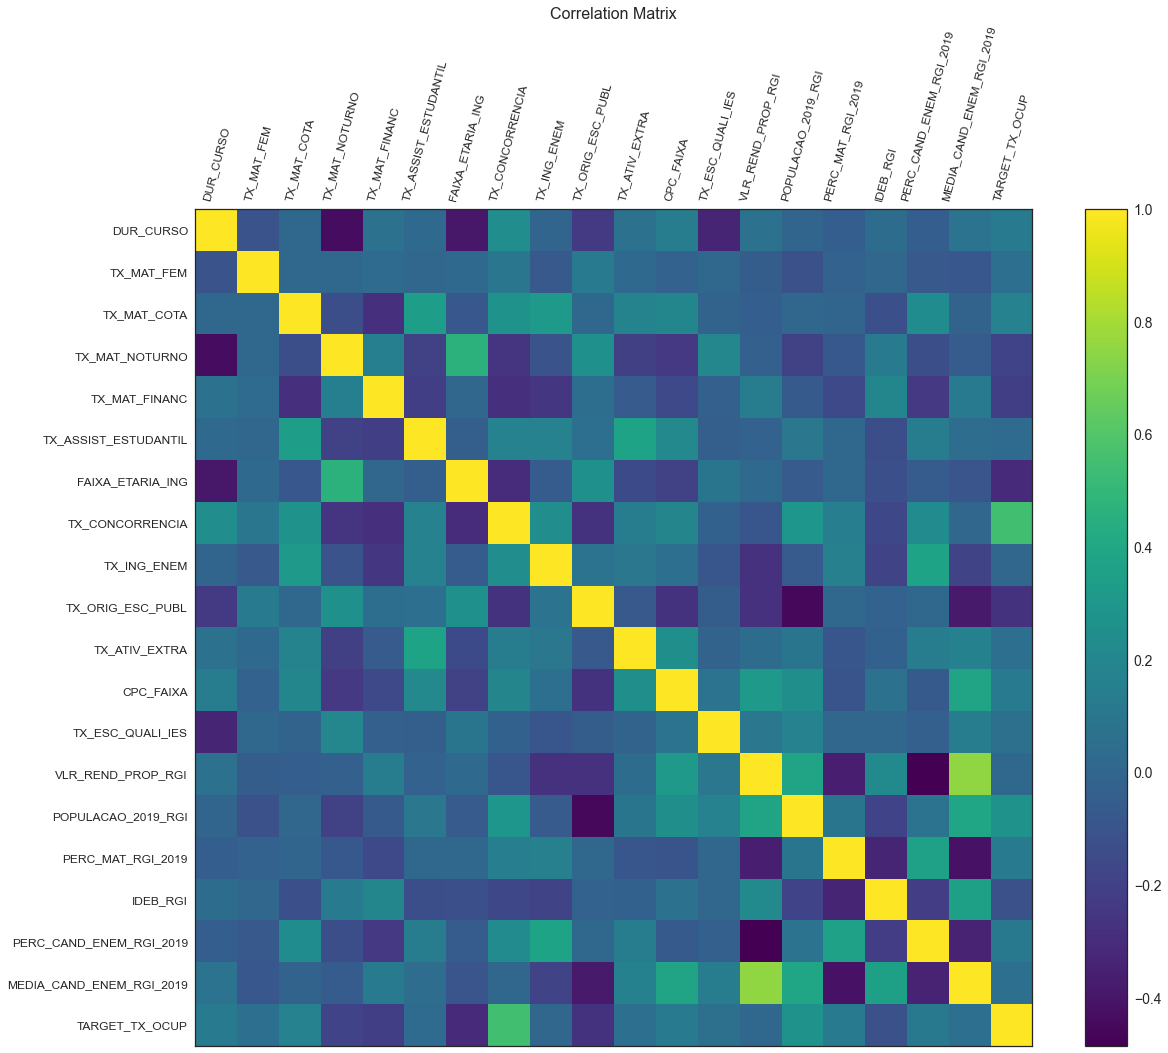

In [357]:
# Gráfico das correlações
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number, cmap='viridis')
plt.xticks(range(xyz.select_dtypes(['number']).shape[1]), xyz.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(xyz.select_dtypes(['number']).shape[1]), xyz.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);



In [358]:
df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,36]].corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(2)



In [359]:
# df_ML.iloc[:, np.r_[5:7,8,13:23,24:28,29:33]].info()
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   GRAU_ACADEMICO            4774 non-null   object 
 2   POLO                      4774 non-null   object 
 3   TX_MAT_FEM                4774 non-null   float64
 4   TX_MAT_COTA               4774 non-null   float64
 5   TX_MAT_NOTURNO            4774 non-null   float64
 6   TX_MAT_FINANC             4774 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 8   FAIXA_ETARIA_ING          4774 non-null   float64
 9   TX_CONCORRENCIA           4774 non-null   float64
 10  TX_ING_ENEM               4774 non-null   float64
 11  TX_ORIG_ESC_PUBL          4774 non-null   float64
 12  TX_ATIV_EXTRA             4774 non-null   float64
 13  CPC_FAIXA                 4774 non-null   int64  
 14  TX_ESC_

In [360]:
# atribuir os valores das variáveis independentes a 'X'
# Teste: eliminando a variável VLR_REND_PROP_RGI (por sua correlação com FAIXA_ETARIA_ING) 
# X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:27,28:33]]
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]]
# atribuir os valores da variável dependente a 'y'
y = df_ML['TARGET']
# Mostrar as dimensões de X e y
print('Dimensões de X = ', X.shape)
print('Dimensões de y = ', y.shape)

Dimensões de X =  (4774, 20)
Dimensões de y =  (4774,)


In [361]:
# Codificando com get_dummies(variáveis categóricas)
df_getdummies = pd.get_dummies(X)
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

df_getdummies

Dimensões do dataset com get_dummies:  (4774, 22)


DUR_CURSO  TX_MAT_FEM  TX_MAT_COTA  TX_MAT_NOTURNO  TX_MAT_FINANC  \
7            4.0        0.71         0.31            1.00            0.0   
8            4.0        0.83         0.36            1.00            0.0   
9            5.0        0.63         0.44            0.00            0.0   
25           4.0        0.55         0.00            1.00            0.0   
26           4.0        0.59         0.42            0.72            0.0   
...          ...         ...          ...             ...            ...   
13074        5.0        0.54         0.41            0.00            0.0   
13075        5.0        0.81         0.47            0.00            0.0   
13076        4.0        0.33         0.48            0.00            0.0   
13097        6.0        0.54         0.07            0.00            0.0   
13098        5.0        0.78         0.12            0.00            0.0   

       TX_ASSIST_ESTUDANTIL  FAIXA_ETARIA_ING  TX_CONCORRENCIA  TX_ING_ENEM  \
7                      0.25               4.1             8.15         0.00   
8                      0.18               4.1             2.16         1.00   
9                      0.46               3.2             0.94         1.00   
25                     0.38               3.9             3.29         0.00   
26                     0.25               3.7             5.18         0.89   
...                     ...               ...              ...          ...   
13074                  0.23               3.2             4.27         0.23   
13075                  0.33               3.1            11.82         0.21   
13076                  0.19               3.3             8.01         0.21   
13097                  0.00               3.3            74.04         0.92   
13098                  0.00               3.2            58.56         1.00   

       TX_ORIG_ESC_PUBL  ...  TX_ESC_QUALI_IES  PERC_MAT_RGI_2019  IDEB_RGI  \
7                  0.97  ...              0.50           4.310577      3.91   
8                  0.94  ...              0.50           4.310577      3.91   
9                  0.91  ...              0.00           4.310577      3.91   
25                 0.98  ...              0.50           5.286110      4.39   
26                 0.93  ...              0.50           5.286110      4.39   
...                 ...  ...               ...                ...       ...   
13074              0.46  ...              0.49           5.160470      4.00   
13075              0.56  ...              0.47           5.160470      4.00   
13076              0.53  ...              0.46           5.160470      4.00   
13097              0.56  ...              0.32           5.160470      4.00   
13098              0.70  ...              0.61           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  GRAU_ACADEMICO_1  \
7                         0.95                    4.9386                 0   
8                         0.95                    4.9386                 0   
9                         0.95                    4.9386                 1   
25                        1.40                    4.9947                 0   
26                        1.40                    4.9947                 1   
...                        ...                       ...               ...   
13074                     1.48                    5.3607                 1   
13075                     1.48                    5.3607                 1   
13076                     1.48                    5.3607                 1   
13097                     1.48                    5.3607                 1   
13098                     1.48                    5.3607                 1   

       POLO_S  FAIXA_POPULACAO_RGI_GD  FAIXA_POPULACAO_RGI_MD  \
7           1                       0                       0   
8           1                       0                       0   
9           1                       0                       0   

In [362]:
df_getdummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   TX_MAT_FEM                4774 non-null   float64
 2   TX_MAT_COTA               4774 non-null   float64
 3   TX_MAT_NOTURNO            4774 non-null   float64
 4   TX_MAT_FINANC             4774 non-null   float64
 5   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 6   FAIXA_ETARIA_ING          4774 non-null   float64
 7   TX_CONCORRENCIA           4774 non-null   float64
 8   TX_ING_ENEM               4774 non-null   float64
 9   TX_ORIG_ESC_PUBL          4774 non-null   float64
 10  TX_ATIV_EXTRA             4774 non-null   float64
 11  CPC_FAIXA                 4774 non-null   int64  
 12  TX_ESC_QUALI_IES          4774 non-null   float64
 13  PERC_MAT_RGI_2019         4774 non-null   float64
 14  IDEB_RG

In [363]:
# Dividir o dataset entre treino e teste (80/20), usar stratify pois as classes estão desbalanceadas
X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42,\
                                    stratify=df_getdummies[['FAIXA_POPULACAO_RGI_PQ','FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_GD']])
# X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42)

In [364]:
# Treinamento do Modelo ( utilizando o RandomForest)
reg_lin = RandomForestClassifier(n_estimators=1000,max_depth=20)
reg_lin.fit(X_train,y_train)


RandomForestClassifier(max_depth=20, n_estimators=1000)

In [365]:
# Testando o Modelo e auferindo o seu desempenho
reg_lin.score(X_test,y_test)

0.7120418848167539

In [366]:
# calculando outras métricas de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



y_pred = reg_lin.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))





Acurácia: 0.7120418848167539
Precisão: 0.6888164977074607
Recall: 0.7120418848167539
F1: 0.6890267467692576


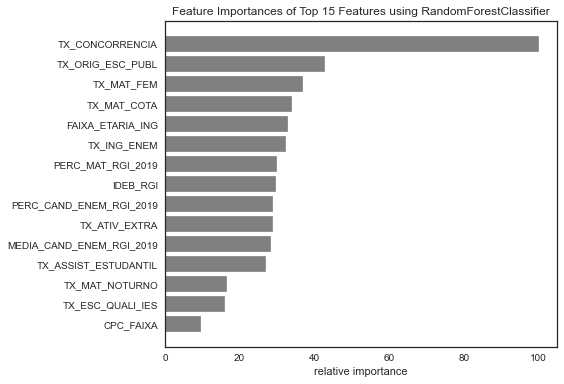

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [367]:
import yellowbrick as yb
from yellowbrick.features import FeatureImportances

viz = FeatureImportances(reg_lin, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [22]:
# Pesquisando por outros algoritmos
import lazypredict
# from sklearn.utils._testing import ignore_warnings
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators







clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)


models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


In [23]:
models

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
XGBClassifier                      0.71               0.65    None      0.70   
LGBMClassifier                     0.70               0.64    None      0.69   
ExtraTreesClassifier               0.70               0.62    None      0.68   
RandomForestClassifier             0.70               0.62    None      0.68   
BaggingClassifier                  0.67               0.60    None      0.66   
AdaBoostClassifier                 0.67               0.59    None      0.64   
DecisionTreeClassifier             0.60               0.56    None      0.60   
NuSVC                              0.64               0.56    None      0.62   
LabelPropagation                   0.60               0.55    None      0.60   
LabelSpreading                     0.60               0.55    None      0.60   
SVC                                0.64               0.54    None      0.59   
LogisticRegression                 0.63               0.53    None      0.58   
GaussianNB                         0.57               0.53    None      0.57   
NearestCentroid                    0.55               0.53    None      0.56   
KNeighborsClassifier               0.60               0.51    None      0.58   
SGDClassifier                      0.63               0.51    None      0.56   
CalibratedClassifierCV             0.62               0.51    None      0.55   
LinearSVC                          0.62               0.51    None      0.55   
QuadraticDiscriminantAnalysis      0.46               0.49    None      0.48   
BernoulliNB                        0.57               0.49    None      0.54   
ExtraTreeClassifier                0.54               0.49    None      0.54   
PassiveAggressiveClassifier        0.54               0.48    None      0.54   
LinearDiscriminantAnalysis         0.59               0.48    None      0.53   
RidgeClassifier                    0.58               0.46    None      0.50   
RidgeClassifierCV                  0.58               0.46    None      0.50   
Perceptron                         0.54               0.46    None      0.53   
DummyClassifier                    0.37               0.33    None      0.38   

                               Time Taken  
Model                                      
XGBClassifier                        0.89  
LGBMClassifier                       0.45  
ExtraTreesClassifier                 0.54  
RandomForestClassifier               0.67  
BaggingClassifier                    0.26  
AdaBoostClassifier                   0.38  
DecisionTreeClassifier               0.06  
NuSVC                                0.90  
LabelPropagation                     0.94  
LabelSpreading                       1.14  
SVC                                  0.75  
LogisticRegression                   0.08  
GaussianNB                           0.03  
NearestCentroid                      0.02  
KNeighborsClassifier                 0.20  
SGDClassifier                        0.11  
CalibratedClassifierCV               3.35  
LinearSVC                            0.80  
QuadraticDiscriminantAnalysis        0.04  
BernoulliNB                          0.03  
ExtraTreeClassifier                  0.03  
PassiveAggressiveClassifier          0.04  
LinearDiscriminantAnalysis           0.05  
RidgeClassifier                      0.05  
RidgeClassifierCV                    0.04  
Perceptron                           0.03  
DummyClassifier                      0.02

In [30]:
# Usando o XGBClassifier (otimização dos parâmteros)
# Otimizando hiperparâmetros
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
from sklearn.model_selection import GridSearchCV
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0,
#         'booster': hp.choice('booster',['gbtree','dart']),
#         'eta':hp.uniform('eta', 0.01,0.3),
#     }


# booster=['gbtree']
# eta=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
gamma=[0,1,3,5,7,9]
max_depth=[3,7,11,15,18]
reg_alpha=[40,100,160,180]
reg_lambda=[0,0.2,0.4,0.6,0.8,1]
colsample_bytree=[0.5,0.7,0.9,1]
min_child_weight=[0,2,4,6,8,10]
n_estimators=[100,180,300]


# n_estimators = [100, 300, 500, 800, 1000, 1200]
# max_depth = [5, 10, 15, 20, 25]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 4, 5, 10] 
# max_features=['auto', 'sqrt']
# bootstrap=[True, False]

hyperF = {'n_estimators': n_estimators, 'max_depth': max_depth,  
          'gamma' : gamma,
          'reg_alpha':reg_alpha,'reg_lambda':reg_lambda,
           'min_child_weight': min_child_weight, 
           'colsample_bytree':colsample_bytree}

# print(hyperF)
gridF = GridSearchCV(xgb_model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)


bestF



Fitting 3 folds for each of 51840 candidates, totalling 155520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel...
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree_method='exact', validate_parameters=1,
          

In [368]:
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]].info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   GRAU_ACADEMICO            4774 non-null   object 
 2   POLO                      4774 non-null   object 
 3   TX_MAT_FEM                4774 non-null   float64
 4   TX_MAT_COTA               4774 non-null   float64
 5   TX_MAT_NOTURNO            4774 non-null   float64
 6   TX_MAT_FINANC             4774 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 8   FAIXA_ETARIA_ING          4774 non-null   float64
 9   TX_CONCORRENCIA           4774 non-null   float64
 10  TX_ING_ENEM               4774 non-null   float64
 11  TX_ORIG_ESC_PUBL          4774 non-null   float64
 12  TX_ATIV_EXTRA             4774 non-null   float64
 13  CPC_FAIXA                 4774 non-null   int64  
 14  TX_ESC_

In [369]:
# Redefinindo as bases de treino e teste (usando população numérica 0 - 23 em milhões)
# df_ML.iloc[:, np.r_[5:7,8,13:23,24:28,29:33]].info()
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]]
df_getdummies = pd.get_dummies(X)
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42)

Dimensões do dataset com get_dummies:  (4774, 20)


In [370]:
# Usando o XGBClassifier
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
#                             colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=1,
#                              n_estimators=100,reg_alpha=0, reg_lambda=1 )

xgb_model.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [371]:

y_pred = xgb_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))




Acurácia: 0.7089005235602094
Precisão: 0.6798364692573723
Recall: 0.7089005235602094
F1: 0.6820483581173008


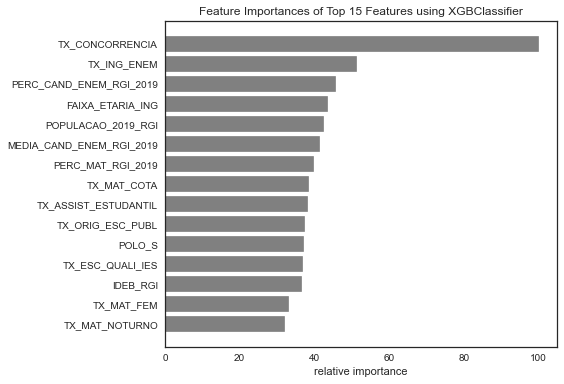

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using XGBClassifier'}, xlabel='relative importance'>

In [372]:
viz = FeatureImportances(xgb_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [373]:
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   GRAU_ACADEMICO            4774 non-null   object 
 2   POLO                      4774 non-null   object 
 3   TX_MAT_FEM                4774 non-null   float64
 4   TX_MAT_COTA               4774 non-null   float64
 5   TX_MAT_NOTURNO            4774 non-null   float64
 6   TX_MAT_FINANC             4774 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 8   FAIXA_ETARIA_ING          4774 non-null   float64
 9   TX_CONCORRENCIA           4774 non-null   float64
 10  TX_ING_ENEM               4774 non-null   float64
 11  TX_ORIG_ESC_PUBL          4774 non-null   float64
 12  TX_ATIV_EXTRA             4774 non-null   float64
 13  CPC_FAIXA                 4774 non-null   int64  
 14  TX_ESC_

In [374]:
# Redefinindo a base de dados (utilizando faixa populacional)
# atribuir os valores das variáveis independentes a 'X'
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]]

# atribuir os valores da variável dependente a 'y'
y = df_ML['TARGET']
# Mostrar as dimensões de X e y
print('Dimensões de X = ', X.shape)
print('Dimensões de y = ', y.shape)
# Codificando com get_dummies(variáveis categóricas)
df_getdummies = pd.get_dummies(X)
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42,\
                                    stratify=df_getdummies[['FAIXA_POPULACAO_RGI_PQ','FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_GD']])




Dimensões de X =  (4774, 20)
Dimensões de y =  (4774,)
Dimensões do dataset com get_dummies:  (4774, 22)


In [375]:
# usando o LGBMClassifier
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(objective='multiclass', random_state=42)

lgbm_model.fit(X_train, y_train)


LGBMClassifier(objective='multiclass', random_state=42)

In [376]:
y_pred = lgbm_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))



Acurácia: 0.7015706806282722
Precisão: 0.6805147784843277
Recall: 0.7015706806282722
F1: 0.6860379092833045


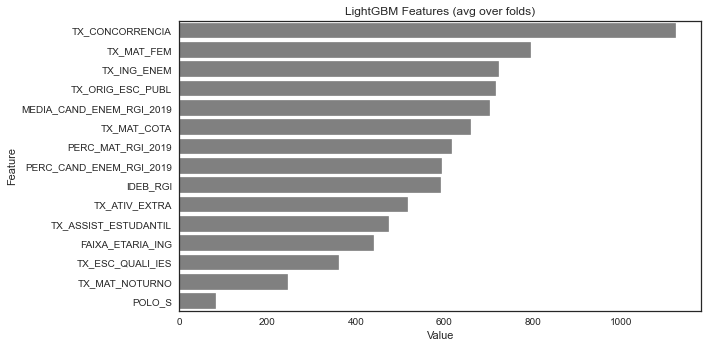

In [377]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:15],color='gray')
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

In [378]:
# Usando o ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
xtrees_model = ExtraTreesClassifier(n_estimators=100, random_state=0)
xtrees_model.fit(X_train, y_train)



ExtraTreesClassifier(random_state=0)

In [379]:
y_pred = xtrees_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))


Acurácia: 0.6858638743455497
Precisão: 0.6634752216640957
Recall: 0.6858638743455497
F1: 0.6661434484437788


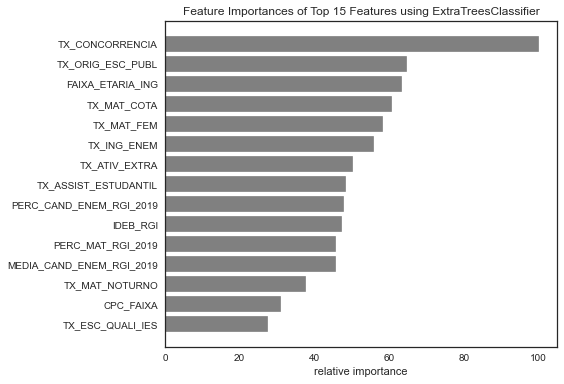

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [381]:
viz = FeatureImportances(xtrees_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

##      2.1.1.2) IES Privadas

In [403]:
df_ML= df_cursos_presenciais[(df_cursos_presenciais['TP_REDE']=='2')& (df_cursos_presenciais['GRAU_ACADEMICO'].isin(['1','2'])) ]
df_ML

COD_MUN COD_RGI COD_IES  CD_CURSO         CURSO  DUR_CURSO  \
0      1100023  110002    1540   0421D01       Direito        5.0   
1      1100023  110002    1540   0916F01      Farmácia        5.0   
2      1100023  110002    1540  9,13E+03    Enfermagem        5.0   
3      1100023  110002    4613   0313P01    Psicologia        5.0   
4      1100023  110002    4613   0915F01  Fisioterapia        5.0   
...        ...     ...     ...       ...           ...        ...   
13185  5300108  530001    5439   0912M01      Medicina        6.0   
13186  5300108  530001    5439   0915F01  Fisioterapia        5.0   
13187  5300108  530001    5439   0915N01      Nutrição        4.0   
13188  5300108  530001    5439   0916F01      Farmácia        5.0   
13190  5300108  530001    5439  9,13E+03    Enfermagem        5.0   

      GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  POPULACAO_2019_RGI  \
0                  1       2    S             105  ...                0.23   
1                  1       2    S              50  ...                0.23   
2                  1       2    S              50  ...                0.23   
3                  1       2    S             426  ...                0.23   
4                  1       2    S             389  ...                0.23   
...              ...     ...  ...             ...  ...                 ...   
13185              1       2    S             140  ...                3.02   
13186              1       2    S             130  ...                3.02   
13187              1       2    S             312  ...                3.02   
13188              1       2    S             131  ...                3.02   
13190              1       2    S             227  ...                3.02   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
0                       PQ           4.310577      3.91   
1                       PQ           4.310577      3.91   
2                       PQ           4.310577      3.91   
3                       PQ           4.310577      3.91   
4                       PQ           4.310577      3.91   
...                    ...                ...       ...   
13185                   GD           5.160470      4.00   
13186                   GD           5.160470      4.00   
13187                   GD           5.160470      4.00   
13188                   GD           5.160470      4.00   
13190                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
0                         0.95                    4.9386                0.80   
1                         0.95                    4.9386                0.72   
2                         0.95                    4.9386                0.88   
3                         0.95                    4.9386                0.08   
4                         0.95                    4.9386                0.09   
...                        ...                       ...                 ...   
13185                     1.48                    5.3607                1.46   
13186                     1.48                    5.3607                0.78   
13187                     1.48                    5.3607                0.49   
13188                     1.48                    5.3607                0.53   
13190                     1.48                    5.3607                0.70   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP  
0                      0.76                0.95            0.84  
1                      0.60                0.83            0.57  
2                      0.32                0.36            0.51  
3                      0.04                0.52            0.06  
4                      0.07                0.72            0.08  
...                     ...                 ...             ...  
13185                  0.69                0.47            1.00  
13186                  0.29                

In [404]:
# Verificando a distribuição dos valores para o Target
df_ML['TARGET_TX_OCUP'].describe()

count    7411.000000
mean        0.392950
std         0.223822
min         0.020000
25%         0.250000
50%         0.350000
75%         0.500000
max         2.350000
Name: TARGET_TX_OCUP, dtype: float64

In [405]:
# Definindo Target por faixas de desempenho: Ruim, Razoável. Bom e Excelente
# (Faixas definidas de acordo com os quartis)
# df_ML["TARGET"] = ["Ruim" if x <= 0.39 else ("Razoável" if (x > 0.39 and x <= 0.65) \
#                                               else (("Bom" if (x > 0.65 and x <= 1.04) \
#                                                      else "Excelente")\
#                                                    )\
#                                             ) for x in (df_ML['TARGET_TX_CONC_ING'])] 
df_ML["TARGET"] = ["Ruim" if x <= 0.5 else ("Razoável" if ((x > 0.5 and x <=0.7))\
                                             else "Bom") for x in (df_ML['TARGET_TX_OCUP'])] 



df_ML


COD_MUN COD_RGI COD_IES  CD_CURSO         CURSO  DUR_CURSO  \
0      1100023  110002    1540   0421D01       Direito        5.0   
1      1100023  110002    1540   0916F01      Farmácia        5.0   
2      1100023  110002    1540  9,13E+03    Enfermagem        5.0   
3      1100023  110002    4613   0313P01    Psicologia        5.0   
4      1100023  110002    4613   0915F01  Fisioterapia        5.0   
...        ...     ...     ...       ...           ...        ...   
13185  5300108  530001    5439   0912M01      Medicina        6.0   
13186  5300108  530001    5439   0915F01  Fisioterapia        5.0   
13187  5300108  530001    5439   0915N01      Nutrição        4.0   
13188  5300108  530001    5439   0916F01      Farmácia        5.0   
13190  5300108  530001    5439  9,13E+03    Enfermagem        5.0   

      GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  FAIXA_POPULACAO_RGI  \
0                  1       2    S             105  ...                   PQ   
1                  1       2    S              50  ...                   PQ   
2                  1       2    S              50  ...                   PQ   
3                  1       2    S             426  ...                   PQ   
4                  1       2    S             389  ...                   PQ   
...              ...     ...  ...             ...  ...                  ...   
13185              1       2    S             140  ...                   GD   
13186              1       2    S             130  ...                   GD   
13187              1       2    S             312  ...                   GD   
13188              1       2    S             131  ...                   GD   
13190              1       2    S             227  ...                   GD   

       PERC_MAT_RGI_2019  IDEB_RGI  PERC_CAND_ENEM_RGI_2019  \
0               4.310577      3.91                     0.95   
1               4.310577      3.91                     0.95   
2               4.310577      3.91                     0.95   
3               4.310577      3.91                     0.95   
4               4.310577      3.91                     0.95   
...                  ...       ...                      ...   
13185           5.160470      4.00                     1.48   
13186           5.160470      4.00                     1.48   
13187           5.160470      4.00                     1.48   
13188           5.160470      4.00                     1.48   
13190           5.160470      4.00                     1.48   

       MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  TARGET_TX_CONC_VAGAS  \
0                        4.9386                0.80                  0.76   
1                        4.9386                0.72                  0.60   
2                        4.9386                0.88                  0.32   
3                        4.9386                0.08                  0.04   
4                        4.9386                0.09                  0.07   
...                         ...                 ...                   ...   
13185                    5.3607                1.46                  0.69   
13186                    5.3607                0.78                  0.29   
13187                    5.3607                0.49                  0.30   
13188                    5.3607                0.53                  0.29   
13190                    5.3607                0.70                  0.56   

       TARGET_TX_CONC_ING  TARGET_TX_OCUP    TARGET  
0                    0.95            0.84       Bom  
1                    0.83            0.57  Razoável  
2                    0.36            0.51  Razoável  
3                    0.52            0.06      Ruim  
4                    0.72            0.08      Ruim  
...                   ...             ...       ...  
13185                0.47            1.00       Bom  
13186                0.37            0.47      Ruim  
13187                0.60            0.33      Ruim  
13188  

In [406]:
# Analisando correlações entre as variáveis independentes e destas com o target (correlação de Sperman)
xyz = df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,36]]
# xyz = df_ML.iloc[:, np.r_[5,13:23,24:27,28:32,35]]
corr_matrix, p_matrix = scipy.stats.spearmanr(xyz, axis=0)
pd.DataFrame(corr_matrix,columns=xyz.columns,index=xyz.columns).style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

In [385]:
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7411 entries, 0 to 13190
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 7411 non-null   float64
 1   GRAU_ACADEMICO            7411 non-null   object 
 2   POLO                      7411 non-null   object 
 3   TX_MAT_FEM                7411 non-null   float64
 4   TX_MAT_COTA               7411 non-null   float64
 5   TX_MAT_NOTURNO            7411 non-null   float64
 6   TX_MAT_FINANC             7411 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      7411 non-null   float64
 8   FAIXA_ETARIA_ING          7411 non-null   float64
 9   TX_CONCORRENCIA           7411 non-null   float64
 10  TX_ING_ENEM               7411 non-null   float64
 11  TX_ORIG_ESC_PUBL          7411 non-null   float64
 12  TX_ATIV_EXTRA             7411 non-null   float64
 13  CPC_FAIXA                 7411 non-null   int64  
 14  TX_ESC_

In [386]:
# atribuir os valores das variáveis independentes a 'X'
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]]
# atribuir os valores da variável dependente a 'y'
y = df_ML['TARGET']
# Mostrar as dimensões de X e y
print('Dimensões de X = ', X.shape)
print('Dimensões de y = ', y.shape)

Dimensões de X =  (7411, 20)
Dimensões de y =  (7411,)


In [387]:
# Codificando com get_dummies(variáveis categóricas)
df_getdummies = pd.get_dummies(X)
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies.drop(columns=['POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

df_getdummies

Dimensões do dataset com get_dummies:  (7411, 23)


DUR_CURSO  TX_MAT_FEM  TX_MAT_COTA  TX_MAT_NOTURNO  TX_MAT_FINANC  \
0            5.0        0.55          0.0            1.00           0.25   
1            5.0        0.71          0.0            1.00           0.57   
2            5.0        0.90          0.0            1.00           0.82   
3            5.0        0.92          0.0            1.00           0.46   
4            5.0        0.82          0.0            1.00           0.52   
...          ...         ...          ...             ...            ...   
13185        6.0        0.61          0.0            0.00           0.00   
13186        5.0        0.74          0.0            0.86           0.00   
13187        4.0        0.74          0.0            0.62           0.00   
13188        5.0        0.63          0.0            1.00           0.00   
13190        5.0        0.84          0.0            0.56           0.00   

       TX_ASSIST_ESTUDANTIL  FAIXA_ETARIA_ING  TX_CONCORRENCIA  TX_ING_ENEM  \
0                      0.00               3.7             2.40         0.00   
1                      0.04               3.9             0.90         0.00   
2                      0.01               3.9             1.40         0.00   
3                      0.37               3.8             0.09         0.24   
4                      0.28               3.4             0.10         0.22   
...                     ...               ...              ...          ...   
13185                  0.00               3.2             7.39         0.89   
13186                  0.00               3.4             2.12         0.82   
13187                  0.00               3.7             1.04         0.52   
13188                  0.00               3.5             1.01         0.84   
13190                  0.00               3.3             1.32         0.84   

       TX_ORIG_ESC_PUBL  ...  PERC_MAT_RGI_2019  IDEB_RGI  \
0                  0.84  ...           4.310577      3.91   
1                  0.94  ...           4.310577      3.91   
2                  0.99  ...           4.310577      3.91   
3                  0.91  ...           4.310577      3.91   
4                  0.96  ...           4.310577      3.91   
...                 ...  ...                ...       ...   
13185              0.16  ...           5.160470      4.00   
13186              0.71  ...           5.160470      4.00   
13187              0.65  ...           5.160470      4.00   
13188              0.73  ...           5.160470      4.00   
13190              0.69  ...           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  GRAU_ACADEMICO_1  \
0                         0.95                    4.9386                 1   
1                         0.95                    4.9386                 1   
2                         0.95                    4.9386                 1   
3                         0.95                    4.9386                 1   
4                         0.95                    4.9386                 1   
...                        ...                       ...               ...   
13185                     1.48                    5.3607                 1   
13186                     1.48                    5.3607                 1   
13187                     1.48                    5.3607                 1   
13188                     1.48                    5.3607                 1   
13190                     1.48                    5.3607                 1   

       GRAU_ACADEMICO_2  POLO_S  FAIXA_POPULACAO_RGI_GD  \
0                     0       1                       0   
1                     0       1                       0   
2                     0       1                       0   
3                     0       1                       0   
4                     0       1                       0   
...                 ...     ...                     ...   
13185                 0       1                       1   
131

In [388]:
# Dividir o dataset entre treino e teste (80/20), usar stratify pois as classes estão desbalanceadas
X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.2, random_state = 42,\
                                    stratify=df_getdummies[['FAIXA_POPULACAO_RGI_PQ','FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_GD']])

In [389]:
# Treinamento do Modelo ( utilizando o RandomForest)
reg_lin = RandomForestClassifier(n_estimators=1000,max_depth=10)
reg_lin.fit(X_train,y_train)


RandomForestClassifier(max_depth=10, n_estimators=1000)

In [390]:
# Testando o Modelo e auferindo o seu desempenho
reg_lin.score(X_test,y_test)

0.7842211732973702

In [391]:

y_pred = reg_lin.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))



Acurácia: 0.7842211732973702
Precisão: 0.7052037570581063
Recall: 0.7842211732973702
F1: 0.7056486888970341


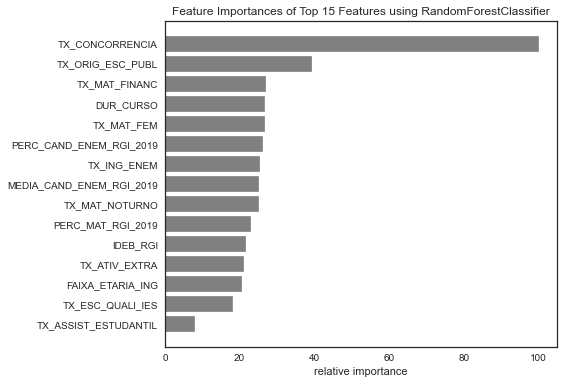

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [392]:
import yellowbrick as yb
from yellowbrick.features import FeatureImportances


viz = FeatureImportances(reg_lin, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [393]:
# usando o LGBMClassifier
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(objective='multiclass', random_state=42)

lgbm_model.fit(X_train, y_train)


LGBMClassifier(objective='multiclass', random_state=42)

In [394]:
y_pred = lgbm_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.7909642616318274
Precisão: 0.7378196222378581
Recall: 0.7909642616318274
F1: 0.7458214451874317


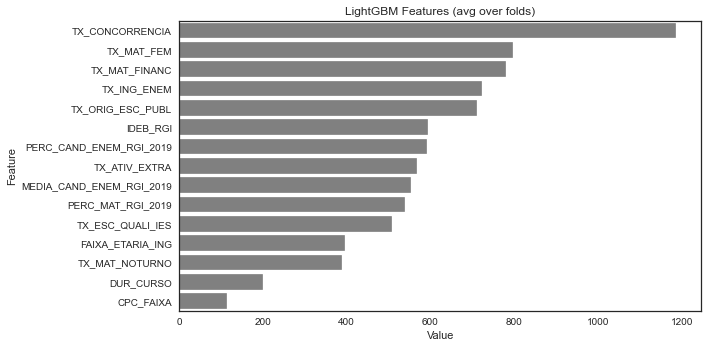

In [395]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:15], color='gray')
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [396]:
# Usando o ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
xtrees_model = ExtraTreesClassifier(n_estimators=100, random_state=0)
xtrees_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [397]:
y_pred = xtrees_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.7896156439649359
Precisão: 0.7423266700909948
Recall: 0.7896156439649359
F1: 0.7415876927242646


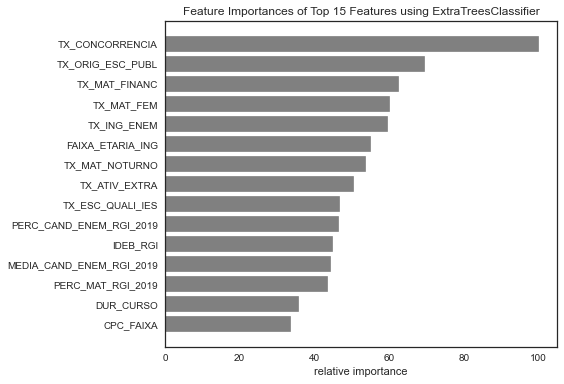

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [398]:
viz = FeatureImportances(xtrees_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [399]:
# Redefinindo as bases de treino e teste (usando população numérica 0 - 23 em milhões)
# df_ML.iloc[:, np.r_[5:7,8,13:23,24:28,29:33]].info()
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]]
df_getdummies = pd.get_dummies(X)
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42)

Dimensões do dataset com get_dummies:  (7411, 20)


In [400]:
# Usando o XGBClassifier
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
#                             colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=1,
#                              n_estimators=100,reg_alpha=0, reg_lambda=1 )

xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [401]:
y_pred = xgb_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))


Acurácia: 0.7828725556304788
Precisão: 0.743495960167293
Recall: 0.7828725556304788
F1: 0.7518192666555675


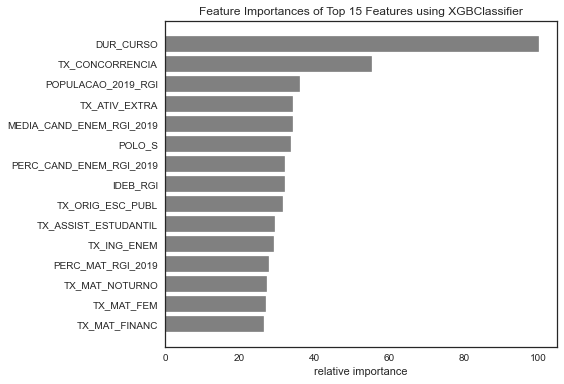

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using XGBClassifier'}, xlabel='relative importance'>

In [402]:
viz = FeatureImportances(xgb_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

## 2.1.2) Análise para TARGET: Taxa de Conclusão: Concluintes / Qt Vagas anuais

##      2.1.2.1) IES Públicas (cursos de bacharelado e licenciatura)

In [282]:
# Filtro para cursos ofertados pela rede pública no grau de bacharelado ou licenciatura
df_ML= df_cursos_presenciais[(df_cursos_presenciais['TP_REDE']=='1')& (df_cursos_presenciais['GRAU_ACADEMICO'].isin(['1','2'])) ]
df_ML

COD_MUN COD_RGI COD_IES  CD_CURSO                             CURSO  \
7      1100023  110002    4785   0114B01    Biologia formação de professor   
8      1100023  110002     699   0113P01                         Pedagogia   
9      1100023  110002     699  7,21E+03           Engenharia de alimentos   
25     1100049  110005    4785   0114M01  Matemática formação de professor   
26     1100049  110005     699   0411C01                     Contabilidade   
...        ...     ...     ...       ...                               ...   
13074  5300108  530001       2  8,21E+03              Engenharia florestal   
13075  5300108  530001       2  9,13E+03                        Enfermagem   
13076  5300108  530001       2  9,15E+03                   Educação física   
13097  5300108  530001    3223   0912M01                          Medicina   
13098  5300108  530001    3223  9,13E+03                        Enfermagem   

       DUR_CURSO GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  \
7            4.0              2       1    S              40  ...   
8            4.0              2       1    S              50  ...   
9            5.0              1       1    S              70  ...   
25           4.0              2       1    S              49  ...   
26           4.0              1       1    S              56  ...   
...          ...            ...     ...  ...             ...  ...   
13074        5.0              1       1    S             119  ...   
13075        5.0              1       1    S             217  ...   
13076        4.0              1       1    S             116  ...   
13097        6.0              1       1    S              80  ...   
13098        5.0              1       1    S              80  ...   

       POPULACAO_2019_RGI  FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
7                    0.23                   PQ           4.310577      3.91   
8                    0.23                   PQ           4.310577      3.91   
9                    0.23                   PQ           4.310577      3.91   
25                   0.31                   MD           5.286110      4.39   
26                   0.31                   MD           5.286110      4.39   
...                   ...                  ...                ...       ...   
13074                3.02                   GD           5.160470      4.00   
13075                3.02                   GD           5.160470      4.00   
13076                3.02                   GD           5.160470      4.00   
13097                3.02                   GD           5.160470      4.00   
13098                3.02                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
7                         0.95                    4.9386                0.95   
8                         0.95                    4.9386                0.96   
9                         0.95                    4.9386                0.30   
25                        1.40                    4.9947                0.90   
26                        1.40                    4.9947                0.96   
...                        ...                       ...                 ...   
13074                     1.48                    5.3607                0.93   
13075                     1.48                    5.3607                0.97   
13076                     1.48                    5.3607                0.97   
13097                     1.48                    5.3607                1.10   
13098                     1.48                    5.3607                1.02   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP  
7                      0.38                0.39            0.98  
8                      0.44                0.46            0.90  
9                      0.14                0.48            0.15  
25                     0.08                0.09            0.49  
2

In [283]:
# Verificando a distribuição dos valores para o Target
df_ML['TARGET_TX_CONC_VAGAS'].describe()

count    4774.000000
mean        0.396894
std         0.263874
min         0.010000
25%         0.190000
50%         0.350000
75%         0.550000
max         3.310000
Name: TARGET_TX_CONC_VAGAS, dtype: float64

In [284]:
# Definindo Target por faixas de desempenho: Ruim, Razoável. Bom e Excelente
# (Faixas definidas de acordo com os quartis)
# df_ML["TARGET"] = ["Ruim" if x <= 0.29 else ("Razoável" if (x > 0.29 and x <=0.46) \
#                                               else (("Bom" if (x > 0.46 and x <= 0.67) \
#                                                      else "Excelente")\
#                                                    )\
#                                             ) for x in (df_ML['TARGET_TX_CONC_ING'])] 
df_ML["TARGET"] = ["Ruim" if x <= 0.3 else ("Razoável" if ((x > 0.3 and x <=0.6))\
                                             else "Bom") for x in (df_ML['TARGET_TX_CONC_VAGAS'])] 





df_ML


COD_MUN COD_RGI COD_IES  CD_CURSO                             CURSO  \
7      1100023  110002    4785   0114B01    Biologia formação de professor   
8      1100023  110002     699   0113P01                         Pedagogia   
9      1100023  110002     699  7,21E+03           Engenharia de alimentos   
25     1100049  110005    4785   0114M01  Matemática formação de professor   
26     1100049  110005     699   0411C01                     Contabilidade   
...        ...     ...     ...       ...                               ...   
13074  5300108  530001       2  8,21E+03              Engenharia florestal   
13075  5300108  530001       2  9,13E+03                        Enfermagem   
13076  5300108  530001       2  9,15E+03                   Educação física   
13097  5300108  530001    3223   0912M01                          Medicina   
13098  5300108  530001    3223  9,13E+03                        Enfermagem   

       DUR_CURSO GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  \
7            4.0              2       1    S              40  ...   
8            4.0              2       1    S              50  ...   
9            5.0              1       1    S              70  ...   
25           4.0              2       1    S              49  ...   
26           4.0              1       1    S              56  ...   
...          ...            ...     ...  ...             ...  ...   
13074        5.0              1       1    S             119  ...   
13075        5.0              1       1    S             217  ...   
13076        4.0              1       1    S             116  ...   
13097        6.0              1       1    S              80  ...   
13098        5.0              1       1    S              80  ...   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
7                       PQ           4.310577      3.91   
8                       PQ           4.310577      3.91   
9                       PQ           4.310577      3.91   
25                      MD           5.286110      4.39   
26                      MD           5.286110      4.39   
...                    ...                ...       ...   
13074                   GD           5.160470      4.00   
13075                   GD           5.160470      4.00   
13076                   GD           5.160470      4.00   
13097                   GD           5.160470      4.00   
13098                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
7                         0.95                    4.9386                0.95   
8                         0.95                    4.9386                0.96   
9                         0.95                    4.9386                0.30   
25                        1.40                    4.9947                0.90   
26                        1.40                    4.9947                0.96   
...                        ...                       ...                 ...   
13074                     1.48                    5.3607                0.93   
13075                     1.48                    5.3607                0.97   
13076                     1.48                    5.3607                0.97   
13097                     1.48                    5.3607                1.10   
13098                     1.48                    5.3607                1.02   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP    TARGET  
7                      0.38                0.39            0.98  Razoável  
8                      0.44                0.46            0.90  Razoável  
9                      0.14                0.48            0.15      Ruim  
25                     0.08                0.09            0.49      Ruim  
26                     0.50                0.52            1.12  Razoável  
...                     ...                 ...             ...       ...  
13074                  0.32            

In [285]:
# Analisando correlações entre as variáveis independentes e destas com o target (correlação de Sperman)
xyz = df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,34]]
# xyz = df_ML.iloc[:, np.r_[5,13:23,24:27,28:32,35]]
corr_matrix, p_matrix = scipy.stats.spearmanr(xyz, axis=0)
pd.DataFrame(corr_matrix,columns=xyz.columns,index=xyz.columns).style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

<Figure size 1800x1440 with 0 Axes>

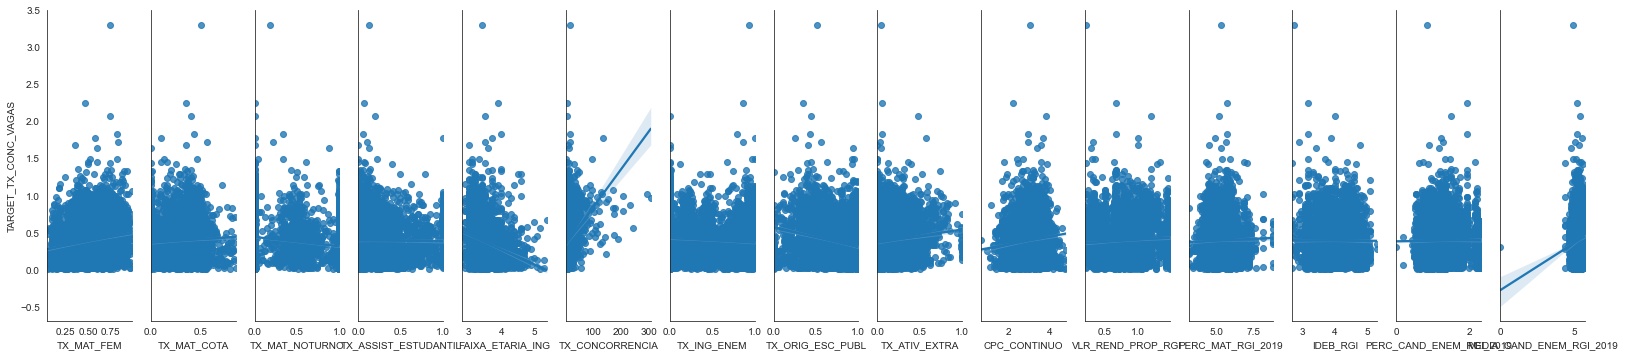

In [8]:
# Apresentar gráfico mostrando as relações entre as variáveis independentes numéricas e a dependente (desempenho cursos).

sns.set_style("white")
plt.figure(figsize=(25,20))

sns.pairplot(df_ML, x_vars=['TX_MAT_FEM','TX_MAT_COTA','TX_MAT_NOTURNO','TX_ASSIST_ESTUDANTIL','FAIXA_ETARIA_ING',
                                  'TX_CONCORRENCIA','TX_ING_ENEM','TX_ORIG_ESC_PUBL','TX_ATIV_EXTRA',
                                  'CPC_CONTINUO','VLR_REND_PROP_RGI','PERC_MAT_RGI_2019','IDEB_RGI',
                                  'PERC_CAND_ENEM_RGI_2019','MEDIA_CAND_ENEM_RGI_2019'], y_vars='TARGET_TX_CONC_VAGAS',
height=5, aspect=0.3, kind='reg');


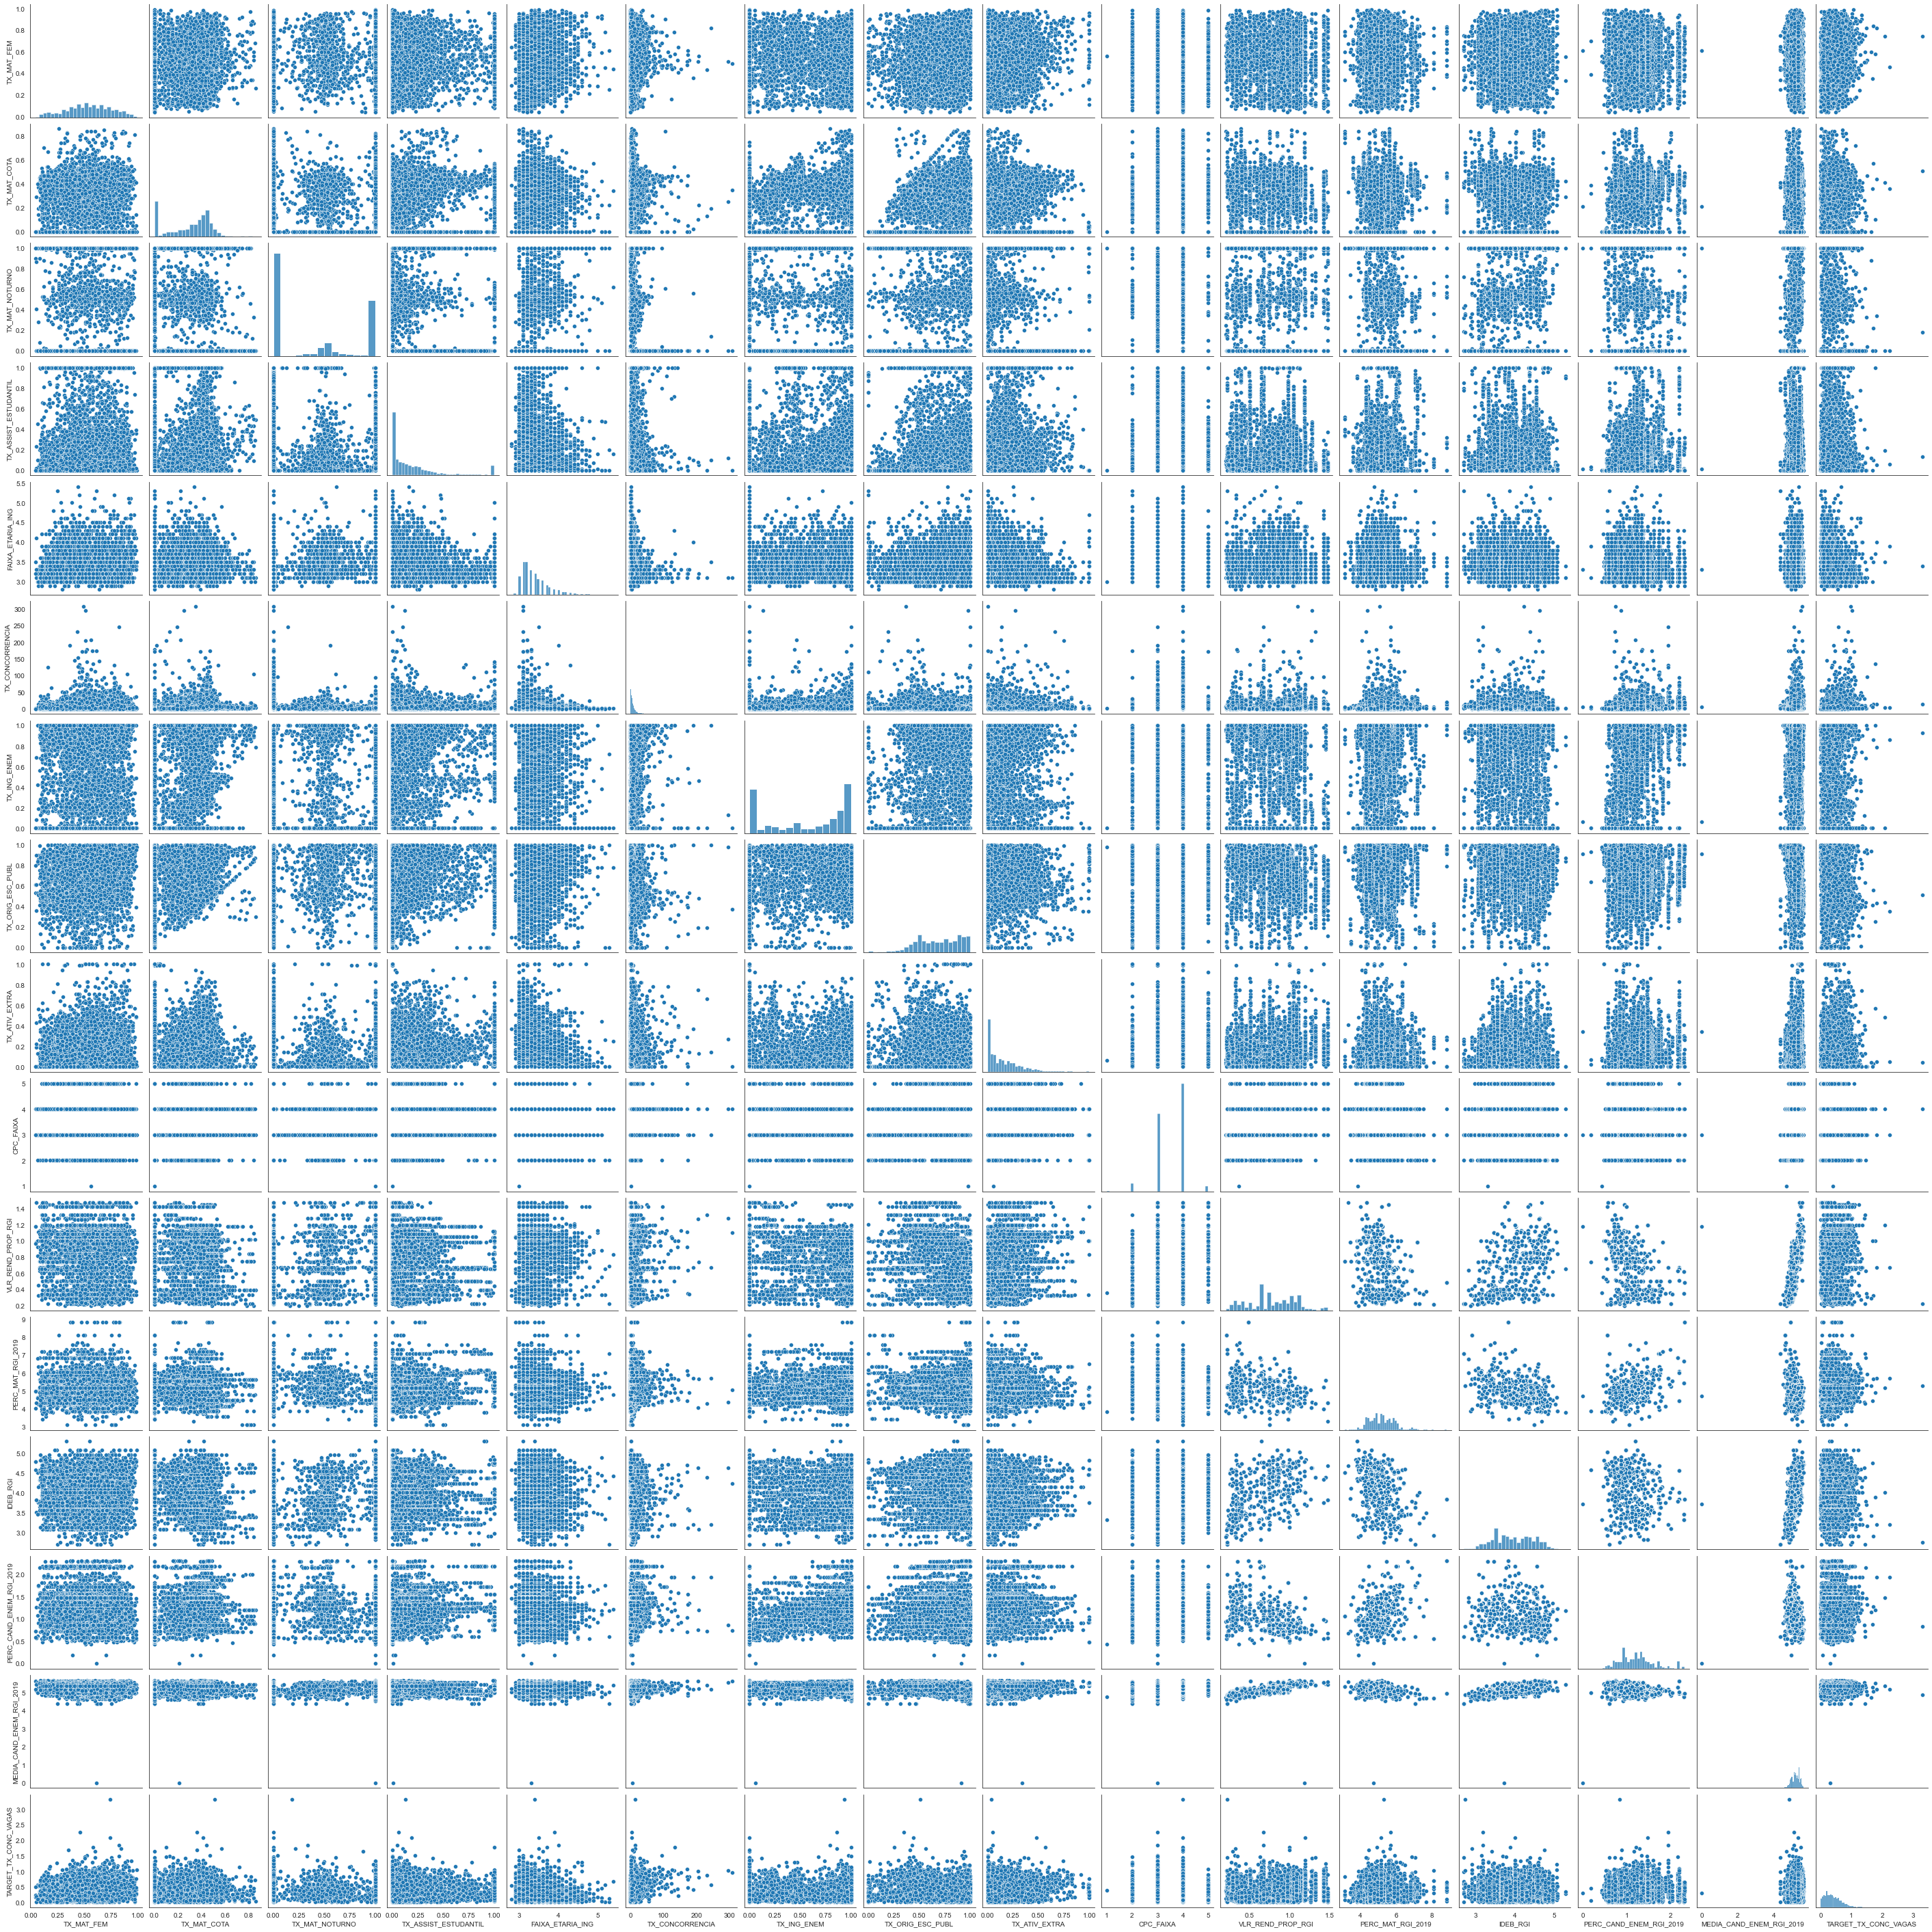

In [9]:
# Pesquisando por correlações entre as variáves (incluindo o Target)
sns.pairplot(df_ML.loc[:, ['TX_MAT_FEM','TX_MAT_COTA','TX_MAT_NOTURNO','TX_ASSIST_ESTUDANTIL','FAIXA_ETARIA_ING',
                                 'TX_CONCORRENCIA','TX_ING_ENEM','TX_ORIG_ESC_PUBL','TX_ATIV_EXTRA','CPC_FAIXA','VLR_REND_PROP_RGI',
                                 'FAIXA_POPULACAO_RGI','PERC_MAT_RGI_2019','IDEB_RGI','PERC_CAND_ENEM_RGI_2019',
                                 'MEDIA_CAND_ENEM_RGI_2019','TARGET_TX_CONC_VAGAS']])



In [286]:
# df_ML.iloc[:, np.r_[5,7,12:15,16:22,23:30]].info()
# df_ML.iloc[:, np.r_[5:7,8,13:16,18:20,21:23,24:28,30]].info()
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   GRAU_ACADEMICO            4774 non-null   object 
 2   POLO                      4774 non-null   object 
 3   TX_MAT_FEM                4774 non-null   float64
 4   TX_MAT_COTA               4774 non-null   float64
 5   TX_MAT_NOTURNO            4774 non-null   float64
 6   TX_MAT_FINANC             4774 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 8   FAIXA_ETARIA_ING          4774 non-null   float64
 9   TX_CONCORRENCIA           4774 non-null   float64
 10  TX_ING_ENEM               4774 non-null   float64
 11  TX_ORIG_ESC_PUBL          4774 non-null   float64
 12  TX_ATIV_EXTRA             4774 non-null   float64
 13  CPC_FAIXA                 4774 non-null   int64  
 14  TX_ESC_

In [287]:
# atribuir os valores das variáveis independentes a 'X'
# X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:32]]
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]]
# atribuir os valores da variável dependente a 'y'
y = df_ML['TARGET']
# Mostrar as dimensões de X e y
print('Dimensões de X = ', X.shape)
print('Dimensões de y = ', y.shape)

Dimensões de X =  (4774, 20)
Dimensões de y =  (4774,)


In [288]:
# Codificando com get_dummies(variáveis categóricas)
df_getdummies = pd.get_dummies(X)
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','TP_REDE','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

df_getdummies

Dimensões do dataset com get_dummies:  (4774, 22)


DUR_CURSO  TX_MAT_FEM  TX_MAT_COTA  TX_MAT_NOTURNO  TX_MAT_FINANC  \
7            4.0        0.71         0.31            1.00            0.0   
8            4.0        0.83         0.36            1.00            0.0   
9            5.0        0.63         0.44            0.00            0.0   
25           4.0        0.55         0.00            1.00            0.0   
26           4.0        0.59         0.42            0.72            0.0   
...          ...         ...          ...             ...            ...   
13074        5.0        0.54         0.41            0.00            0.0   
13075        5.0        0.81         0.47            0.00            0.0   
13076        4.0        0.33         0.48            0.00            0.0   
13097        6.0        0.54         0.07            0.00            0.0   
13098        5.0        0.78         0.12            0.00            0.0   

       TX_ASSIST_ESTUDANTIL  FAIXA_ETARIA_ING  TX_CONCORRENCIA  TX_ING_ENEM  \
7                      0.25               4.1             8.15         0.00   
8                      0.18               4.1             2.16         1.00   
9                      0.46               3.2             0.94         1.00   
25                     0.38               3.9             3.29         0.00   
26                     0.25               3.7             5.18         0.89   
...                     ...               ...              ...          ...   
13074                  0.23               3.2             4.27         0.23   
13075                  0.33               3.1            11.82         0.21   
13076                  0.19               3.3             8.01         0.21   
13097                  0.00               3.3            74.04         0.92   
13098                  0.00               3.2            58.56         1.00   

       TX_ORIG_ESC_PUBL  ...  TX_ESC_QUALI_IES  PERC_MAT_RGI_2019  IDEB_RGI  \
7                  0.97  ...              0.50           4.310577      3.91   
8                  0.94  ...              0.50           4.310577      3.91   
9                  0.91  ...              0.00           4.310577      3.91   
25                 0.98  ...              0.50           5.286110      4.39   
26                 0.93  ...              0.50           5.286110      4.39   
...                 ...  ...               ...                ...       ...   
13074              0.46  ...              0.49           5.160470      4.00   
13075              0.56  ...              0.47           5.160470      4.00   
13076              0.53  ...              0.46           5.160470      4.00   
13097              0.56  ...              0.32           5.160470      4.00   
13098              0.70  ...              0.61           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  GRAU_ACADEMICO_1  \
7                         0.95                    4.9386                 0   
8                         0.95                    4.9386                 0   
9                         0.95                    4.9386                 1   
25                        1.40                    4.9947                 0   
26                        1.40                    4.9947                 1   
...                        ...                       ...               ...   
13074                     1.48                    5.3607                 1   
13075                     1.48                    5.3607                 1   
13076                     1.48                    5.3607                 1   
13097                     1.48                    5.3607                 1   
13098                     1.48                    5.3607                 1   

       POLO_S  FAIXA_POPULACAO_RGI_GD  FAIXA_POPULACAO_RGI_MD  \
7           1                       0                       0   
8           1                       0                       0   
9           1                       0                       0   

In [289]:
df_getdummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   TX_MAT_FEM                4774 non-null   float64
 2   TX_MAT_COTA               4774 non-null   float64
 3   TX_MAT_NOTURNO            4774 non-null   float64
 4   TX_MAT_FINANC             4774 non-null   float64
 5   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 6   FAIXA_ETARIA_ING          4774 non-null   float64
 7   TX_CONCORRENCIA           4774 non-null   float64
 8   TX_ING_ENEM               4774 non-null   float64
 9   TX_ORIG_ESC_PUBL          4774 non-null   float64
 10  TX_ATIV_EXTRA             4774 non-null   float64
 11  CPC_FAIXA                 4774 non-null   int64  
 12  TX_ESC_QUALI_IES          4774 non-null   float64
 13  PERC_MAT_RGI_2019         4774 non-null   float64
 14  IDEB_RG

In [290]:
# Dividir o dataset entre treino e teste (80/20), usar stratify pois as classes estão desbalanceadas
# X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42,\
#                                     stratify=df_getdummies[['GRAU_ACADEMICO_1','FAIXA_POPULACAO_RGI_GD',
#                                                             'FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_PQ']])
X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42,\
                                    stratify=df_getdummies[['FAIXA_POPULACAO_RGI_PQ','FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_GD']])

In [291]:
# Treinamento do Modelo ( utilizando o RandomForest)
reg_lin = RandomForestClassifier(n_estimators=1000,max_depth=20)
reg_lin.fit(X_train,y_train)


RandomForestClassifier(max_depth=20, n_estimators=1000)

In [292]:
# Testando o Modelo e auferindo o seu desempenho
reg_lin.score(X_test,y_test)

0.6136125654450262

In [293]:
# calculando outras métricas de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



y_pred = reg_lin.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.6136125654450262
Precisão: 0.60917121544263
Recall: 0.6136125654450262
F1: 0.6062814203558796


In [16]:
# Otimizando hiperparâmetros
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
from sklearn.model_selection import GridSearchCV



n_estimators = [100, 300, 500, 800, 1000, 1200]
max_depth = [5, 10, 15, 20, 25]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 4, 5, 10] 
max_features=['auto', 'sqrt']
bootstrap=[True, False]

hyperF = {'n_estimators': n_estimators, 'max_depth': max_depth,  
           'min_samples_split': min_samples_split, 
           'min_samples_leaf': min_samples_leaf,
           'max_features':max_features,
           'bootstrap':bootstrap}

print(hyperF)
gridF = GridSearchCV(reg_lin, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)


bestF

{'n_estimators': [100, 300, 500, 800, 1000, 1200], 'max_depth': [5, 10, 15, 20, 25], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 4, 5, 10], 'max_features': ['auto', 'sqrt'], 'bootstrap': [True, False]}
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 88.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 108.8min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 117.7min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=20, n_estimators=1000),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, 25],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [100, 300, 500, 800, 1000, 1200]},
             verbose=1)

In [33]:
bestF.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [294]:
# Treinamento do Modelo ( utilizando o RandomForest)
reg_lin = RandomForestClassifier(n_estimators=500,max_depth=15,bootstrap=True,max_features='auto',
                                 min_samples_leaf=1,min_samples_split=5)
reg_lin.fit(X_train,y_train)


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=500)

In [295]:
# Testando o Modelo e auferindo o seu desempenho
reg_lin.score(X_test,y_test)

0.6209424083769634

In [296]:
# calculando outras métricas de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



y_pred = reg_lin.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.6209424083769634
Precisão: 0.6209581791876057
Recall: 0.6209424083769634
F1: 0.613238708231263


In [39]:
%pip install yellowbrick --user

  Using cached yellowbrick-1.4-py3-none-any.whl (274 kB)
Note: you may need to restart the kernel to use updated packages.


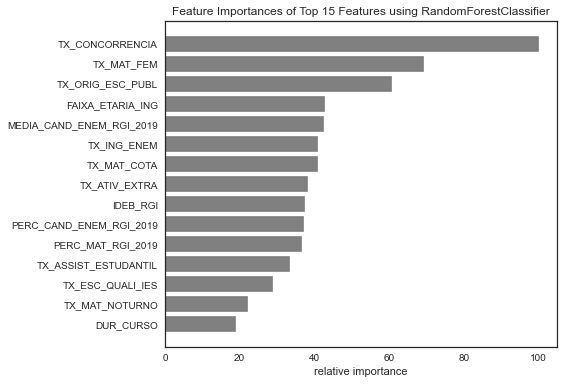

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [297]:
# Features importance
import yellowbrick as yb

from yellowbrick.features import FeatureImportances
# model = RandomForestClassifier()
viz = FeatureImportances(reg_lin, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [43]:
%pip install scikit-learn-pipeline-utils --user



Note: you may need to restart the kernel to use updated packages.


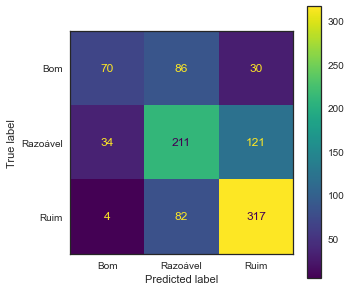

In [284]:
# Mostrar a Matriz de Confusão para os diversos patamares de desempenho dos cursos das áreas específicas selecionadas
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(reg_lin, X_test, y_test, ax=ax, values_format='d');

In [298]:
# usando o LGBMClassifier
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(objective='multiclass', random_state=42)

lgbm_model.fit(X_train, y_train)


LGBMClassifier(objective='multiclass', random_state=42)

In [299]:
y_pred = lgbm_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.6167539267015707
Precisão: 0.611497096610061
Recall: 0.6167539267015707
F1: 0.6112317782982484


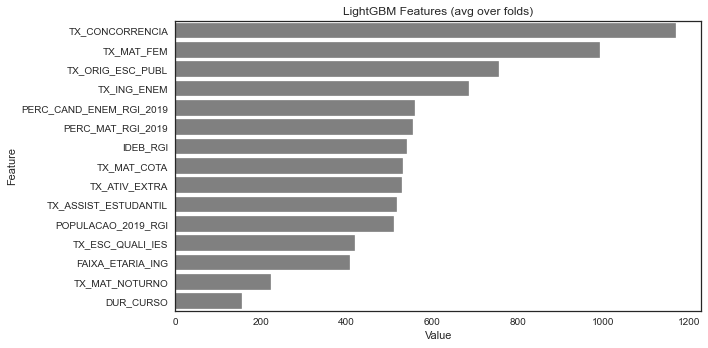

In [315]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:15], color='gray')
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [313]:
# Usando o ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
xtrees_model = ExtraTreesClassifier(n_estimators=100, random_state=0)
xtrees_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [302]:
y_pred = xtrees_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.5916230366492147
Precisão: 0.583869188568948
Recall: 0.5916230366492147
F1: 0.5842446850427253


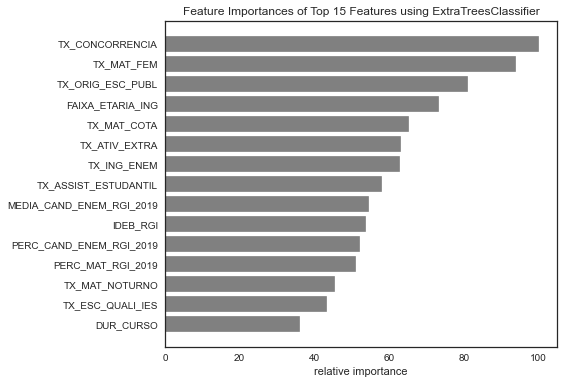

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [303]:
viz = FeatureImportances(xtrees_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [229]:
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 7 to 13098
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 4774 non-null   float64
 1   GRAU_ACADEMICO            4774 non-null   object 
 2   POLO                      4774 non-null   object 
 3   TX_MAT_FEM                4774 non-null   float64
 4   TX_MAT_COTA               4774 non-null   float64
 5   TX_MAT_NOTURNO            4774 non-null   float64
 6   TX_MAT_FINANC             4774 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      4774 non-null   float64
 8   FAIXA_ETARIA_ING          4774 non-null   float64
 9   TX_CONCORRENCIA           4774 non-null   float64
 10  TX_ING_ENEM               4774 non-null   float64
 11  TX_ORIG_ESC_PUBL          4774 non-null   float64
 12  TX_ATIV_EXTRA             4774 non-null   float64
 13  CPC_FAIXA                 4774 non-null   int64  
 14  TX_ESC_

In [304]:
# Redefinindo as bases de treino e teste (usando população numérica 0 - 23 em milhões)
# df_ML.iloc[:, np.r_[5:7,8,13:23,24:28,29:33]].info()
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]]
df_getdummies = pd.get_dummies(X)
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42)

Dimensões do dataset com get_dummies:  (4774, 20)


In [305]:
# Usando o XGBClassifier
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
#                             colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=1,
#                              n_estimators=100,reg_alpha=0, reg_lambda=1 )

xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [306]:
y_pred = xgb_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))


Acurácia: 0.6041884816753926
Precisão: 0.6044346224727412
Recall: 0.6041884816753926
F1: 0.6023414081663452


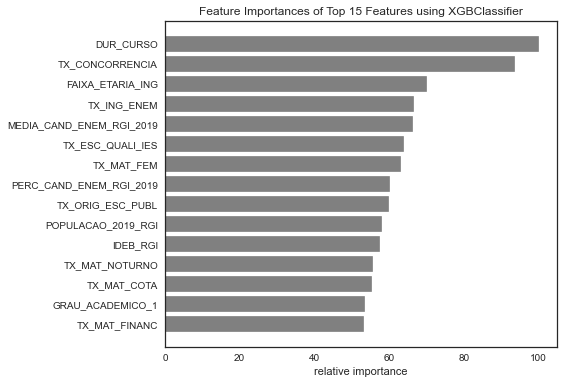

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using XGBClassifier'}, xlabel='relative importance'>

In [307]:
viz = FeatureImportances(xgb_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

##      2.1.2.2) IES Privadas (cursos de bacharelado e licenciatura)

In [316]:
# Filtro para cursos ofertados pela rede pública no grau de bacharelado ou licenciatura
df_ML= df_cursos_presenciais[(df_cursos_presenciais['TP_REDE']=='2')& (df_cursos_presenciais['GRAU_ACADEMICO'].isin(['1','2'])) ]
df_ML

COD_MUN COD_RGI COD_IES  CD_CURSO         CURSO  DUR_CURSO  \
0      1100023  110002    1540   0421D01       Direito        5.0   
1      1100023  110002    1540   0916F01      Farmácia        5.0   
2      1100023  110002    1540  9,13E+03    Enfermagem        5.0   
3      1100023  110002    4613   0313P01    Psicologia        5.0   
4      1100023  110002    4613   0915F01  Fisioterapia        5.0   
...        ...     ...     ...       ...           ...        ...   
13185  5300108  530001    5439   0912M01      Medicina        6.0   
13186  5300108  530001    5439   0915F01  Fisioterapia        5.0   
13187  5300108  530001    5439   0915N01      Nutrição        4.0   
13188  5300108  530001    5439   0916F01      Farmácia        5.0   
13190  5300108  530001    5439  9,13E+03    Enfermagem        5.0   

      GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  POPULACAO_2019_RGI  \
0                  1       2    S             105  ...                0.23   
1                  1       2    S              50  ...                0.23   
2                  1       2    S              50  ...                0.23   
3                  1       2    S             426  ...                0.23   
4                  1       2    S             389  ...                0.23   
...              ...     ...  ...             ...  ...                 ...   
13185              1       2    S             140  ...                3.02   
13186              1       2    S             130  ...                3.02   
13187              1       2    S             312  ...                3.02   
13188              1       2    S             131  ...                3.02   
13190              1       2    S             227  ...                3.02   

       FAIXA_POPULACAO_RGI  PERC_MAT_RGI_2019  IDEB_RGI  \
0                       PQ           4.310577      3.91   
1                       PQ           4.310577      3.91   
2                       PQ           4.310577      3.91   
3                       PQ           4.310577      3.91   
4                       PQ           4.310577      3.91   
...                    ...                ...       ...   
13185                   GD           5.160470      4.00   
13186                   GD           5.160470      4.00   
13187                   GD           5.160470      4.00   
13188                   GD           5.160470      4.00   
13190                   GD           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  \
0                         0.95                    4.9386                0.80   
1                         0.95                    4.9386                0.72   
2                         0.95                    4.9386                0.88   
3                         0.95                    4.9386                0.08   
4                         0.95                    4.9386                0.09   
...                        ...                       ...                 ...   
13185                     1.48                    5.3607                1.46   
13186                     1.48                    5.3607                0.78   
13187                     1.48                    5.3607                0.49   
13188                     1.48                    5.3607                0.53   
13190                     1.48                    5.3607                0.70   

       TARGET_TX_CONC_VAGAS  TARGET_TX_CONC_ING  TARGET_TX_OCUP  
0                      0.76                0.95            0.84  
1                      0.60                0.83            0.57  
2                      0.32                0.36            0.51  
3                      0.04                0.52            0.06  
4                      0.07                0.72            0.08  
...                     ...                 ...             ...  
13185                  0.69                0.47            1.00  
13186                  0.29                

In [317]:
# Verificando a distribuição dos valores para o Target
df_ML['TARGET_TX_CONC_VAGAS'].describe()

count    7411.000000
mean        0.331581
std         0.263337
min         0.000000
25%         0.150000
50%         0.280000
75%         0.430000
max         3.620000
Name: TARGET_TX_CONC_VAGAS, dtype: float64

In [318]:
# Definindo Target por faixas de desempenho: Ruim, Razoável. Bom e Excelente
# (Faixas definidas de acordo com os quartis)
# df_ML["TARGET"] = ["Ruim" if x <= 0.29 else ("Razoável" if (x > 0.29 and x <=0.46) \
#                                               else (("Bom" if (x > 0.46 and x <= 0.67) \
#                                                      else "Excelente")\
#                                                    )\
#                                             ) for x in (df_ML['TARGET_TX_CONC_ING'])] 
df_ML["TARGET"] = ["Ruim" if x <= 0.3 else ("Razoável" if ((x > 0.3 and x <=0.6))\
                                             else "Bom") for x in (df_ML['TARGET_TX_CONC_VAGAS'])] 




df_ML


COD_MUN COD_RGI COD_IES  CD_CURSO         CURSO  DUR_CURSO  \
0      1100023  110002    1540   0421D01       Direito        5.0   
1      1100023  110002    1540   0916F01      Farmácia        5.0   
2      1100023  110002    1540  9,13E+03    Enfermagem        5.0   
3      1100023  110002    4613   0313P01    Psicologia        5.0   
4      1100023  110002    4613   0915F01  Fisioterapia        5.0   
...        ...     ...     ...       ...           ...        ...   
13185  5300108  530001    5439   0912M01      Medicina        6.0   
13186  5300108  530001    5439   0915F01  Fisioterapia        5.0   
13187  5300108  530001    5439   0915N01      Nutrição        4.0   
13188  5300108  530001    5439   0916F01      Farmácia        5.0   
13190  5300108  530001    5439  9,13E+03    Enfermagem        5.0   

      GRAU_ACADEMICO TP_REDE POLO  QT_TOTAL_VAGAS  ...  FAIXA_POPULACAO_RGI  \
0                  1       2    S             105  ...                   PQ   
1                  1       2    S              50  ...                   PQ   
2                  1       2    S              50  ...                   PQ   
3                  1       2    S             426  ...                   PQ   
4                  1       2    S             389  ...                   PQ   
...              ...     ...  ...             ...  ...                  ...   
13185              1       2    S             140  ...                   GD   
13186              1       2    S             130  ...                   GD   
13187              1       2    S             312  ...                   GD   
13188              1       2    S             131  ...                   GD   
13190              1       2    S             227  ...                   GD   

       PERC_MAT_RGI_2019  IDEB_RGI  PERC_CAND_ENEM_RGI_2019  \
0               4.310577      3.91                     0.95   
1               4.310577      3.91                     0.95   
2               4.310577      3.91                     0.95   
3               4.310577      3.91                     0.95   
4               4.310577      3.91                     0.95   
...                  ...       ...                      ...   
13185           5.160470      4.00                     1.48   
13186           5.160470      4.00                     1.48   
13187           5.160470      4.00                     1.48   
13188           5.160470      4.00                     1.48   
13190           5.160470      4.00                     1.48   

       MEDIA_CAND_ENEM_RGI_2019  TARGET_TX_OCUP_INI  TARGET_TX_CONC_VAGAS  \
0                        4.9386                0.80                  0.76   
1                        4.9386                0.72                  0.60   
2                        4.9386                0.88                  0.32   
3                        4.9386                0.08                  0.04   
4                        4.9386                0.09                  0.07   
...                         ...                 ...                   ...   
13185                    5.3607                1.46                  0.69   
13186                    5.3607                0.78                  0.29   
13187                    5.3607                0.49                  0.30   
13188                    5.3607                0.53                  0.29   
13190                    5.3607                0.70                  0.56   

       TARGET_TX_CONC_ING  TARGET_TX_OCUP    TARGET  
0                    0.95            0.84       Bom  
1                    0.83            0.57  Razoável  
2                    0.36            0.51  Razoável  
3                    0.52            0.06      Ruim  
4                    0.72            0.08      Ruim  
...                   ...             ...       ...  
13185                0.47            1.00       Bom  
13186                0.37            0.47      Ruim  
13187                0.60            0.33      Ruim  
13188  

In [319]:
df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,34]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7411 entries, 0 to 13190
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 7411 non-null   float64
 1   TX_MAT_FEM                7411 non-null   float64
 2   TX_MAT_COTA               7411 non-null   float64
 3   TX_MAT_NOTURNO            7411 non-null   float64
 4   TX_MAT_FINANC             7411 non-null   float64
 5   TX_ASSIST_ESTUDANTIL      7411 non-null   float64
 6   FAIXA_ETARIA_ING          7411 non-null   float64
 7   TX_CONCORRENCIA           7411 non-null   float64
 8   TX_ING_ENEM               7411 non-null   float64
 9   TX_ORIG_ESC_PUBL          7411 non-null   float64
 10  TX_ATIV_EXTRA             7411 non-null   float64
 11  CPC_FAIXA                 7411 non-null   int64  
 12  TX_ESC_QUALI_IES          7411 non-null   float64
 13  VLR_REND_PROP_RGI         7411 non-null   float64
 14  POPULAC

In [320]:
# Analisando correlações entre as variáveis independentes e destas com o target (correlação de Sperman)
xyz = df_ML.iloc[:, np.r_[5,13:23,24:28,29:33,34]]
# xyz = df_ML.iloc[:, np.r_[5,13:23,24:27,28:32,35]]
corr_matrix, p_matrix = scipy.stats.spearmanr(xyz, axis=0)
pd.DataFrame(corr_matrix,columns=xyz.columns,index=xyz.columns).style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

In [321]:
# df_ML.iloc[:, np.r_[5,7,12:15,16:22,23:30]].info()
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7411 entries, 0 to 13190
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 7411 non-null   float64
 1   GRAU_ACADEMICO            7411 non-null   object 
 2   POLO                      7411 non-null   object 
 3   TX_MAT_FEM                7411 non-null   float64
 4   TX_MAT_COTA               7411 non-null   float64
 5   TX_MAT_NOTURNO            7411 non-null   float64
 6   TX_MAT_FINANC             7411 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      7411 non-null   float64
 8   FAIXA_ETARIA_ING          7411 non-null   float64
 9   TX_CONCORRENCIA           7411 non-null   float64
 10  TX_ING_ENEM               7411 non-null   float64
 11  TX_ORIG_ESC_PUBL          7411 non-null   float64
 12  TX_ATIV_EXTRA             7411 non-null   float64
 13  CPC_FAIXA                 7411 non-null   int64  
 14  TX_ESC_

In [322]:
# atribuir os valores das variáveis independentes a 'X'
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,28:33]]
# atribuir os valores da variável dependente a 'y'
y = df_ML['TARGET']
# Mostrar as dimensões de X e y
print('Dimensões de X = ', X.shape)
print('Dimensões de y = ', y.shape)

Dimensões de X =  (7411, 20)
Dimensões de y =  (7411,)


In [323]:
# Codificando com get_dummies(variáveis categóricas)
df_getdummies = pd.get_dummies(X)
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','TP_REDE','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

df_getdummies

Dimensões do dataset com get_dummies:  (7411, 22)


DUR_CURSO  TX_MAT_FEM  TX_MAT_COTA  TX_MAT_NOTURNO  TX_MAT_FINANC  \
0            5.0        0.55          0.0            1.00           0.25   
1            5.0        0.71          0.0            1.00           0.57   
2            5.0        0.90          0.0            1.00           0.82   
3            5.0        0.92          0.0            1.00           0.46   
4            5.0        0.82          0.0            1.00           0.52   
...          ...         ...          ...             ...            ...   
13185        6.0        0.61          0.0            0.00           0.00   
13186        5.0        0.74          0.0            0.86           0.00   
13187        4.0        0.74          0.0            0.62           0.00   
13188        5.0        0.63          0.0            1.00           0.00   
13190        5.0        0.84          0.0            0.56           0.00   

       TX_ASSIST_ESTUDANTIL  FAIXA_ETARIA_ING  TX_CONCORRENCIA  TX_ING_ENEM  \
0                      0.00               3.7             2.40         0.00   
1                      0.04               3.9             0.90         0.00   
2                      0.01               3.9             1.40         0.00   
3                      0.37               3.8             0.09         0.24   
4                      0.28               3.4             0.10         0.22   
...                     ...               ...              ...          ...   
13185                  0.00               3.2             7.39         0.89   
13186                  0.00               3.4             2.12         0.82   
13187                  0.00               3.7             1.04         0.52   
13188                  0.00               3.5             1.01         0.84   
13190                  0.00               3.3             1.32         0.84   

       TX_ORIG_ESC_PUBL  ...  TX_ESC_QUALI_IES  PERC_MAT_RGI_2019  IDEB_RGI  \
0                  0.84  ...              0.50           4.310577      3.91   
1                  0.94  ...              0.67           4.310577      3.91   
2                  0.99  ...              0.67           4.310577      3.91   
3                  0.91  ...              0.50           4.310577      3.91   
4                  0.96  ...              0.25           4.310577      3.91   
...                 ...  ...               ...                ...       ...   
13185              0.16  ...              0.08           5.160470      4.00   
13186              0.71  ...              0.38           5.160470      4.00   
13187              0.65  ...              0.30           5.160470      4.00   
13188              0.73  ...              0.44           5.160470      4.00   
13190              0.69  ...              0.46           5.160470      4.00   

       PERC_CAND_ENEM_RGI_2019  MEDIA_CAND_ENEM_RGI_2019  GRAU_ACADEMICO_1  \
0                         0.95                    4.9386                 1   
1                         0.95                    4.9386                 1   
2                         0.95                    4.9386                 1   
3                         0.95                    4.9386                 1   
4                         0.95                    4.9386                 1   
...                        ...                       ...               ...   
13185                     1.48                    5.3607                 1   
13186                     1.48                    5.3607                 1   
13187                     1.48                    5.3607                 1   
13188                     1.48                    5.3607                 1   
13190                     1.48                    5.3607                 1   

       POLO_S  FAIXA_POPULACAO_RGI_GD  FAIXA_POPULACAO_RGI_MD  \
0           1                       0                       0   
1           1                       0                       0   
2           1                       0                       0   

In [324]:
df_getdummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7411 entries, 0 to 13190
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 7411 non-null   float64
 1   TX_MAT_FEM                7411 non-null   float64
 2   TX_MAT_COTA               7411 non-null   float64
 3   TX_MAT_NOTURNO            7411 non-null   float64
 4   TX_MAT_FINANC             7411 non-null   float64
 5   TX_ASSIST_ESTUDANTIL      7411 non-null   float64
 6   FAIXA_ETARIA_ING          7411 non-null   float64
 7   TX_CONCORRENCIA           7411 non-null   float64
 8   TX_ING_ENEM               7411 non-null   float64
 9   TX_ORIG_ESC_PUBL          7411 non-null   float64
 10  TX_ATIV_EXTRA             7411 non-null   float64
 11  CPC_FAIXA                 7411 non-null   int64  
 12  TX_ESC_QUALI_IES          7411 non-null   float64
 13  PERC_MAT_RGI_2019         7411 non-null   float64
 14  IDEB_RG

In [332]:
# Dividir o dataset entre treino e teste (80/20), usar stratify pois as classes estão desbalanceadas
# X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42,\
#                                     stratify=df_getdummies[['GRAU_ACADEMICO_1','FAIXA_POPULACAO_RGI_GD',
#                                                             'FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_PQ']])
X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42,\
                                    stratify=df_getdummies[['FAIXA_POPULACAO_RGI_PQ','FAIXA_POPULACAO_RGI_MD','FAIXA_POPULACAO_RGI_GD']])

In [333]:
# Treinamento do Modelo ( utilizando o RandomForest)
reg_lin = RandomForestClassifier(n_estimators=1000,max_depth=20)
reg_lin.fit(X_train,y_train)


RandomForestClassifier(max_depth=20, n_estimators=1000)

In [334]:
# Testando o Modelo e auferindo o seu desempenho
reg_lin.score(X_test,y_test)

0.6567768037761295

In [335]:
# calculando outras métricas de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



y_pred = reg_lin.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.6567768037761295
Precisão: 0.6350417525756328
Recall: 0.6567768037761295
F1: 0.6283370807903004


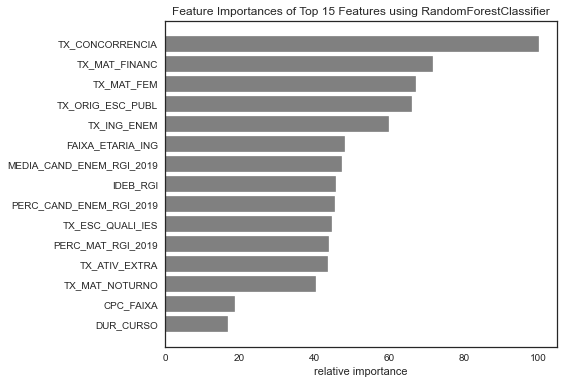

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [336]:
# model = RandomForestClassifier()
viz = FeatureImportances(reg_lin, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [337]:
# usando o LGBMClassifier
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(objective='multiclass', random_state=42)

lgbm_model.fit(X_train, y_train)


LGBMClassifier(objective='multiclass', random_state=42)

In [338]:
y_pred = lgbm_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.6378961564396494
Precisão: 0.6109332805477727
Recall: 0.6378961564396494
F1: 0.6169573288439105


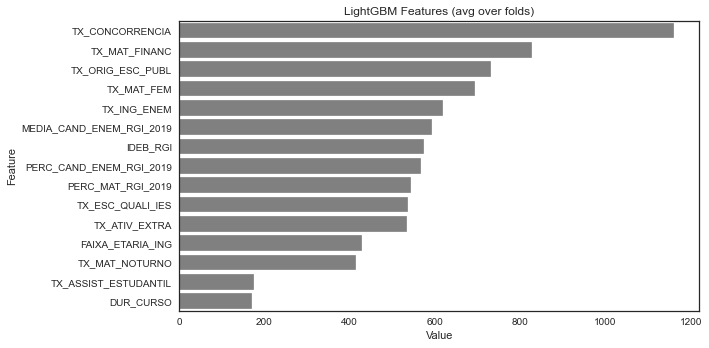

In [340]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:15], color='gray')
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [341]:
# Usando o ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
xtrees_model = ExtraTreesClassifier(n_estimators=100, random_state=0)
xtrees_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [342]:
y_pred = xtrees_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))

Acurácia: 0.6480107889413351
Precisão: 0.6262178790673908
Recall: 0.6480107889413351
F1: 0.6299138249415792


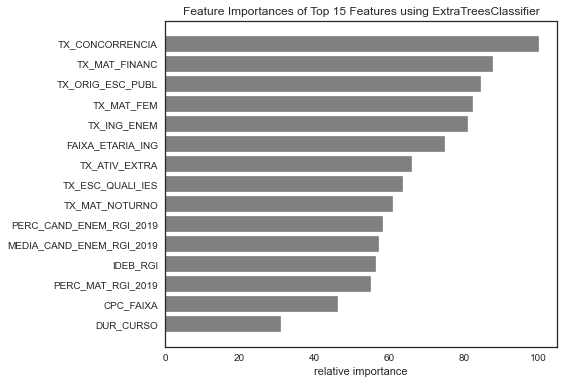

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [343]:
viz = FeatureImportances(xtrees_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()

In [344]:
df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7411 entries, 0 to 13190
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DUR_CURSO                 7411 non-null   float64
 1   GRAU_ACADEMICO            7411 non-null   object 
 2   POLO                      7411 non-null   object 
 3   TX_MAT_FEM                7411 non-null   float64
 4   TX_MAT_COTA               7411 non-null   float64
 5   TX_MAT_NOTURNO            7411 non-null   float64
 6   TX_MAT_FINANC             7411 non-null   float64
 7   TX_ASSIST_ESTUDANTIL      7411 non-null   float64
 8   FAIXA_ETARIA_ING          7411 non-null   float64
 9   TX_CONCORRENCIA           7411 non-null   float64
 10  TX_ING_ENEM               7411 non-null   float64
 11  TX_ORIG_ESC_PUBL          7411 non-null   float64
 12  TX_ATIV_EXTRA             7411 non-null   float64
 13  CPC_FAIXA                 7411 non-null   int64  
 14  TX_ESC_

In [345]:
# Redefinindo as bases de treino e teste (usando população numérica 0 - 23 em milhões)
# df_ML.iloc[:, np.r_[5:7,8,13:23,24:28,29:33]].info()
X = df_ML.iloc[:, np.r_[5:7,8,13:23,24:26,27,29:33]]
df_getdummies = pd.get_dummies(X)
# df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO','FAIXA_POPULACAO_RGI'])
df_getdummies = pd.get_dummies(X, columns=['GRAU_ACADEMICO','POLO'])
df_getdummies.drop(columns=['GRAU_ACADEMICO_2','POLO_N'],inplace=True)
print('Dimensões do dataset com get_dummies: ', df_getdummies.shape)

X_train, X_test, y_train, y_test = train_test_split(df_getdummies, y, test_size = 0.20, random_state = 42)

Dimensões do dataset com get_dummies:  (7411, 20)


In [346]:
# Usando o XGBClassifier
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
#                             colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=1,
#                              n_estimators=100,reg_alpha=0, reg_lambda=1 )

xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [347]:
y_pred = xgb_model.predict(X_test)
print ('Acurácia:',  accuracy_score(y_test, y_pred))
print ('Precisão:',  precision_score(y_test, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test, y_pred,average='weighted'))
print ('F1:',f1_score(y_test, y_pred,average='weighted'))


Acurácia: 0.6210384356035064
Precisão: 0.6042135142899314
Recall: 0.6210384356035064
F1: 0.6054355705738977


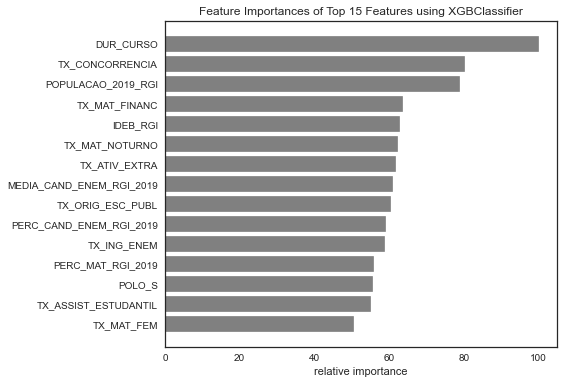

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using XGBClassifier'}, xlabel='relative importance'>

In [348]:
viz = FeatureImportances(xgb_model, topn=15, colors=['gray'])
viz.fit(df_getdummies, y)
viz.show()